In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'shuffled-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'shuffled-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

imagename  pen_pressure  letter_spacing  size  dimension  \
0  0968c_num1.png             2               2     2          1   
1  0809c_num2.png             2               2     2          2   
2  0237b_num6.png             2               2     2          2   
3  0069b_num2.png             2               2     2          1   
4  0966c_num4.png             2               2     2          2   

   is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0             2              2          3     2               1           2   
1             2              2          3     1               1           2   
2             2              2          2     2               1           2   
3             2              2          1     1               1           1   
4             2              2          2     1               1           2   

   formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0            2           3              2               2          1  
1            2           3              1               2          2  
2            2           2              2               2          2  
3            1           1              1               1          1  
4            2           2              2               2          2

(13570, 16)

13794

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

imagename  pen_pressure  letter_spacing  size  dimension  \
0   0968c_num1.png             2               2     2          1   
1   0809c_num2.png             2               2     2          2   
2   0237b_num6.png             2               2     2          2   
3   0069b_num2.png             2               2     2          1   
4   0966c_num4.png             2               2     2          2   
5   1316a_num2.png             2               2     1          1   
6   1503c_num2.png             2               1     2          2   
7   0113c_num1.png             2               3     2          2   
8   0221a_num6.png             2               2     2          2   
9   0068a_num4.png             1               1     2          2   
10  1094b_num1.png             2               3     1          1   
11  0337c_num6.png             2               2     2          2   
12  0837a_num4.png             2               2     2          2   
13  0941b_num3.png             2               2     2          2   
14  0260a_num3.png             2               2     2          2   
15  0598c_num4.png             1               3     2          2   
16  0380a_num2.png             2               2     2          2   
17  0384b_num2.png             2               2     2          2   
18  1224a_num3.png             2               2     2          2   
19  1131b_num3.png             2               2     2          2   

    is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0              2              2          3     2               1           2   
1              2              2          3     1               1           2   
2              2              2          2     2               1           2   
3              2              2          1     1               1           1   
4              2              2          2     1               1           2   
5              2              2          3     1               1           2   
6              2              2          2     1               1           3   
7              2              1          2     1               1           1   
8              2              1          1     1               1           4   
9              2              2          1     1               1           2   
10             2              2          2     1               1           1   
11             2              2          3     1               1           2   
12             2              2          1     1               1           3   
13             2              2          2     1               1           1   
14             2              2          2     1               1           2   
15             1              1          2     1               1           1   
16             2              2          4     1               1           2   
17             2              2          2     1               1           2   
18             2              2          1     1               1           4   
19             2              2          1     1               1           2   

    formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0             2           3              2               2          1  
1             2           3              1               2          2  
2             2           2              2               2          2  
3             1           1              1               1          1  
4             2           2              2               2          2  
5             2           2              3               2          2  
6             2           2              3               2          2  
7             2           2              2               2          2  
8             1           2              3               1          2  
9             2           2              2               2          2  
10            1           3              2               1          1  
11            

(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.save('simple_ae_maxpool_Shuffled_weights_v1.h5')
autoencoder.load_weights('simple_ae_maxpool_Shuffled_weights_v1.h5')

In [10]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
for layer in encoder.layers:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:

# # model = Sequential()
# input_layer = Input((64,64,1))
# model = BatchNormalization()(input_layer)

# model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
# model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)
# # model = Flatten()(model)

# dense_layer = Dense(512, activation='relu')(model)
# dense_layer = Dropout(0.5)(dense_layer)
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten()((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

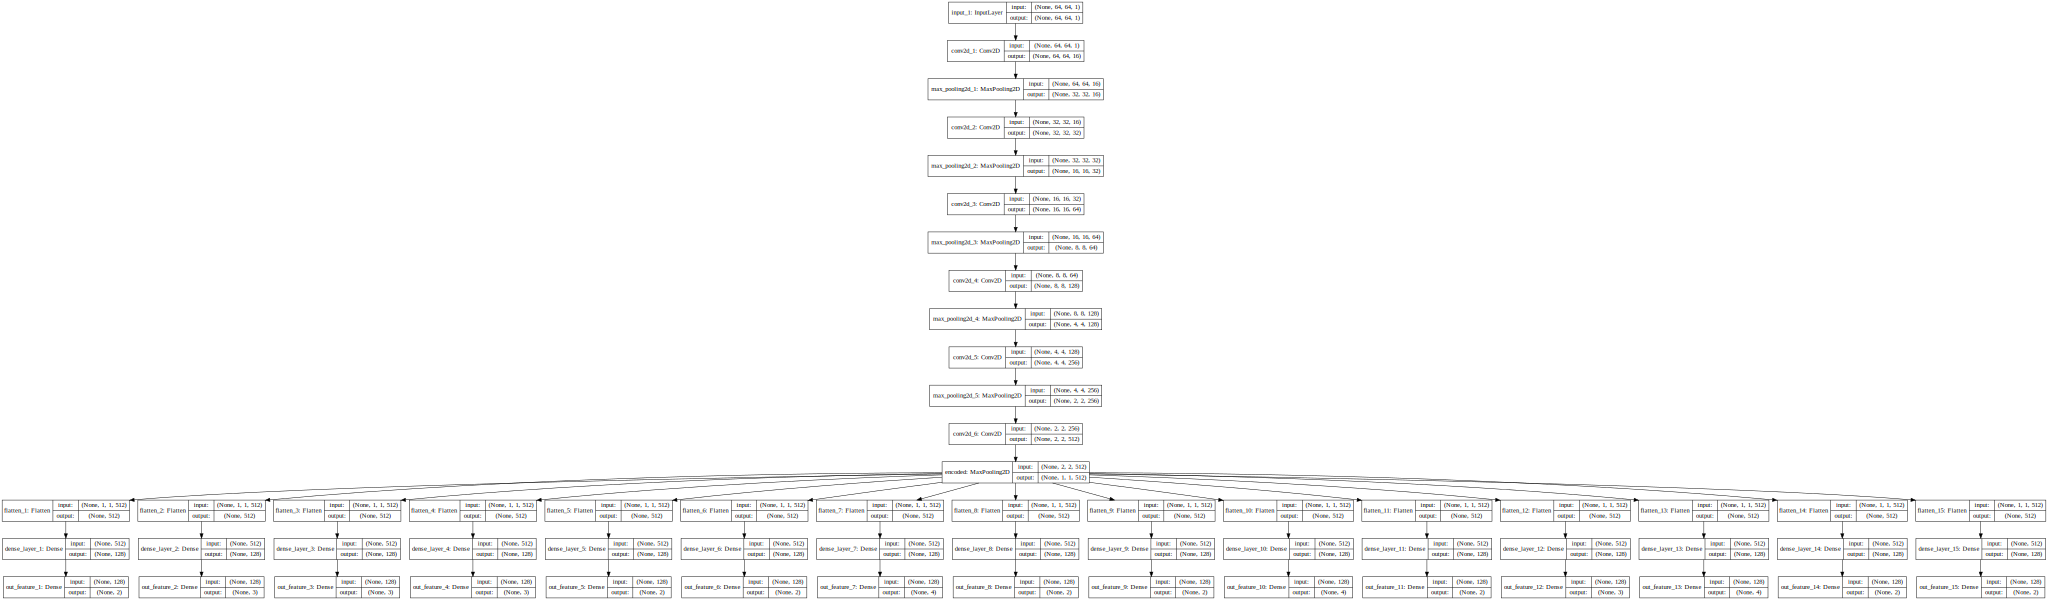

In [12]:
#SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [14]:
# df_data[df_data['f8']==2]

In [15]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [16]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [17]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [18]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [19]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [20]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
2
2
2
2
2
2
1
1
1
3
2
3
4
2
2


In [21]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

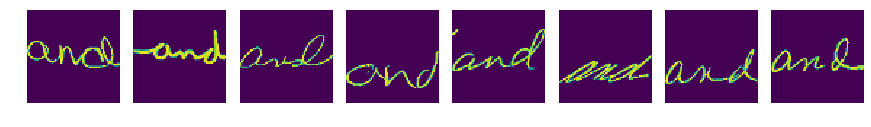

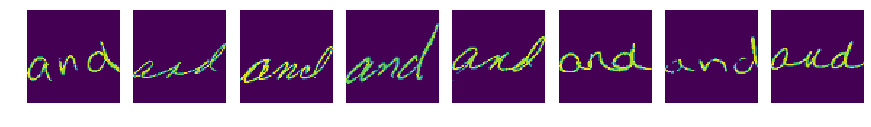

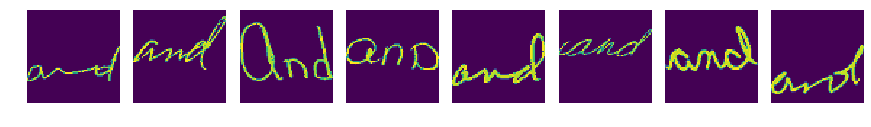

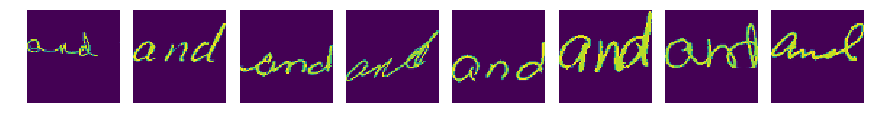

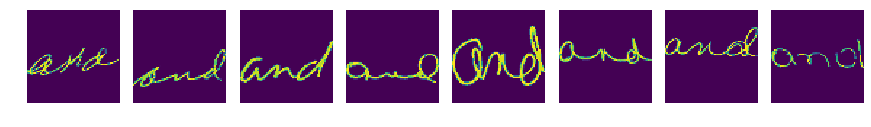

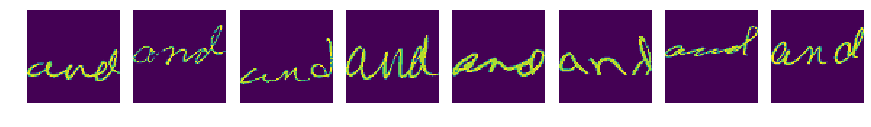

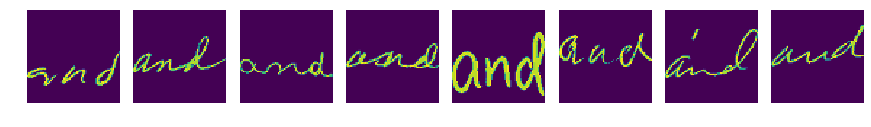

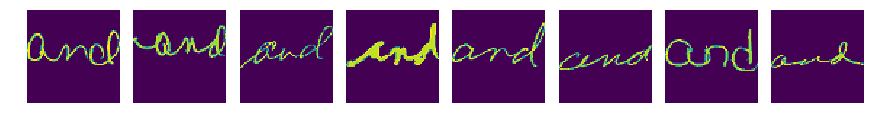

In [22]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [23]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [24]:
mc = ModelCheckpoint(filepath='15-Multitask-FrozenEncoder-shuffled_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [25]:
EPOCHS = 500000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
# human_features.load_weights('15_human_features_weights_shuffled_v1.h5')

In [27]:
#human_features.load_weights('weights/15-Multitask-FrozenEncoder-shuffled_v1.h5')
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/500000

Epoch 00001: val_loss improved from inf to 15.73057, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 2/500000

Epoch 00002: val_loss did not improve from 15.73057
Epoch 3/500000

Epoch 00003: val_loss did not improve from 15.73057
Epoch 4/500000

Epoch 00004: val_loss did not improve from 15.73057
Epoch 5/500000

Epoch 00005: val_loss improved from 15.73057 to 15.71442, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 6/500000

Epoch 00006: val_loss did not improve from 15.71442
Epoch 7/500000

Epoch 00007: val_loss did not improve from 15.71442
Epoch 8/500000

Epoch 00008: val_loss did not improve from 15.71442
Epoch 9/500000

Epoch 00009: val_loss improved from 15.71442 to 15.59683, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 10/500000

Epoch 00010: val_loss did not improve from 15.59683
Epoch 11/500000

Epoch 00011: val_loss improved from 15.59683 to 14.70162, saving model to weights/15-Multit


Epoch 00099: val_loss did not improve from 10.67642
Epoch 100/500000

Epoch 00100: val_loss did not improve from 10.67642
Epoch 101/500000

Epoch 00101: val_loss did not improve from 10.67642
Epoch 102/500000

Epoch 00102: val_loss did not improve from 10.67642
Epoch 103/500000

Epoch 00103: val_loss did not improve from 10.67642
Epoch 104/500000

Epoch 00104: val_loss improved from 10.67642 to 10.44330, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 105/500000

Epoch 00105: val_loss did not improve from 10.44330
Epoch 106/500000

Epoch 00106: val_loss did not improve from 10.44330
Epoch 107/500000

Epoch 00107: val_loss did not improve from 10.44330
Epoch 108/500000

Epoch 00108: val_loss did not improve from 10.44330
Epoch 109/500000

Epoch 00109: val_loss did not improve from 10.44330
Epoch 110/500000

Epoch 00110: val_loss did not improve from 10.44330
Epoch 111/500000

Epoch 00111: val_loss did not improve from 10.44330
Epoch 112/500000

Epoch 00112: val_


Epoch 00211: val_loss did not improve from 9.44754
Epoch 212/500000

Epoch 00212: val_loss did not improve from 9.44754
Epoch 213/500000

Epoch 00213: val_loss did not improve from 9.44754
Epoch 214/500000

Epoch 00214: val_loss did not improve from 9.44754
Epoch 215/500000

Epoch 00215: val_loss did not improve from 9.44754
Epoch 216/500000

Epoch 00216: val_loss did not improve from 9.44754
Epoch 217/500000

Epoch 00217: val_loss did not improve from 9.44754
Epoch 218/500000

Epoch 00218: val_loss did not improve from 9.44754
Epoch 219/500000

Epoch 00219: val_loss did not improve from 9.44754
Epoch 220/500000

Epoch 00220: val_loss did not improve from 9.44754
Epoch 221/500000

Epoch 00221: val_loss did not improve from 9.44754
Epoch 222/500000

Epoch 00222: val_loss did not improve from 9.44754
Epoch 223/500000

Epoch 00223: val_loss did not improve from 9.44754
Epoch 224/500000

Epoch 00224: val_loss did not improve from 9.44754
Epoch 225/500000

Epoch 00225: val_loss did not imp


Epoch 00325: val_loss did not improve from 8.79494
Epoch 326/500000

Epoch 00326: val_loss did not improve from 8.79494
Epoch 327/500000

Epoch 00327: val_loss did not improve from 8.79494
Epoch 328/500000

Epoch 00328: val_loss did not improve from 8.79494
Epoch 329/500000

Epoch 00329: val_loss did not improve from 8.79494
Epoch 330/500000

Epoch 00330: val_loss did not improve from 8.79494
Epoch 331/500000

Epoch 00331: val_loss did not improve from 8.79494
Epoch 332/500000

Epoch 00332: val_loss did not improve from 8.79494
Epoch 333/500000

Epoch 00333: val_loss did not improve from 8.79494
Epoch 334/500000

Epoch 00334: val_loss did not improve from 8.79494
Epoch 335/500000

Epoch 00335: val_loss did not improve from 8.79494
Epoch 336/500000

Epoch 00336: val_loss did not improve from 8.79494
Epoch 337/500000

Epoch 00337: val_loss did not improve from 8.79494
Epoch 338/500000

Epoch 00338: val_loss did not improve from 8.79494
Epoch 339/500000

Epoch 00339: val_loss did not imp


Epoch 00443: val_loss did not improve from 8.54217
Epoch 444/500000

Epoch 00444: val_loss did not improve from 8.54217
Epoch 445/500000

Epoch 00445: val_loss improved from 8.54217 to 8.48413, saving model to weights/15-Multitask-FrozenEncoder-shuffled_v1.h5
Epoch 446/500000

Epoch 00446: val_loss did not improve from 8.48413
Epoch 447/500000

Epoch 00447: val_loss did not improve from 8.48413
Epoch 448/500000

Epoch 00448: val_loss did not improve from 8.48413
Epoch 449/500000

Epoch 00449: val_loss did not improve from 8.48413
Epoch 450/500000

Epoch 00450: val_loss did not improve from 8.48413
Epoch 451/500000

Epoch 00451: val_loss did not improve from 8.48413
Epoch 452/500000

Epoch 00452: val_loss did not improve from 8.48413
Epoch 453/500000

Epoch 00453: val_loss did not improve from 8.48413
Epoch 454/500000

Epoch 00454: val_loss did not improve from 8.48413
Epoch 455/500000

Epoch 00455: val_loss did not improve from 8.48413
Epoch 456/500000

Epoch 00456: val_loss did not i


Epoch 00560: val_loss did not improve from 8.30408
Epoch 561/500000

Epoch 00561: val_loss did not improve from 8.30408
Epoch 562/500000

Epoch 00562: val_loss did not improve from 8.30408
Epoch 563/500000

Epoch 00563: val_loss did not improve from 8.30408
Epoch 564/500000

Epoch 00564: val_loss did not improve from 8.30408
Epoch 565/500000

Epoch 00565: val_loss did not improve from 8.30408
Epoch 566/500000

Epoch 00566: val_loss did not improve from 8.30408
Epoch 567/500000

Epoch 00567: val_loss did not improve from 8.30408
Epoch 568/500000

Epoch 00568: val_loss did not improve from 8.30408
Epoch 569/500000

Epoch 00569: val_loss did not improve from 8.30408
Epoch 570/500000

Epoch 00570: val_loss did not improve from 8.30408
Epoch 571/500000

Epoch 00571: val_loss did not improve from 8.30408
Epoch 572/500000

Epoch 00572: val_loss did not improve from 8.30408
Epoch 573/500000

Epoch 00573: val_loss did not improve from 8.30408
Epoch 574/500000

Epoch 00574: val_loss did not imp


Epoch 00677: val_loss did not improve from 8.23001
Epoch 678/500000

Epoch 00678: val_loss did not improve from 8.23001
Epoch 679/500000

Epoch 00679: val_loss did not improve from 8.23001
Epoch 680/500000

Epoch 00680: val_loss did not improve from 8.23001
Epoch 681/500000

Epoch 00681: val_loss did not improve from 8.23001
Epoch 682/500000

Epoch 00682: val_loss did not improve from 8.23001
Epoch 683/500000

Epoch 00683: val_loss did not improve from 8.23001
Epoch 684/500000

Epoch 00684: val_loss did not improve from 8.23001
Epoch 685/500000

Epoch 00685: val_loss did not improve from 8.23001
Epoch 686/500000

Epoch 00686: val_loss did not improve from 8.23001
Epoch 687/500000

Epoch 00687: val_loss did not improve from 8.23001
Epoch 688/500000

Epoch 00688: val_loss did not improve from 8.23001
Epoch 689/500000

Epoch 00689: val_loss did not improve from 8.23001
Epoch 690/500000

Epoch 00690: val_loss did not improve from 8.23001
Epoch 691/500000

Epoch 00691: val_loss did not imp


Epoch 00793: val_loss did not improve from 8.00659
Epoch 794/500000

Epoch 00794: val_loss did not improve from 8.00659
Epoch 795/500000

Epoch 00795: val_loss did not improve from 8.00659
Epoch 796/500000

Epoch 00796: val_loss did not improve from 8.00659
Epoch 797/500000

Epoch 00797: val_loss did not improve from 8.00659
Epoch 798/500000

Epoch 00798: val_loss did not improve from 8.00659
Epoch 799/500000

Epoch 00799: val_loss did not improve from 8.00659
Epoch 800/500000

Epoch 00800: val_loss did not improve from 8.00659
Epoch 801/500000

Epoch 00801: val_loss did not improve from 8.00659
Epoch 802/500000

Epoch 00802: val_loss did not improve from 8.00659
Epoch 803/500000

Epoch 00803: val_loss did not improve from 8.00659
Epoch 804/500000

Epoch 00804: val_loss did not improve from 8.00659
Epoch 805/500000

Epoch 00805: val_loss did not improve from 8.00659
Epoch 806/500000

Epoch 00806: val_loss did not improve from 8.00659
Epoch 807/500000

Epoch 00807: val_loss did not imp


Epoch 00910: val_loss did not improve from 7.78828
Epoch 911/500000

Epoch 00911: val_loss did not improve from 7.78828
Epoch 912/500000

Epoch 00912: val_loss did not improve from 7.78828
Epoch 913/500000

Epoch 00913: val_loss did not improve from 7.78828
Epoch 914/500000

Epoch 00914: val_loss did not improve from 7.78828
Epoch 915/500000

Epoch 00915: val_loss did not improve from 7.78828
Epoch 916/500000

Epoch 00916: val_loss did not improve from 7.78828
Epoch 917/500000

Epoch 00917: val_loss did not improve from 7.78828
Epoch 918/500000

Epoch 00918: val_loss did not improve from 7.78828
Epoch 919/500000

Epoch 00919: val_loss did not improve from 7.78828
Epoch 920/500000

Epoch 00920: val_loss did not improve from 7.78828
Epoch 921/500000

Epoch 00921: val_loss did not improve from 7.78828
Epoch 922/500000

Epoch 00922: val_loss did not improve from 7.78828
Epoch 923/500000

Epoch 00923: val_loss did not improve from 7.78828
Epoch 924/500000

Epoch 00924: val_loss did not imp


Epoch 01029: val_loss did not improve from 7.78828
Epoch 1030/500000

Epoch 01030: val_loss did not improve from 7.78828
Epoch 1031/500000

Epoch 01031: val_loss did not improve from 7.78828
Epoch 1032/500000

Epoch 01032: val_loss did not improve from 7.78828
Epoch 1033/500000

Epoch 01033: val_loss did not improve from 7.78828
Epoch 1034/500000

Epoch 01034: val_loss did not improve from 7.78828
Epoch 1035/500000

Epoch 01035: val_loss did not improve from 7.78828
Epoch 1036/500000

Epoch 01036: val_loss did not improve from 7.78828
Epoch 1037/500000

Epoch 01037: val_loss did not improve from 7.78828
Epoch 1038/500000

Epoch 01038: val_loss did not improve from 7.78828
Epoch 1039/500000

Epoch 01039: val_loss did not improve from 7.78828
Epoch 1040/500000

Epoch 01040: val_loss did not improve from 7.78828
Epoch 1041/500000

Epoch 01041: val_loss did not improve from 7.78828
Epoch 1042/500000

Epoch 01042: val_loss did not improve from 7.78828
Epoch 1043/500000

Epoch 01043: val_lo


Epoch 01145: val_loss did not improve from 7.78116
Epoch 1146/500000

Epoch 01146: val_loss did not improve from 7.78116
Epoch 1147/500000

Epoch 01147: val_loss did not improve from 7.78116
Epoch 1148/500000

Epoch 01148: val_loss did not improve from 7.78116
Epoch 1149/500000

Epoch 01149: val_loss did not improve from 7.78116
Epoch 1150/500000

Epoch 01150: val_loss did not improve from 7.78116
Epoch 1151/500000

Epoch 01151: val_loss did not improve from 7.78116
Epoch 1152/500000

Epoch 01152: val_loss did not improve from 7.78116
Epoch 1153/500000

Epoch 01153: val_loss did not improve from 7.78116
Epoch 1154/500000

Epoch 01154: val_loss did not improve from 7.78116
Epoch 1155/500000

Epoch 01155: val_loss did not improve from 7.78116
Epoch 1156/500000

Epoch 01156: val_loss did not improve from 7.78116
Epoch 1157/500000

Epoch 01157: val_loss did not improve from 7.78116
Epoch 1158/500000

Epoch 01158: val_loss did not improve from 7.78116
Epoch 1159/500000

Epoch 01159: val_lo


Epoch 01262: val_loss did not improve from 7.66034
Epoch 1263/500000

Epoch 01263: val_loss did not improve from 7.66034
Epoch 1264/500000

Epoch 01264: val_loss did not improve from 7.66034
Epoch 1265/500000

Epoch 01265: val_loss did not improve from 7.66034
Epoch 1266/500000

Epoch 01266: val_loss did not improve from 7.66034
Epoch 1267/500000

Epoch 01267: val_loss did not improve from 7.66034
Epoch 1268/500000

Epoch 01268: val_loss did not improve from 7.66034
Epoch 1269/500000

Epoch 01269: val_loss did not improve from 7.66034
Epoch 1270/500000

Epoch 01270: val_loss did not improve from 7.66034
Epoch 1271/500000

Epoch 01271: val_loss did not improve from 7.66034
Epoch 1272/500000

Epoch 01272: val_loss did not improve from 7.66034
Epoch 1273/500000

Epoch 01273: val_loss did not improve from 7.66034
Epoch 1274/500000

Epoch 01274: val_loss did not improve from 7.66034
Epoch 1275/500000

Epoch 01275: val_loss did not improve from 7.66034
Epoch 1276/500000

Epoch 01276: val_lo


Epoch 01379: val_loss did not improve from 7.56217
Epoch 1380/500000

Epoch 01380: val_loss did not improve from 7.56217
Epoch 1381/500000

Epoch 01381: val_loss did not improve from 7.56217
Epoch 1382/500000

Epoch 01382: val_loss did not improve from 7.56217
Epoch 1383/500000

Epoch 01383: val_loss did not improve from 7.56217
Epoch 1384/500000

Epoch 01384: val_loss did not improve from 7.56217
Epoch 1385/500000

Epoch 01385: val_loss did not improve from 7.56217
Epoch 1386/500000

Epoch 01386: val_loss did not improve from 7.56217
Epoch 1387/500000

Epoch 01387: val_loss did not improve from 7.56217
Epoch 1388/500000

Epoch 01388: val_loss did not improve from 7.56217
Epoch 1389/500000

Epoch 01389: val_loss did not improve from 7.56217
Epoch 1390/500000

Epoch 01390: val_loss did not improve from 7.56217
Epoch 1391/500000

Epoch 01391: val_loss did not improve from 7.56217
Epoch 1392/500000

Epoch 01392: val_loss did not improve from 7.56217
Epoch 1393/500000

Epoch 01393: val_lo


Epoch 01496: val_loss did not improve from 7.53114
Epoch 1497/500000

Epoch 01497: val_loss did not improve from 7.53114
Epoch 1498/500000

Epoch 01498: val_loss did not improve from 7.53114
Epoch 1499/500000

Epoch 01499: val_loss did not improve from 7.53114
Epoch 1500/500000

Epoch 01500: val_loss did not improve from 7.53114
Epoch 1501/500000

Epoch 01501: val_loss did not improve from 7.53114
Epoch 1502/500000

Epoch 01502: val_loss did not improve from 7.53114
Epoch 1503/500000

Epoch 01503: val_loss did not improve from 7.53114
Epoch 1504/500000

Epoch 01504: val_loss did not improve from 7.53114
Epoch 1505/500000

Epoch 01505: val_loss did not improve from 7.53114
Epoch 1506/500000

Epoch 01506: val_loss did not improve from 7.53114
Epoch 1507/500000

Epoch 01507: val_loss did not improve from 7.53114
Epoch 1508/500000

Epoch 01508: val_loss did not improve from 7.53114
Epoch 1509/500000

Epoch 01509: val_loss did not improve from 7.53114
Epoch 1510/500000

Epoch 01510: val_lo


Epoch 01610: val_loss did not improve from 7.14653
Epoch 1611/500000

Epoch 01611: val_loss did not improve from 7.14653
Epoch 1612/500000

Epoch 01612: val_loss did not improve from 7.14653
Epoch 1613/500000

Epoch 01613: val_loss did not improve from 7.14653
Epoch 1614/500000

Epoch 01614: val_loss did not improve from 7.14653
Epoch 1615/500000

Epoch 01615: val_loss did not improve from 7.14653
Epoch 1616/500000

Epoch 01616: val_loss did not improve from 7.14653
Epoch 1617/500000

Epoch 01617: val_loss did not improve from 7.14653
Epoch 1618/500000

Epoch 01618: val_loss did not improve from 7.14653
Epoch 1619/500000

Epoch 01619: val_loss did not improve from 7.14653
Epoch 1620/500000

Epoch 01620: val_loss did not improve from 7.14653
Epoch 1621/500000

Epoch 01621: val_loss did not improve from 7.14653
Epoch 1622/500000

Epoch 01622: val_loss did not improve from 7.14653
Epoch 1623/500000

Epoch 01623: val_loss did not improve from 7.14653
Epoch 1624/500000

Epoch 01624: val_lo


Epoch 01728: val_loss did not improve from 7.14653
Epoch 1729/500000

Epoch 01729: val_loss did not improve from 7.14653
Epoch 1730/500000

Epoch 01730: val_loss did not improve from 7.14653
Epoch 1731/500000

Epoch 01731: val_loss did not improve from 7.14653
Epoch 1732/500000

Epoch 01732: val_loss did not improve from 7.14653
Epoch 1733/500000

Epoch 01733: val_loss did not improve from 7.14653
Epoch 1734/500000

Epoch 01734: val_loss did not improve from 7.14653
Epoch 1735/500000

Epoch 01735: val_loss did not improve from 7.14653
Epoch 1736/500000

Epoch 01736: val_loss did not improve from 7.14653
Epoch 1737/500000

Epoch 01737: val_loss did not improve from 7.14653
Epoch 1738/500000

Epoch 01738: val_loss did not improve from 7.14653
Epoch 1739/500000

Epoch 01739: val_loss did not improve from 7.14653
Epoch 1740/500000

Epoch 01740: val_loss did not improve from 7.14653
Epoch 1741/500000

Epoch 01741: val_loss did not improve from 7.14653
Epoch 1742/500000

Epoch 01742: val_lo


Epoch 01846: val_loss did not improve from 7.14653
Epoch 1847/500000

Epoch 01847: val_loss did not improve from 7.14653
Epoch 1848/500000

Epoch 01848: val_loss did not improve from 7.14653
Epoch 1849/500000

Epoch 01849: val_loss did not improve from 7.14653
Epoch 1850/500000

Epoch 01850: val_loss did not improve from 7.14653
Epoch 1851/500000

Epoch 01851: val_loss did not improve from 7.14653
Epoch 1852/500000

Epoch 01852: val_loss did not improve from 7.14653
Epoch 1853/500000

Epoch 01853: val_loss did not improve from 7.14653
Epoch 1854/500000

Epoch 01854: val_loss did not improve from 7.14653
Epoch 1855/500000

Epoch 01855: val_loss did not improve from 7.14653
Epoch 1856/500000

Epoch 01856: val_loss did not improve from 7.14653
Epoch 1857/500000

Epoch 01857: val_loss did not improve from 7.14653
Epoch 1858/500000

Epoch 01858: val_loss did not improve from 7.14653
Epoch 1859/500000

Epoch 01859: val_loss did not improve from 7.14653
Epoch 1860/500000

Epoch 01860: val_lo


Epoch 01964: val_loss did not improve from 7.14653
Epoch 1965/500000

Epoch 01965: val_loss did not improve from 7.14653
Epoch 1966/500000

Epoch 01966: val_loss did not improve from 7.14653
Epoch 1967/500000

Epoch 01967: val_loss did not improve from 7.14653
Epoch 1968/500000

Epoch 01968: val_loss did not improve from 7.14653
Epoch 1969/500000

Epoch 01969: val_loss did not improve from 7.14653
Epoch 1970/500000

Epoch 01970: val_loss did not improve from 7.14653
Epoch 1971/500000

Epoch 01971: val_loss did not improve from 7.14653
Epoch 1972/500000

Epoch 01972: val_loss did not improve from 7.14653
Epoch 1973/500000

Epoch 01973: val_loss did not improve from 7.14653
Epoch 1974/500000

Epoch 01974: val_loss did not improve from 7.14653
Epoch 1975/500000

Epoch 01975: val_loss did not improve from 7.14653
Epoch 1976/500000

Epoch 01976: val_loss did not improve from 7.14653
Epoch 1977/500000

Epoch 01977: val_loss did not improve from 7.14653
Epoch 1978/500000

Epoch 01978: val_lo


Epoch 02082: val_loss did not improve from 7.14653
Epoch 2083/500000

Epoch 02083: val_loss did not improve from 7.14653
Epoch 2084/500000

Epoch 02084: val_loss did not improve from 7.14653
Epoch 2085/500000

Epoch 02085: val_loss did not improve from 7.14653
Epoch 2086/500000

Epoch 02086: val_loss did not improve from 7.14653
Epoch 2087/500000

Epoch 02087: val_loss did not improve from 7.14653
Epoch 2088/500000

Epoch 02088: val_loss did not improve from 7.14653
Epoch 2089/500000

Epoch 02089: val_loss did not improve from 7.14653
Epoch 2090/500000

Epoch 02090: val_loss did not improve from 7.14653
Epoch 2091/500000

Epoch 02091: val_loss did not improve from 7.14653
Epoch 2092/500000

Epoch 02092: val_loss did not improve from 7.14653
Epoch 2093/500000

Epoch 02093: val_loss did not improve from 7.14653
Epoch 2094/500000

Epoch 02094: val_loss did not improve from 7.14653
Epoch 2095/500000

Epoch 02095: val_loss did not improve from 7.14653
Epoch 2096/500000

Epoch 02096: val_lo


Epoch 02200: val_loss did not improve from 7.14653
Epoch 2201/500000

Epoch 02201: val_loss did not improve from 7.14653
Epoch 2202/500000

Epoch 02202: val_loss did not improve from 7.14653
Epoch 2203/500000

Epoch 02203: val_loss did not improve from 7.14653
Epoch 2204/500000

Epoch 02204: val_loss did not improve from 7.14653
Epoch 2205/500000

Epoch 02205: val_loss did not improve from 7.14653
Epoch 2206/500000

Epoch 02206: val_loss did not improve from 7.14653
Epoch 2207/500000

Epoch 02207: val_loss did not improve from 7.14653
Epoch 2208/500000

Epoch 02208: val_loss did not improve from 7.14653
Epoch 2209/500000

Epoch 02209: val_loss did not improve from 7.14653
Epoch 2210/500000

Epoch 02210: val_loss did not improve from 7.14653
Epoch 2211/500000

Epoch 02211: val_loss did not improve from 7.14653
Epoch 2212/500000

Epoch 02212: val_loss did not improve from 7.14653
Epoch 2213/500000

Epoch 02213: val_loss did not improve from 7.14653
Epoch 2214/500000

Epoch 02214: val_lo


Epoch 02318: val_loss did not improve from 7.14653
Epoch 2319/500000

Epoch 02319: val_loss did not improve from 7.14653
Epoch 2320/500000

Epoch 02320: val_loss did not improve from 7.14653
Epoch 2321/500000

Epoch 02321: val_loss did not improve from 7.14653
Epoch 2322/500000

Epoch 02322: val_loss did not improve from 7.14653
Epoch 2323/500000

Epoch 02323: val_loss did not improve from 7.14653
Epoch 2324/500000

Epoch 02324: val_loss did not improve from 7.14653
Epoch 2325/500000

Epoch 02325: val_loss did not improve from 7.14653
Epoch 2326/500000

Epoch 02326: val_loss did not improve from 7.14653
Epoch 2327/500000

Epoch 02327: val_loss did not improve from 7.14653
Epoch 2328/500000

Epoch 02328: val_loss did not improve from 7.14653
Epoch 2329/500000

Epoch 02329: val_loss did not improve from 7.14653
Epoch 2330/500000

Epoch 02330: val_loss did not improve from 7.14653
Epoch 2331/500000

Epoch 02331: val_loss did not improve from 7.14653
Epoch 2332/500000

Epoch 02332: val_lo


Epoch 02436: val_loss did not improve from 7.14653
Epoch 2437/500000

Epoch 02437: val_loss did not improve from 7.14653
Epoch 2438/500000

Epoch 02438: val_loss did not improve from 7.14653
Epoch 2439/500000

Epoch 02439: val_loss did not improve from 7.14653
Epoch 2440/500000

Epoch 02440: val_loss did not improve from 7.14653
Epoch 2441/500000

Epoch 02441: val_loss did not improve from 7.14653
Epoch 2442/500000

Epoch 02442: val_loss did not improve from 7.14653
Epoch 2443/500000

Epoch 02443: val_loss did not improve from 7.14653
Epoch 2444/500000

Epoch 02444: val_loss did not improve from 7.14653
Epoch 2445/500000

Epoch 02445: val_loss did not improve from 7.14653
Epoch 2446/500000

Epoch 02446: val_loss did not improve from 7.14653
Epoch 2447/500000

Epoch 02447: val_loss did not improve from 7.14653
Epoch 2448/500000

Epoch 02448: val_loss did not improve from 7.14653
Epoch 2449/500000

Epoch 02449: val_loss did not improve from 7.14653
Epoch 2450/500000

Epoch 02450: val_lo


Epoch 02554: val_loss did not improve from 7.14653
Epoch 2555/500000

Epoch 02555: val_loss did not improve from 7.14653
Epoch 2556/500000

Epoch 02556: val_loss did not improve from 7.14653
Epoch 2557/500000

Epoch 02557: val_loss did not improve from 7.14653
Epoch 2558/500000

Epoch 02558: val_loss did not improve from 7.14653
Epoch 2559/500000

Epoch 02559: val_loss did not improve from 7.14653
Epoch 2560/500000

Epoch 02560: val_loss did not improve from 7.14653
Epoch 2561/500000

Epoch 02561: val_loss did not improve from 7.14653
Epoch 2562/500000

Epoch 02562: val_loss did not improve from 7.14653
Epoch 2563/500000

Epoch 02563: val_loss did not improve from 7.14653
Epoch 2564/500000

Epoch 02564: val_loss did not improve from 7.14653
Epoch 2565/500000

Epoch 02565: val_loss did not improve from 7.14653
Epoch 2566/500000

Epoch 02566: val_loss did not improve from 7.14653
Epoch 2567/500000

Epoch 02567: val_loss did not improve from 7.14653
Epoch 2568/500000

Epoch 02568: val_lo


Epoch 02672: val_loss did not improve from 7.14653
Epoch 2673/500000

Epoch 02673: val_loss did not improve from 7.14653
Epoch 2674/500000

Epoch 02674: val_loss did not improve from 7.14653
Epoch 2675/500000

Epoch 02675: val_loss did not improve from 7.14653
Epoch 2676/500000

Epoch 02676: val_loss did not improve from 7.14653
Epoch 2677/500000

Epoch 02677: val_loss did not improve from 7.14653
Epoch 2678/500000

Epoch 02678: val_loss did not improve from 7.14653
Epoch 2679/500000

Epoch 02679: val_loss did not improve from 7.14653
Epoch 2680/500000

Epoch 02680: val_loss did not improve from 7.14653
Epoch 2681/500000

Epoch 02681: val_loss did not improve from 7.14653
Epoch 2682/500000

Epoch 02682: val_loss did not improve from 7.14653
Epoch 2683/500000

Epoch 02683: val_loss did not improve from 7.14653
Epoch 2684/500000

Epoch 02684: val_loss did not improve from 7.14653
Epoch 2685/500000

Epoch 02685: val_loss did not improve from 7.14653
Epoch 2686/500000

Epoch 02686: val_lo


Epoch 02789: val_loss did not improve from 7.13075
Epoch 2790/500000

Epoch 02790: val_loss did not improve from 7.13075
Epoch 2791/500000

Epoch 02791: val_loss did not improve from 7.13075
Epoch 2792/500000

Epoch 02792: val_loss did not improve from 7.13075
Epoch 2793/500000

Epoch 02793: val_loss did not improve from 7.13075
Epoch 2794/500000

Epoch 02794: val_loss did not improve from 7.13075
Epoch 2795/500000

Epoch 02795: val_loss did not improve from 7.13075
Epoch 2796/500000

Epoch 02796: val_loss did not improve from 7.13075
Epoch 2797/500000

Epoch 02797: val_loss did not improve from 7.13075
Epoch 2798/500000

Epoch 02798: val_loss did not improve from 7.13075
Epoch 2799/500000

Epoch 02799: val_loss did not improve from 7.13075
Epoch 2800/500000

Epoch 02800: val_loss did not improve from 7.13075
Epoch 2801/500000

Epoch 02801: val_loss did not improve from 7.13075
Epoch 2802/500000

Epoch 02802: val_loss did not improve from 7.13075
Epoch 2803/500000

Epoch 02803: val_lo


Epoch 02907: val_loss did not improve from 7.13075
Epoch 2908/500000

Epoch 02908: val_loss did not improve from 7.13075
Epoch 2909/500000

Epoch 02909: val_loss did not improve from 7.13075
Epoch 2910/500000

Epoch 02910: val_loss did not improve from 7.13075
Epoch 2911/500000

Epoch 02911: val_loss did not improve from 7.13075
Epoch 2912/500000

Epoch 02912: val_loss did not improve from 7.13075
Epoch 2913/500000

Epoch 02913: val_loss did not improve from 7.13075
Epoch 2914/500000

Epoch 02914: val_loss did not improve from 7.13075
Epoch 2915/500000

Epoch 02915: val_loss did not improve from 7.13075
Epoch 2916/500000

Epoch 02916: val_loss did not improve from 7.13075
Epoch 2917/500000

Epoch 02917: val_loss did not improve from 7.13075
Epoch 2918/500000

Epoch 02918: val_loss did not improve from 7.13075
Epoch 2919/500000

Epoch 02919: val_loss did not improve from 7.13075
Epoch 2920/500000

Epoch 02920: val_loss did not improve from 7.13075
Epoch 2921/500000

Epoch 02921: val_lo


Epoch 03025: val_loss did not improve from 7.13075
Epoch 3026/500000

Epoch 03026: val_loss did not improve from 7.13075
Epoch 3027/500000

Epoch 03027: val_loss did not improve from 7.13075
Epoch 3028/500000

Epoch 03028: val_loss did not improve from 7.13075
Epoch 3029/500000

Epoch 03029: val_loss did not improve from 7.13075
Epoch 3030/500000

Epoch 03030: val_loss did not improve from 7.13075
Epoch 3031/500000

Epoch 03031: val_loss did not improve from 7.13075
Epoch 3032/500000

Epoch 03032: val_loss did not improve from 7.13075
Epoch 3033/500000

Epoch 03033: val_loss did not improve from 7.13075
Epoch 3034/500000

Epoch 03034: val_loss did not improve from 7.13075
Epoch 3035/500000

Epoch 03035: val_loss did not improve from 7.13075
Epoch 3036/500000

Epoch 03036: val_loss did not improve from 7.13075
Epoch 3037/500000

Epoch 03037: val_loss did not improve from 7.13075
Epoch 3038/500000

Epoch 03038: val_loss did not improve from 7.13075
Epoch 3039/500000

Epoch 03039: val_lo


Epoch 03143: val_loss did not improve from 7.13075
Epoch 3144/500000

Epoch 03144: val_loss did not improve from 7.13075
Epoch 3145/500000

Epoch 03145: val_loss did not improve from 7.13075
Epoch 3146/500000

Epoch 03146: val_loss did not improve from 7.13075
Epoch 3147/500000

Epoch 03147: val_loss did not improve from 7.13075
Epoch 3148/500000

Epoch 03148: val_loss did not improve from 7.13075
Epoch 3149/500000

Epoch 03149: val_loss did not improve from 7.13075
Epoch 3150/500000

Epoch 03150: val_loss did not improve from 7.13075
Epoch 3151/500000

Epoch 03151: val_loss did not improve from 7.13075
Epoch 3152/500000

Epoch 03152: val_loss did not improve from 7.13075
Epoch 3153/500000

Epoch 03153: val_loss did not improve from 7.13075
Epoch 3154/500000

Epoch 03154: val_loss did not improve from 7.13075
Epoch 3155/500000

Epoch 03155: val_loss did not improve from 7.13075
Epoch 3156/500000

Epoch 03156: val_loss did not improve from 7.13075
Epoch 3157/500000

Epoch 03157: val_lo


Epoch 03261: val_loss did not improve from 7.13075
Epoch 3262/500000

Epoch 03262: val_loss did not improve from 7.13075
Epoch 3263/500000

Epoch 03263: val_loss did not improve from 7.13075
Epoch 3264/500000

Epoch 03264: val_loss did not improve from 7.13075
Epoch 3265/500000

Epoch 03265: val_loss did not improve from 7.13075
Epoch 3266/500000

Epoch 03266: val_loss did not improve from 7.13075
Epoch 3267/500000

Epoch 03267: val_loss did not improve from 7.13075
Epoch 3268/500000

Epoch 03268: val_loss did not improve from 7.13075
Epoch 3269/500000

Epoch 03269: val_loss did not improve from 7.13075
Epoch 3270/500000

Epoch 03270: val_loss did not improve from 7.13075
Epoch 3271/500000

Epoch 03271: val_loss did not improve from 7.13075
Epoch 3272/500000

Epoch 03272: val_loss did not improve from 7.13075
Epoch 3273/500000

Epoch 03273: val_loss did not improve from 7.13075
Epoch 3274/500000

Epoch 03274: val_loss did not improve from 7.13075
Epoch 3275/500000

Epoch 03275: val_lo


Epoch 03378: val_loss did not improve from 7.03578
Epoch 3379/500000

Epoch 03379: val_loss did not improve from 7.03578
Epoch 3380/500000

Epoch 03380: val_loss did not improve from 7.03578
Epoch 3381/500000

Epoch 03381: val_loss did not improve from 7.03578
Epoch 3382/500000

Epoch 03382: val_loss did not improve from 7.03578
Epoch 3383/500000

Epoch 03383: val_loss did not improve from 7.03578
Epoch 3384/500000

Epoch 03384: val_loss did not improve from 7.03578
Epoch 3385/500000

Epoch 03385: val_loss did not improve from 7.03578
Epoch 3386/500000

Epoch 03386: val_loss did not improve from 7.03578
Epoch 3387/500000

Epoch 03387: val_loss did not improve from 7.03578
Epoch 3388/500000

Epoch 03388: val_loss did not improve from 7.03578
Epoch 3389/500000

Epoch 03389: val_loss did not improve from 7.03578
Epoch 3390/500000

Epoch 03390: val_loss did not improve from 7.03578
Epoch 3391/500000

Epoch 03391: val_loss did not improve from 7.03578
Epoch 3392/500000

Epoch 03392: val_lo


Epoch 03496: val_loss did not improve from 7.03578
Epoch 3497/500000

Epoch 03497: val_loss did not improve from 7.03578
Epoch 3498/500000

Epoch 03498: val_loss did not improve from 7.03578
Epoch 3499/500000

Epoch 03499: val_loss did not improve from 7.03578
Epoch 3500/500000

Epoch 03500: val_loss did not improve from 7.03578
Epoch 3501/500000

Epoch 03501: val_loss did not improve from 7.03578
Epoch 3502/500000

Epoch 03502: val_loss did not improve from 7.03578
Epoch 3503/500000

Epoch 03503: val_loss did not improve from 7.03578
Epoch 3504/500000

Epoch 03504: val_loss did not improve from 7.03578
Epoch 3505/500000

Epoch 03505: val_loss did not improve from 7.03578
Epoch 3506/500000

Epoch 03506: val_loss did not improve from 7.03578
Epoch 3507/500000

Epoch 03507: val_loss did not improve from 7.03578
Epoch 3508/500000

Epoch 03508: val_loss did not improve from 7.03578
Epoch 3509/500000

Epoch 03509: val_loss did not improve from 7.03578
Epoch 3510/500000

Epoch 03510: val_lo


Epoch 03613: val_loss did not improve from 6.95602
Epoch 3614/500000

Epoch 03614: val_loss did not improve from 6.95602
Epoch 3615/500000

Epoch 03615: val_loss did not improve from 6.95602
Epoch 3616/500000

Epoch 03616: val_loss did not improve from 6.95602
Epoch 3617/500000

Epoch 03617: val_loss did not improve from 6.95602
Epoch 3618/500000

Epoch 03618: val_loss did not improve from 6.95602
Epoch 3619/500000

Epoch 03619: val_loss did not improve from 6.95602
Epoch 3620/500000

Epoch 03620: val_loss did not improve from 6.95602
Epoch 3621/500000

Epoch 03621: val_loss did not improve from 6.95602
Epoch 3622/500000

Epoch 03622: val_loss did not improve from 6.95602
Epoch 3623/500000

Epoch 03623: val_loss did not improve from 6.95602
Epoch 3624/500000

Epoch 03624: val_loss did not improve from 6.95602
Epoch 3625/500000

Epoch 03625: val_loss did not improve from 6.95602
Epoch 3626/500000

Epoch 03626: val_loss did not improve from 6.95602
Epoch 3627/500000

Epoch 03627: val_lo


Epoch 03731: val_loss did not improve from 6.95602
Epoch 3732/500000

Epoch 03732: val_loss did not improve from 6.95602
Epoch 3733/500000

Epoch 03733: val_loss did not improve from 6.95602
Epoch 3734/500000

Epoch 03734: val_loss did not improve from 6.95602
Epoch 3735/500000

Epoch 03735: val_loss did not improve from 6.95602
Epoch 3736/500000

Epoch 03736: val_loss did not improve from 6.95602
Epoch 3737/500000

Epoch 03737: val_loss did not improve from 6.95602
Epoch 3738/500000

Epoch 03738: val_loss did not improve from 6.95602
Epoch 3739/500000

Epoch 03739: val_loss did not improve from 6.95602
Epoch 3740/500000

Epoch 03740: val_loss did not improve from 6.95602
Epoch 3741/500000

Epoch 03741: val_loss did not improve from 6.95602
Epoch 3742/500000

Epoch 03742: val_loss did not improve from 6.95602
Epoch 3743/500000

Epoch 03743: val_loss did not improve from 6.95602
Epoch 3744/500000

Epoch 03744: val_loss did not improve from 6.95602
Epoch 3745/500000

Epoch 03745: val_lo


Epoch 03849: val_loss did not improve from 6.95602
Epoch 3850/500000

Epoch 03850: val_loss did not improve from 6.95602
Epoch 3851/500000

Epoch 03851: val_loss did not improve from 6.95602
Epoch 3852/500000

Epoch 03852: val_loss did not improve from 6.95602
Epoch 3853/500000

Epoch 03853: val_loss did not improve from 6.95602
Epoch 3854/500000

Epoch 03854: val_loss did not improve from 6.95602
Epoch 3855/500000

Epoch 03855: val_loss did not improve from 6.95602
Epoch 3856/500000

Epoch 03856: val_loss did not improve from 6.95602
Epoch 3857/500000

Epoch 03857: val_loss did not improve from 6.95602
Epoch 3858/500000

Epoch 03858: val_loss did not improve from 6.95602
Epoch 3859/500000

Epoch 03859: val_loss did not improve from 6.95602
Epoch 3860/500000

Epoch 03860: val_loss did not improve from 6.95602
Epoch 3861/500000

Epoch 03861: val_loss did not improve from 6.95602
Epoch 3862/500000

Epoch 03862: val_loss did not improve from 6.95602
Epoch 3863/500000

Epoch 03863: val_lo


Epoch 03967: val_loss did not improve from 6.95602
Epoch 3968/500000

Epoch 03968: val_loss did not improve from 6.95602
Epoch 3969/500000

Epoch 03969: val_loss did not improve from 6.95602
Epoch 3970/500000

Epoch 03970: val_loss did not improve from 6.95602
Epoch 3971/500000

Epoch 03971: val_loss did not improve from 6.95602
Epoch 3972/500000

Epoch 03972: val_loss did not improve from 6.95602
Epoch 3973/500000

Epoch 03973: val_loss did not improve from 6.95602
Epoch 3974/500000

Epoch 03974: val_loss did not improve from 6.95602
Epoch 3975/500000

Epoch 03975: val_loss did not improve from 6.95602
Epoch 3976/500000

Epoch 03976: val_loss did not improve from 6.95602
Epoch 3977/500000

Epoch 03977: val_loss did not improve from 6.95602
Epoch 3978/500000

Epoch 03978: val_loss did not improve from 6.95602
Epoch 3979/500000

Epoch 03979: val_loss did not improve from 6.95602
Epoch 3980/500000

Epoch 03980: val_loss did not improve from 6.95602
Epoch 3981/500000

Epoch 03981: val_lo


Epoch 04085: val_loss did not improve from 6.95602
Epoch 4086/500000

Epoch 04086: val_loss did not improve from 6.95602
Epoch 4087/500000

Epoch 04087: val_loss did not improve from 6.95602
Epoch 4088/500000

Epoch 04088: val_loss did not improve from 6.95602
Epoch 4089/500000

Epoch 04089: val_loss did not improve from 6.95602
Epoch 4090/500000

Epoch 04090: val_loss did not improve from 6.95602
Epoch 4091/500000

Epoch 04091: val_loss did not improve from 6.95602
Epoch 4092/500000

Epoch 04092: val_loss did not improve from 6.95602
Epoch 4093/500000

Epoch 04093: val_loss did not improve from 6.95602
Epoch 4094/500000

Epoch 04094: val_loss did not improve from 6.95602
Epoch 4095/500000

Epoch 04095: val_loss did not improve from 6.95602
Epoch 4096/500000

Epoch 04096: val_loss did not improve from 6.95602
Epoch 4097/500000

Epoch 04097: val_loss did not improve from 6.95602
Epoch 4098/500000

Epoch 04098: val_loss did not improve from 6.95602
Epoch 4099/500000

Epoch 04099: val_lo


Epoch 04202: val_loss did not improve from 6.87895
Epoch 4203/500000

Epoch 04203: val_loss did not improve from 6.87895
Epoch 4204/500000

Epoch 04204: val_loss did not improve from 6.87895
Epoch 4205/500000

Epoch 04205: val_loss did not improve from 6.87895
Epoch 4206/500000

Epoch 04206: val_loss did not improve from 6.87895
Epoch 4207/500000

Epoch 04207: val_loss did not improve from 6.87895
Epoch 4208/500000

Epoch 04208: val_loss did not improve from 6.87895
Epoch 4209/500000

Epoch 04209: val_loss did not improve from 6.87895
Epoch 4210/500000

Epoch 04210: val_loss did not improve from 6.87895
Epoch 4211/500000

Epoch 04211: val_loss did not improve from 6.87895
Epoch 4212/500000

Epoch 04212: val_loss did not improve from 6.87895
Epoch 4213/500000

Epoch 04213: val_loss did not improve from 6.87895
Epoch 4214/500000

Epoch 04214: val_loss did not improve from 6.87895
Epoch 4215/500000

Epoch 04215: val_loss did not improve from 6.87895
Epoch 4216/500000

Epoch 04216: val_lo


Epoch 04320: val_loss did not improve from 6.87895
Epoch 4321/500000

Epoch 04321: val_loss did not improve from 6.87895
Epoch 4322/500000

Epoch 04322: val_loss did not improve from 6.87895
Epoch 4323/500000

Epoch 04323: val_loss did not improve from 6.87895
Epoch 4324/500000

Epoch 04324: val_loss did not improve from 6.87895
Epoch 4325/500000

Epoch 04325: val_loss did not improve from 6.87895
Epoch 4326/500000

Epoch 04326: val_loss did not improve from 6.87895
Epoch 4327/500000

Epoch 04327: val_loss did not improve from 6.87895
Epoch 4328/500000

Epoch 04328: val_loss did not improve from 6.87895
Epoch 4329/500000

Epoch 04329: val_loss did not improve from 6.87895
Epoch 4330/500000

Epoch 04330: val_loss did not improve from 6.87895
Epoch 4331/500000

Epoch 04331: val_loss did not improve from 6.87895
Epoch 4332/500000

Epoch 04332: val_loss did not improve from 6.87895
Epoch 4333/500000

Epoch 04333: val_loss did not improve from 6.87895
Epoch 4334/500000

Epoch 04334: val_lo


Epoch 04438: val_loss did not improve from 6.87895
Epoch 4439/500000

Epoch 04439: val_loss did not improve from 6.87895
Epoch 4440/500000

Epoch 04440: val_loss did not improve from 6.87895
Epoch 4441/500000

Epoch 04441: val_loss did not improve from 6.87895
Epoch 4442/500000

Epoch 04442: val_loss did not improve from 6.87895
Epoch 4443/500000

Epoch 04443: val_loss did not improve from 6.87895
Epoch 4444/500000

Epoch 04444: val_loss did not improve from 6.87895
Epoch 4445/500000

Epoch 04445: val_loss did not improve from 6.87895
Epoch 4446/500000

Epoch 04446: val_loss did not improve from 6.87895
Epoch 4447/500000

Epoch 04447: val_loss did not improve from 6.87895
Epoch 4448/500000

Epoch 04448: val_loss did not improve from 6.87895
Epoch 4449/500000

Epoch 04449: val_loss did not improve from 6.87895
Epoch 4450/500000

Epoch 04450: val_loss did not improve from 6.87895
Epoch 4451/500000

Epoch 04451: val_loss did not improve from 6.87895
Epoch 4452/500000

Epoch 04452: val_lo


Epoch 04556: val_loss did not improve from 6.87895
Epoch 4557/500000

Epoch 04557: val_loss did not improve from 6.87895
Epoch 4558/500000

Epoch 04558: val_loss did not improve from 6.87895
Epoch 4559/500000

Epoch 04559: val_loss did not improve from 6.87895
Epoch 4560/500000

Epoch 04560: val_loss did not improve from 6.87895
Epoch 4561/500000

Epoch 04561: val_loss did not improve from 6.87895
Epoch 4562/500000

Epoch 04562: val_loss did not improve from 6.87895
Epoch 4563/500000

Epoch 04563: val_loss did not improve from 6.87895
Epoch 4564/500000

Epoch 04564: val_loss did not improve from 6.87895
Epoch 4565/500000

Epoch 04565: val_loss did not improve from 6.87895
Epoch 4566/500000

Epoch 04566: val_loss did not improve from 6.87895
Epoch 4567/500000

Epoch 04567: val_loss did not improve from 6.87895
Epoch 4568/500000

Epoch 04568: val_loss did not improve from 6.87895
Epoch 4569/500000

Epoch 04569: val_loss did not improve from 6.87895
Epoch 4570/500000

Epoch 04570: val_lo


Epoch 04673: val_loss did not improve from 6.85066
Epoch 4674/500000

Epoch 04674: val_loss did not improve from 6.85066
Epoch 4675/500000

Epoch 04675: val_loss did not improve from 6.85066
Epoch 4676/500000

Epoch 04676: val_loss did not improve from 6.85066
Epoch 4677/500000

Epoch 04677: val_loss did not improve from 6.85066
Epoch 4678/500000

Epoch 04678: val_loss did not improve from 6.85066
Epoch 4679/500000

Epoch 04679: val_loss did not improve from 6.85066
Epoch 4680/500000

Epoch 04680: val_loss did not improve from 6.85066
Epoch 4681/500000

Epoch 04681: val_loss did not improve from 6.85066
Epoch 4682/500000

Epoch 04682: val_loss did not improve from 6.85066
Epoch 4683/500000

Epoch 04683: val_loss did not improve from 6.85066
Epoch 4684/500000

Epoch 04684: val_loss did not improve from 6.85066
Epoch 4685/500000

Epoch 04685: val_loss did not improve from 6.85066
Epoch 4686/500000

Epoch 04686: val_loss did not improve from 6.85066
Epoch 4687/500000

Epoch 04687: val_lo


Epoch 04791: val_loss did not improve from 6.85066
Epoch 4792/500000

Epoch 04792: val_loss did not improve from 6.85066
Epoch 4793/500000

Epoch 04793: val_loss did not improve from 6.85066
Epoch 4794/500000

Epoch 04794: val_loss did not improve from 6.85066
Epoch 4795/500000

Epoch 04795: val_loss did not improve from 6.85066
Epoch 4796/500000

Epoch 04796: val_loss did not improve from 6.85066
Epoch 4797/500000

Epoch 04797: val_loss did not improve from 6.85066
Epoch 4798/500000

Epoch 04798: val_loss did not improve from 6.85066
Epoch 4799/500000

Epoch 04799: val_loss did not improve from 6.85066
Epoch 4800/500000

Epoch 04800: val_loss did not improve from 6.85066
Epoch 4801/500000

Epoch 04801: val_loss did not improve from 6.85066
Epoch 4802/500000

Epoch 04802: val_loss did not improve from 6.85066
Epoch 4803/500000

Epoch 04803: val_loss did not improve from 6.85066
Epoch 4804/500000

Epoch 04804: val_loss did not improve from 6.85066
Epoch 4805/500000

Epoch 04805: val_lo


Epoch 04909: val_loss did not improve from 6.85066
Epoch 4910/500000

Epoch 04910: val_loss did not improve from 6.85066
Epoch 4911/500000

Epoch 04911: val_loss did not improve from 6.85066
Epoch 4912/500000

Epoch 04912: val_loss did not improve from 6.85066
Epoch 4913/500000

Epoch 04913: val_loss did not improve from 6.85066
Epoch 4914/500000

Epoch 04914: val_loss did not improve from 6.85066
Epoch 4915/500000

Epoch 04915: val_loss did not improve from 6.85066
Epoch 4916/500000

Epoch 04916: val_loss did not improve from 6.85066
Epoch 4917/500000

Epoch 04917: val_loss did not improve from 6.85066
Epoch 4918/500000

Epoch 04918: val_loss did not improve from 6.85066
Epoch 4919/500000

Epoch 04919: val_loss did not improve from 6.85066
Epoch 4920/500000

Epoch 04920: val_loss did not improve from 6.85066
Epoch 4921/500000

Epoch 04921: val_loss did not improve from 6.85066
Epoch 4922/500000

Epoch 04922: val_loss did not improve from 6.85066
Epoch 4923/500000

Epoch 04923: val_lo


Epoch 05026: val_loss did not improve from 6.66392
Epoch 5027/500000

Epoch 05027: val_loss did not improve from 6.66392
Epoch 5028/500000

Epoch 05028: val_loss did not improve from 6.66392
Epoch 5029/500000

Epoch 05029: val_loss did not improve from 6.66392
Epoch 5030/500000

Epoch 05030: val_loss did not improve from 6.66392
Epoch 5031/500000

Epoch 05031: val_loss did not improve from 6.66392
Epoch 5032/500000

Epoch 05032: val_loss did not improve from 6.66392
Epoch 5033/500000

Epoch 05033: val_loss did not improve from 6.66392
Epoch 5034/500000

Epoch 05034: val_loss did not improve from 6.66392
Epoch 5035/500000

Epoch 05035: val_loss did not improve from 6.66392
Epoch 5036/500000

Epoch 05036: val_loss did not improve from 6.66392
Epoch 5037/500000

Epoch 05037: val_loss did not improve from 6.66392
Epoch 5038/500000

Epoch 05038: val_loss did not improve from 6.66392
Epoch 5039/500000

Epoch 05039: val_loss did not improve from 6.66392
Epoch 5040/500000

Epoch 05040: val_lo


Epoch 05144: val_loss did not improve from 6.66392
Epoch 5145/500000

Epoch 05145: val_loss did not improve from 6.66392
Epoch 5146/500000

Epoch 05146: val_loss did not improve from 6.66392
Epoch 5147/500000

Epoch 05147: val_loss did not improve from 6.66392
Epoch 5148/500000

Epoch 05148: val_loss did not improve from 6.66392
Epoch 5149/500000

Epoch 05149: val_loss did not improve from 6.66392
Epoch 5150/500000

Epoch 05150: val_loss did not improve from 6.66392
Epoch 5151/500000

Epoch 05151: val_loss did not improve from 6.66392
Epoch 5152/500000

Epoch 05152: val_loss did not improve from 6.66392
Epoch 5153/500000

Epoch 05153: val_loss did not improve from 6.66392
Epoch 5154/500000

Epoch 05154: val_loss did not improve from 6.66392
Epoch 5155/500000

Epoch 05155: val_loss did not improve from 6.66392
Epoch 5156/500000

Epoch 05156: val_loss did not improve from 6.66392
Epoch 5157/500000

Epoch 05157: val_loss did not improve from 6.66392
Epoch 5158/500000

Epoch 05158: val_lo


Epoch 05262: val_loss did not improve from 6.66392
Epoch 5263/500000

Epoch 05263: val_loss did not improve from 6.66392
Epoch 5264/500000

Epoch 05264: val_loss did not improve from 6.66392
Epoch 5265/500000

Epoch 05265: val_loss did not improve from 6.66392
Epoch 5266/500000

Epoch 05266: val_loss did not improve from 6.66392
Epoch 5267/500000

Epoch 05267: val_loss did not improve from 6.66392
Epoch 5268/500000

Epoch 05268: val_loss did not improve from 6.66392
Epoch 5269/500000

Epoch 05269: val_loss did not improve from 6.66392
Epoch 5270/500000

Epoch 05270: val_loss did not improve from 6.66392
Epoch 5271/500000

Epoch 05271: val_loss did not improve from 6.66392
Epoch 5272/500000

Epoch 05272: val_loss did not improve from 6.66392
Epoch 5273/500000

Epoch 05273: val_loss did not improve from 6.66392
Epoch 5274/500000

Epoch 05274: val_loss did not improve from 6.66392
Epoch 5275/500000

Epoch 05275: val_loss did not improve from 6.66392
Epoch 5276/500000

Epoch 05276: val_lo


Epoch 05380: val_loss did not improve from 6.66392
Epoch 5381/500000

Epoch 05381: val_loss did not improve from 6.66392
Epoch 5382/500000

Epoch 05382: val_loss did not improve from 6.66392
Epoch 5383/500000

Epoch 05383: val_loss did not improve from 6.66392
Epoch 5384/500000

Epoch 05384: val_loss did not improve from 6.66392
Epoch 5385/500000

Epoch 05385: val_loss did not improve from 6.66392
Epoch 5386/500000

Epoch 05386: val_loss did not improve from 6.66392
Epoch 5387/500000

Epoch 05387: val_loss did not improve from 6.66392
Epoch 5388/500000

Epoch 05388: val_loss did not improve from 6.66392
Epoch 5389/500000

Epoch 05389: val_loss did not improve from 6.66392
Epoch 5390/500000

Epoch 05390: val_loss did not improve from 6.66392
Epoch 5391/500000

Epoch 05391: val_loss did not improve from 6.66392
Epoch 5392/500000

Epoch 05392: val_loss did not improve from 6.66392
Epoch 5393/500000

Epoch 05393: val_loss did not improve from 6.66392
Epoch 5394/500000

Epoch 05394: val_lo


Epoch 05498: val_loss did not improve from 6.66392
Epoch 5499/500000

Epoch 05499: val_loss did not improve from 6.66392
Epoch 5500/500000

Epoch 05500: val_loss did not improve from 6.66392
Epoch 5501/500000

Epoch 05501: val_loss did not improve from 6.66392
Epoch 5502/500000

Epoch 05502: val_loss did not improve from 6.66392
Epoch 5503/500000

Epoch 05503: val_loss did not improve from 6.66392
Epoch 5504/500000

Epoch 05504: val_loss did not improve from 6.66392
Epoch 5505/500000

Epoch 05505: val_loss did not improve from 6.66392
Epoch 5506/500000

Epoch 05506: val_loss did not improve from 6.66392
Epoch 5507/500000

Epoch 05507: val_loss did not improve from 6.66392
Epoch 5508/500000

Epoch 05508: val_loss did not improve from 6.66392
Epoch 5509/500000

Epoch 05509: val_loss did not improve from 6.66392
Epoch 5510/500000

Epoch 05510: val_loss did not improve from 6.66392
Epoch 5511/500000

Epoch 05511: val_loss did not improve from 6.66392
Epoch 5512/500000

Epoch 05512: val_lo


Epoch 05616: val_loss did not improve from 6.66392
Epoch 5617/500000

Epoch 05617: val_loss did not improve from 6.66392
Epoch 5618/500000

Epoch 05618: val_loss did not improve from 6.66392
Epoch 5619/500000

Epoch 05619: val_loss did not improve from 6.66392
Epoch 5620/500000

Epoch 05620: val_loss did not improve from 6.66392
Epoch 5621/500000

Epoch 05621: val_loss did not improve from 6.66392
Epoch 5622/500000

Epoch 05622: val_loss did not improve from 6.66392
Epoch 5623/500000

Epoch 05623: val_loss did not improve from 6.66392
Epoch 5624/500000

Epoch 05624: val_loss did not improve from 6.66392
Epoch 5625/500000

Epoch 05625: val_loss did not improve from 6.66392
Epoch 5626/500000

Epoch 05626: val_loss did not improve from 6.66392
Epoch 5627/500000

Epoch 05627: val_loss did not improve from 6.66392
Epoch 5628/500000

Epoch 05628: val_loss did not improve from 6.66392
Epoch 5629/500000

Epoch 05629: val_loss did not improve from 6.66392
Epoch 5630/500000

Epoch 05630: val_lo


Epoch 05734: val_loss did not improve from 6.66392
Epoch 5735/500000

Epoch 05735: val_loss did not improve from 6.66392
Epoch 5736/500000

Epoch 05736: val_loss did not improve from 6.66392
Epoch 5737/500000

Epoch 05737: val_loss did not improve from 6.66392
Epoch 5738/500000

Epoch 05738: val_loss did not improve from 6.66392
Epoch 5739/500000

Epoch 05739: val_loss did not improve from 6.66392
Epoch 5740/500000

Epoch 05740: val_loss did not improve from 6.66392
Epoch 5741/500000

Epoch 05741: val_loss did not improve from 6.66392
Epoch 5742/500000

Epoch 05742: val_loss did not improve from 6.66392
Epoch 5743/500000

Epoch 05743: val_loss did not improve from 6.66392
Epoch 5744/500000

Epoch 05744: val_loss did not improve from 6.66392
Epoch 5745/500000

Epoch 05745: val_loss did not improve from 6.66392
Epoch 5746/500000

Epoch 05746: val_loss did not improve from 6.66392
Epoch 5747/500000

Epoch 05747: val_loss did not improve from 6.66392
Epoch 5748/500000

Epoch 05748: val_lo


Epoch 05852: val_loss did not improve from 6.66392
Epoch 5853/500000

Epoch 05853: val_loss did not improve from 6.66392
Epoch 5854/500000

Epoch 05854: val_loss did not improve from 6.66392
Epoch 5855/500000

Epoch 05855: val_loss did not improve from 6.66392
Epoch 5856/500000

Epoch 05856: val_loss did not improve from 6.66392
Epoch 5857/500000

Epoch 05857: val_loss did not improve from 6.66392
Epoch 5858/500000

Epoch 05858: val_loss did not improve from 6.66392
Epoch 5859/500000

Epoch 05859: val_loss did not improve from 6.66392
Epoch 5860/500000

Epoch 05860: val_loss did not improve from 6.66392
Epoch 5861/500000

Epoch 05861: val_loss did not improve from 6.66392
Epoch 5862/500000

Epoch 05862: val_loss did not improve from 6.66392
Epoch 5863/500000

Epoch 05863: val_loss did not improve from 6.66392
Epoch 5864/500000

Epoch 05864: val_loss did not improve from 6.66392
Epoch 5865/500000

Epoch 05865: val_loss did not improve from 6.66392
Epoch 5866/500000

Epoch 05866: val_lo


Epoch 05969: val_loss did not improve from 6.64863
Epoch 5970/500000

Epoch 05970: val_loss did not improve from 6.64863
Epoch 5971/500000

Epoch 05971: val_loss did not improve from 6.64863
Epoch 5972/500000

Epoch 05972: val_loss did not improve from 6.64863
Epoch 5973/500000

Epoch 05973: val_loss did not improve from 6.64863
Epoch 5974/500000

Epoch 05974: val_loss did not improve from 6.64863
Epoch 5975/500000

Epoch 05975: val_loss did not improve from 6.64863
Epoch 5976/500000

Epoch 05976: val_loss did not improve from 6.64863
Epoch 5977/500000

Epoch 05977: val_loss did not improve from 6.64863
Epoch 5978/500000

Epoch 05978: val_loss did not improve from 6.64863
Epoch 5979/500000

Epoch 05979: val_loss did not improve from 6.64863
Epoch 5980/500000

Epoch 05980: val_loss did not improve from 6.64863
Epoch 5981/500000

Epoch 05981: val_loss did not improve from 6.64863
Epoch 5982/500000

Epoch 05982: val_loss did not improve from 6.64863
Epoch 5983/500000

Epoch 05983: val_lo


Epoch 06087: val_loss did not improve from 6.64863
Epoch 6088/500000

Epoch 06088: val_loss did not improve from 6.64863
Epoch 6089/500000

Epoch 06089: val_loss did not improve from 6.64863
Epoch 6090/500000

Epoch 06090: val_loss did not improve from 6.64863
Epoch 6091/500000

Epoch 06091: val_loss did not improve from 6.64863
Epoch 6092/500000

Epoch 06092: val_loss did not improve from 6.64863
Epoch 6093/500000

Epoch 06093: val_loss did not improve from 6.64863
Epoch 6094/500000

Epoch 06094: val_loss did not improve from 6.64863
Epoch 6095/500000

Epoch 06095: val_loss did not improve from 6.64863
Epoch 6096/500000

Epoch 06096: val_loss did not improve from 6.64863
Epoch 6097/500000

Epoch 06097: val_loss did not improve from 6.64863
Epoch 6098/500000

Epoch 06098: val_loss did not improve from 6.64863
Epoch 6099/500000

Epoch 06099: val_loss did not improve from 6.64863
Epoch 6100/500000

Epoch 06100: val_loss did not improve from 6.64863
Epoch 6101/500000

Epoch 06101: val_lo


Epoch 06205: val_loss did not improve from 6.64863
Epoch 6206/500000

Epoch 06206: val_loss did not improve from 6.64863
Epoch 6207/500000

Epoch 06207: val_loss did not improve from 6.64863
Epoch 6208/500000

Epoch 06208: val_loss did not improve from 6.64863
Epoch 6209/500000

Epoch 06209: val_loss did not improve from 6.64863
Epoch 6210/500000

Epoch 06210: val_loss did not improve from 6.64863
Epoch 6211/500000

Epoch 06211: val_loss did not improve from 6.64863
Epoch 6212/500000

Epoch 06212: val_loss did not improve from 6.64863
Epoch 6213/500000

Epoch 06213: val_loss did not improve from 6.64863
Epoch 6214/500000

Epoch 06214: val_loss did not improve from 6.64863
Epoch 6215/500000

Epoch 06215: val_loss did not improve from 6.64863
Epoch 6216/500000

Epoch 06216: val_loss did not improve from 6.64863
Epoch 6217/500000

Epoch 06217: val_loss did not improve from 6.64863
Epoch 6218/500000

Epoch 06218: val_loss did not improve from 6.64863
Epoch 6219/500000

Epoch 06219: val_lo


Epoch 06323: val_loss did not improve from 6.64863
Epoch 6324/500000

Epoch 06324: val_loss did not improve from 6.64863
Epoch 6325/500000

Epoch 06325: val_loss did not improve from 6.64863
Epoch 6326/500000

Epoch 06326: val_loss did not improve from 6.64863
Epoch 6327/500000

Epoch 06327: val_loss did not improve from 6.64863
Epoch 6328/500000

Epoch 06328: val_loss did not improve from 6.64863
Epoch 6329/500000

Epoch 06329: val_loss did not improve from 6.64863
Epoch 6330/500000

Epoch 06330: val_loss did not improve from 6.64863
Epoch 6331/500000

Epoch 06331: val_loss did not improve from 6.64863
Epoch 6332/500000

Epoch 06332: val_loss did not improve from 6.64863
Epoch 6333/500000

Epoch 06333: val_loss did not improve from 6.64863
Epoch 6334/500000

Epoch 06334: val_loss did not improve from 6.64863
Epoch 6335/500000

Epoch 06335: val_loss did not improve from 6.64863
Epoch 6336/500000

Epoch 06336: val_loss did not improve from 6.64863
Epoch 6337/500000

Epoch 06337: val_lo


Epoch 06440: val_loss did not improve from 6.51439
Epoch 6441/500000

Epoch 06441: val_loss did not improve from 6.51439
Epoch 6442/500000

Epoch 06442: val_loss did not improve from 6.51439
Epoch 6443/500000

Epoch 06443: val_loss did not improve from 6.51439
Epoch 6444/500000

Epoch 06444: val_loss did not improve from 6.51439
Epoch 6445/500000

Epoch 06445: val_loss did not improve from 6.51439
Epoch 6446/500000

Epoch 06446: val_loss did not improve from 6.51439
Epoch 6447/500000

Epoch 06447: val_loss did not improve from 6.51439
Epoch 6448/500000

Epoch 06448: val_loss did not improve from 6.51439
Epoch 6449/500000

Epoch 06449: val_loss did not improve from 6.51439
Epoch 6450/500000

Epoch 06450: val_loss did not improve from 6.51439
Epoch 6451/500000

Epoch 06451: val_loss did not improve from 6.51439
Epoch 6452/500000

Epoch 06452: val_loss did not improve from 6.51439
Epoch 6453/500000

Epoch 06453: val_loss did not improve from 6.51439
Epoch 6454/500000

Epoch 06454: val_lo


Epoch 06558: val_loss did not improve from 6.51439
Epoch 6559/500000

Epoch 06559: val_loss did not improve from 6.51439
Epoch 6560/500000

Epoch 06560: val_loss did not improve from 6.51439
Epoch 6561/500000

Epoch 06561: val_loss did not improve from 6.51439
Epoch 6562/500000

Epoch 06562: val_loss did not improve from 6.51439
Epoch 6563/500000

Epoch 06563: val_loss did not improve from 6.51439
Epoch 6564/500000

Epoch 06564: val_loss did not improve from 6.51439
Epoch 6565/500000

Epoch 06565: val_loss did not improve from 6.51439
Epoch 6566/500000

Epoch 06566: val_loss did not improve from 6.51439
Epoch 6567/500000

Epoch 06567: val_loss did not improve from 6.51439
Epoch 6568/500000

Epoch 06568: val_loss did not improve from 6.51439
Epoch 6569/500000

Epoch 06569: val_loss did not improve from 6.51439
Epoch 6570/500000

Epoch 06570: val_loss did not improve from 6.51439
Epoch 6571/500000

Epoch 06571: val_loss did not improve from 6.51439
Epoch 6572/500000

Epoch 06572: val_lo


Epoch 06676: val_loss did not improve from 6.51439
Epoch 6677/500000

Epoch 06677: val_loss did not improve from 6.51439
Epoch 6678/500000

Epoch 06678: val_loss did not improve from 6.51439
Epoch 6679/500000

Epoch 06679: val_loss did not improve from 6.51439
Epoch 6680/500000

Epoch 06680: val_loss did not improve from 6.51439
Epoch 6681/500000

Epoch 06681: val_loss did not improve from 6.51439
Epoch 6682/500000

Epoch 06682: val_loss did not improve from 6.51439
Epoch 6683/500000

Epoch 06683: val_loss did not improve from 6.51439
Epoch 6684/500000

Epoch 06684: val_loss did not improve from 6.51439
Epoch 6685/500000

Epoch 06685: val_loss did not improve from 6.51439
Epoch 6686/500000

Epoch 06686: val_loss did not improve from 6.51439
Epoch 6687/500000

Epoch 06687: val_loss did not improve from 6.51439
Epoch 6688/500000

Epoch 06688: val_loss did not improve from 6.51439
Epoch 6689/500000

Epoch 06689: val_loss did not improve from 6.51439
Epoch 6690/500000

Epoch 06690: val_lo


Epoch 06794: val_loss did not improve from 6.51439
Epoch 6795/500000

Epoch 06795: val_loss did not improve from 6.51439
Epoch 6796/500000

Epoch 06796: val_loss did not improve from 6.51439
Epoch 6797/500000

Epoch 06797: val_loss did not improve from 6.51439
Epoch 6798/500000

Epoch 06798: val_loss did not improve from 6.51439
Epoch 6799/500000

Epoch 06799: val_loss did not improve from 6.51439
Epoch 6800/500000

Epoch 06800: val_loss did not improve from 6.51439
Epoch 6801/500000

Epoch 06801: val_loss did not improve from 6.51439
Epoch 6802/500000

Epoch 06802: val_loss did not improve from 6.51439
Epoch 6803/500000

Epoch 06803: val_loss did not improve from 6.51439
Epoch 6804/500000

Epoch 06804: val_loss did not improve from 6.51439
Epoch 6805/500000

Epoch 06805: val_loss did not improve from 6.51439
Epoch 6806/500000

Epoch 06806: val_loss did not improve from 6.51439
Epoch 6807/500000

Epoch 06807: val_loss did not improve from 6.51439
Epoch 6808/500000

Epoch 06808: val_lo


Epoch 06912: val_loss did not improve from 6.51439
Epoch 6913/500000

Epoch 06913: val_loss did not improve from 6.51439
Epoch 6914/500000

Epoch 06914: val_loss did not improve from 6.51439
Epoch 6915/500000

Epoch 06915: val_loss did not improve from 6.51439
Epoch 6916/500000

Epoch 06916: val_loss did not improve from 6.51439
Epoch 6917/500000

Epoch 06917: val_loss did not improve from 6.51439
Epoch 6918/500000

Epoch 06918: val_loss did not improve from 6.51439
Epoch 6919/500000

Epoch 06919: val_loss did not improve from 6.51439
Epoch 6920/500000

Epoch 06920: val_loss did not improve from 6.51439
Epoch 6921/500000

Epoch 06921: val_loss did not improve from 6.51439
Epoch 6922/500000

Epoch 06922: val_loss did not improve from 6.51439
Epoch 6923/500000

Epoch 06923: val_loss did not improve from 6.51439
Epoch 6924/500000

Epoch 06924: val_loss did not improve from 6.51439
Epoch 6925/500000

Epoch 06925: val_loss did not improve from 6.51439
Epoch 6926/500000

Epoch 06926: val_lo


Epoch 07030: val_loss did not improve from 6.51439
Epoch 7031/500000

Epoch 07031: val_loss did not improve from 6.51439
Epoch 7032/500000

Epoch 07032: val_loss did not improve from 6.51439
Epoch 7033/500000

Epoch 07033: val_loss did not improve from 6.51439
Epoch 7034/500000

Epoch 07034: val_loss did not improve from 6.51439
Epoch 7035/500000

Epoch 07035: val_loss did not improve from 6.51439
Epoch 7036/500000

Epoch 07036: val_loss did not improve from 6.51439
Epoch 7037/500000

Epoch 07037: val_loss did not improve from 6.51439
Epoch 7038/500000

Epoch 07038: val_loss did not improve from 6.51439
Epoch 7039/500000

Epoch 07039: val_loss did not improve from 6.51439
Epoch 7040/500000

Epoch 07040: val_loss did not improve from 6.51439
Epoch 7041/500000

Epoch 07041: val_loss did not improve from 6.51439
Epoch 7042/500000

Epoch 07042: val_loss did not improve from 6.51439
Epoch 7043/500000

Epoch 07043: val_loss did not improve from 6.51439
Epoch 7044/500000

Epoch 07044: val_lo


Epoch 07148: val_loss did not improve from 6.51439
Epoch 7149/500000

Epoch 07149: val_loss did not improve from 6.51439
Epoch 7150/500000

Epoch 07150: val_loss did not improve from 6.51439
Epoch 7151/500000

Epoch 07151: val_loss did not improve from 6.51439
Epoch 7152/500000

Epoch 07152: val_loss did not improve from 6.51439
Epoch 7153/500000

Epoch 07153: val_loss did not improve from 6.51439
Epoch 7154/500000

Epoch 07154: val_loss did not improve from 6.51439
Epoch 7155/500000

Epoch 07155: val_loss did not improve from 6.51439
Epoch 7156/500000

Epoch 07156: val_loss did not improve from 6.51439
Epoch 7157/500000

Epoch 07157: val_loss did not improve from 6.51439
Epoch 7158/500000

Epoch 07158: val_loss did not improve from 6.51439
Epoch 7159/500000

Epoch 07159: val_loss did not improve from 6.51439
Epoch 7160/500000

Epoch 07160: val_loss did not improve from 6.51439
Epoch 7161/500000

Epoch 07161: val_loss did not improve from 6.51439
Epoch 7162/500000

Epoch 07162: val_lo


Epoch 07266: val_loss did not improve from 6.51439
Epoch 7267/500000

Epoch 07267: val_loss did not improve from 6.51439
Epoch 7268/500000

Epoch 07268: val_loss did not improve from 6.51439
Epoch 7269/500000

Epoch 07269: val_loss did not improve from 6.51439
Epoch 7270/500000

Epoch 07270: val_loss did not improve from 6.51439
Epoch 7271/500000

Epoch 07271: val_loss did not improve from 6.51439
Epoch 7272/500000

Epoch 07272: val_loss did not improve from 6.51439
Epoch 7273/500000

Epoch 07273: val_loss did not improve from 6.51439
Epoch 7274/500000

Epoch 07274: val_loss did not improve from 6.51439
Epoch 7275/500000

Epoch 07275: val_loss did not improve from 6.51439
Epoch 7276/500000

Epoch 07276: val_loss did not improve from 6.51439
Epoch 7277/500000

Epoch 07277: val_loss did not improve from 6.51439
Epoch 7278/500000

Epoch 07278: val_loss did not improve from 6.51439
Epoch 7279/500000

Epoch 07279: val_loss did not improve from 6.51439
Epoch 7280/500000

Epoch 07280: val_lo


Epoch 07384: val_loss did not improve from 6.51439
Epoch 7385/500000

Epoch 07385: val_loss did not improve from 6.51439
Epoch 7386/500000

Epoch 07386: val_loss did not improve from 6.51439
Epoch 7387/500000

Epoch 07387: val_loss did not improve from 6.51439
Epoch 7388/500000

Epoch 07388: val_loss did not improve from 6.51439
Epoch 7389/500000

Epoch 07389: val_loss did not improve from 6.51439
Epoch 7390/500000

Epoch 07390: val_loss did not improve from 6.51439
Epoch 7391/500000

Epoch 07391: val_loss did not improve from 6.51439
Epoch 7392/500000

Epoch 07392: val_loss did not improve from 6.51439
Epoch 7393/500000

Epoch 07393: val_loss did not improve from 6.51439
Epoch 7394/500000

Epoch 07394: val_loss did not improve from 6.51439
Epoch 7395/500000

Epoch 07395: val_loss did not improve from 6.51439
Epoch 7396/500000

Epoch 07396: val_loss did not improve from 6.51439
Epoch 7397/500000

Epoch 07397: val_loss did not improve from 6.51439
Epoch 7398/500000

Epoch 07398: val_lo


Epoch 07502: val_loss did not improve from 6.51439
Epoch 7503/500000

Epoch 07503: val_loss did not improve from 6.51439
Epoch 7504/500000

Epoch 07504: val_loss did not improve from 6.51439
Epoch 7505/500000

Epoch 07505: val_loss did not improve from 6.51439
Epoch 7506/500000

Epoch 07506: val_loss did not improve from 6.51439
Epoch 7507/500000

Epoch 07507: val_loss did not improve from 6.51439
Epoch 7508/500000

Epoch 07508: val_loss did not improve from 6.51439
Epoch 7509/500000

Epoch 07509: val_loss did not improve from 6.51439
Epoch 7510/500000

Epoch 07510: val_loss did not improve from 6.51439
Epoch 7511/500000

Epoch 07511: val_loss did not improve from 6.51439
Epoch 7512/500000

Epoch 07512: val_loss did not improve from 6.51439
Epoch 7513/500000

Epoch 07513: val_loss did not improve from 6.51439
Epoch 7514/500000

Epoch 07514: val_loss did not improve from 6.51439
Epoch 7515/500000

Epoch 07515: val_loss did not improve from 6.51439
Epoch 7516/500000

Epoch 07516: val_lo


Epoch 07620: val_loss did not improve from 6.51439
Epoch 7621/500000

Epoch 07621: val_loss did not improve from 6.51439
Epoch 7622/500000

Epoch 07622: val_loss did not improve from 6.51439
Epoch 7623/500000

Epoch 07623: val_loss did not improve from 6.51439
Epoch 7624/500000

Epoch 07624: val_loss did not improve from 6.51439
Epoch 7625/500000

Epoch 07625: val_loss did not improve from 6.51439
Epoch 7626/500000

Epoch 07626: val_loss did not improve from 6.51439
Epoch 7627/500000

Epoch 07627: val_loss did not improve from 6.51439
Epoch 7628/500000

Epoch 07628: val_loss did not improve from 6.51439
Epoch 7629/500000

Epoch 07629: val_loss did not improve from 6.51439
Epoch 7630/500000

Epoch 07630: val_loss did not improve from 6.51439
Epoch 7631/500000

Epoch 07631: val_loss did not improve from 6.51439
Epoch 7632/500000

Epoch 07632: val_loss did not improve from 6.51439
Epoch 7633/500000

Epoch 07633: val_loss did not improve from 6.51439
Epoch 7634/500000

Epoch 07634: val_lo


Epoch 07738: val_loss did not improve from 6.51439
Epoch 7739/500000

Epoch 07739: val_loss did not improve from 6.51439
Epoch 7740/500000

Epoch 07740: val_loss did not improve from 6.51439
Epoch 7741/500000

Epoch 07741: val_loss did not improve from 6.51439
Epoch 7742/500000

Epoch 07742: val_loss did not improve from 6.51439
Epoch 7743/500000

Epoch 07743: val_loss did not improve from 6.51439
Epoch 7744/500000

Epoch 07744: val_loss did not improve from 6.51439
Epoch 7745/500000

Epoch 07745: val_loss did not improve from 6.51439
Epoch 7746/500000

Epoch 07746: val_loss did not improve from 6.51439
Epoch 7747/500000

Epoch 07747: val_loss did not improve from 6.51439
Epoch 7748/500000

Epoch 07748: val_loss did not improve from 6.51439
Epoch 7749/500000

Epoch 07749: val_loss did not improve from 6.51439
Epoch 7750/500000

Epoch 07750: val_loss did not improve from 6.51439
Epoch 7751/500000

Epoch 07751: val_loss did not improve from 6.51439
Epoch 7752/500000

Epoch 07752: val_lo


Epoch 07856: val_loss did not improve from 6.51439
Epoch 7857/500000

Epoch 07857: val_loss did not improve from 6.51439
Epoch 7858/500000

Epoch 07858: val_loss did not improve from 6.51439
Epoch 7859/500000

Epoch 07859: val_loss did not improve from 6.51439
Epoch 7860/500000

Epoch 07860: val_loss did not improve from 6.51439
Epoch 7861/500000

Epoch 07861: val_loss did not improve from 6.51439
Epoch 7862/500000

Epoch 07862: val_loss did not improve from 6.51439
Epoch 7863/500000

Epoch 07863: val_loss did not improve from 6.51439
Epoch 7864/500000

Epoch 07864: val_loss did not improve from 6.51439
Epoch 7865/500000

Epoch 07865: val_loss did not improve from 6.51439
Epoch 7866/500000

Epoch 07866: val_loss did not improve from 6.51439
Epoch 7867/500000

Epoch 07867: val_loss did not improve from 6.51439
Epoch 7868/500000

Epoch 07868: val_loss did not improve from 6.51439
Epoch 7869/500000

Epoch 07869: val_loss did not improve from 6.51439
Epoch 7870/500000

Epoch 07870: val_lo


Epoch 07974: val_loss did not improve from 6.51439
Epoch 7975/500000

Epoch 07975: val_loss did not improve from 6.51439
Epoch 7976/500000

Epoch 07976: val_loss did not improve from 6.51439
Epoch 7977/500000

Epoch 07977: val_loss did not improve from 6.51439
Epoch 7978/500000

Epoch 07978: val_loss did not improve from 6.51439
Epoch 7979/500000

Epoch 07979: val_loss did not improve from 6.51439
Epoch 7980/500000

Epoch 07980: val_loss did not improve from 6.51439
Epoch 7981/500000

Epoch 07981: val_loss did not improve from 6.51439
Epoch 7982/500000

Epoch 07982: val_loss did not improve from 6.51439
Epoch 7983/500000

Epoch 07983: val_loss did not improve from 6.51439
Epoch 7984/500000

Epoch 07984: val_loss did not improve from 6.51439
Epoch 7985/500000

Epoch 07985: val_loss did not improve from 6.51439
Epoch 7986/500000

Epoch 07986: val_loss did not improve from 6.51439
Epoch 7987/500000

Epoch 07987: val_loss did not improve from 6.51439
Epoch 7988/500000

Epoch 07988: val_lo


Epoch 08092: val_loss did not improve from 6.51439
Epoch 8093/500000

Epoch 08093: val_loss did not improve from 6.51439
Epoch 8094/500000

Epoch 08094: val_loss did not improve from 6.51439
Epoch 8095/500000

Epoch 08095: val_loss did not improve from 6.51439
Epoch 8096/500000

Epoch 08096: val_loss did not improve from 6.51439
Epoch 8097/500000

Epoch 08097: val_loss did not improve from 6.51439
Epoch 8098/500000

Epoch 08098: val_loss did not improve from 6.51439
Epoch 8099/500000

Epoch 08099: val_loss did not improve from 6.51439
Epoch 8100/500000

Epoch 08100: val_loss did not improve from 6.51439
Epoch 8101/500000

Epoch 08101: val_loss did not improve from 6.51439
Epoch 8102/500000

Epoch 08102: val_loss did not improve from 6.51439
Epoch 8103/500000

Epoch 08103: val_loss did not improve from 6.51439
Epoch 8104/500000

Epoch 08104: val_loss did not improve from 6.51439
Epoch 8105/500000

Epoch 08105: val_loss did not improve from 6.51439
Epoch 8106/500000

Epoch 08106: val_lo


Epoch 08210: val_loss did not improve from 6.51439
Epoch 8211/500000

Epoch 08211: val_loss did not improve from 6.51439
Epoch 8212/500000

Epoch 08212: val_loss did not improve from 6.51439
Epoch 8213/500000

Epoch 08213: val_loss did not improve from 6.51439
Epoch 8214/500000

Epoch 08214: val_loss did not improve from 6.51439
Epoch 8215/500000

Epoch 08215: val_loss did not improve from 6.51439
Epoch 8216/500000

Epoch 08216: val_loss did not improve from 6.51439
Epoch 8217/500000

Epoch 08217: val_loss did not improve from 6.51439
Epoch 8218/500000

Epoch 08218: val_loss did not improve from 6.51439
Epoch 8219/500000

Epoch 08219: val_loss did not improve from 6.51439
Epoch 8220/500000

Epoch 08220: val_loss did not improve from 6.51439
Epoch 8221/500000

Epoch 08221: val_loss did not improve from 6.51439
Epoch 8222/500000

Epoch 08222: val_loss did not improve from 6.51439
Epoch 8223/500000

Epoch 08223: val_loss did not improve from 6.51439
Epoch 8224/500000

Epoch 08224: val_lo


Epoch 08328: val_loss did not improve from 6.51439
Epoch 8329/500000

Epoch 08329: val_loss did not improve from 6.51439
Epoch 8330/500000

Epoch 08330: val_loss did not improve from 6.51439
Epoch 8331/500000

Epoch 08331: val_loss did not improve from 6.51439
Epoch 8332/500000

Epoch 08332: val_loss did not improve from 6.51439
Epoch 8333/500000

Epoch 08333: val_loss did not improve from 6.51439
Epoch 8334/500000

Epoch 08334: val_loss did not improve from 6.51439
Epoch 8335/500000

Epoch 08335: val_loss did not improve from 6.51439
Epoch 8336/500000

Epoch 08336: val_loss did not improve from 6.51439
Epoch 8337/500000

Epoch 08337: val_loss did not improve from 6.51439
Epoch 8338/500000

Epoch 08338: val_loss did not improve from 6.51439
Epoch 8339/500000

Epoch 08339: val_loss did not improve from 6.51439
Epoch 8340/500000

Epoch 08340: val_loss did not improve from 6.51439
Epoch 8341/500000

Epoch 08341: val_loss did not improve from 6.51439
Epoch 8342/500000

Epoch 08342: val_lo


Epoch 08446: val_loss did not improve from 6.51439
Epoch 8447/500000

Epoch 08447: val_loss did not improve from 6.51439
Epoch 8448/500000

Epoch 08448: val_loss did not improve from 6.51439
Epoch 8449/500000

Epoch 08449: val_loss did not improve from 6.51439
Epoch 8450/500000

Epoch 08450: val_loss did not improve from 6.51439
Epoch 8451/500000

Epoch 08451: val_loss did not improve from 6.51439
Epoch 8452/500000

Epoch 08452: val_loss did not improve from 6.51439
Epoch 8453/500000

Epoch 08453: val_loss did not improve from 6.51439
Epoch 8454/500000

Epoch 08454: val_loss did not improve from 6.51439
Epoch 8455/500000

Epoch 08455: val_loss did not improve from 6.51439
Epoch 8456/500000

Epoch 08456: val_loss did not improve from 6.51439
Epoch 8457/500000

Epoch 08457: val_loss did not improve from 6.51439
Epoch 8458/500000

Epoch 08458: val_loss did not improve from 6.51439
Epoch 8459/500000

Epoch 08459: val_loss did not improve from 6.51439
Epoch 8460/500000

Epoch 08460: val_lo


Epoch 08564: val_loss did not improve from 6.51439
Epoch 8565/500000

Epoch 08565: val_loss did not improve from 6.51439
Epoch 8566/500000

Epoch 08566: val_loss did not improve from 6.51439
Epoch 8567/500000

Epoch 08567: val_loss did not improve from 6.51439
Epoch 8568/500000

Epoch 08568: val_loss did not improve from 6.51439
Epoch 8569/500000

Epoch 08569: val_loss did not improve from 6.51439
Epoch 8570/500000

Epoch 08570: val_loss did not improve from 6.51439
Epoch 8571/500000

Epoch 08571: val_loss did not improve from 6.51439
Epoch 8572/500000

Epoch 08572: val_loss did not improve from 6.51439
Epoch 8573/500000

Epoch 08573: val_loss did not improve from 6.51439
Epoch 8574/500000

Epoch 08574: val_loss did not improve from 6.51439
Epoch 8575/500000

Epoch 08575: val_loss did not improve from 6.51439
Epoch 8576/500000

Epoch 08576: val_loss did not improve from 6.51439
Epoch 8577/500000

Epoch 08577: val_loss did not improve from 6.51439
Epoch 8578/500000

Epoch 08578: val_lo


Epoch 08682: val_loss did not improve from 6.51439
Epoch 8683/500000

Epoch 08683: val_loss did not improve from 6.51439
Epoch 8684/500000

Epoch 08684: val_loss did not improve from 6.51439
Epoch 8685/500000

Epoch 08685: val_loss did not improve from 6.51439
Epoch 8686/500000

Epoch 08686: val_loss did not improve from 6.51439
Epoch 8687/500000

Epoch 08687: val_loss did not improve from 6.51439
Epoch 8688/500000

Epoch 08688: val_loss did not improve from 6.51439
Epoch 8689/500000

Epoch 08689: val_loss did not improve from 6.51439
Epoch 8690/500000

Epoch 08690: val_loss did not improve from 6.51439
Epoch 8691/500000

Epoch 08691: val_loss did not improve from 6.51439
Epoch 8692/500000

Epoch 08692: val_loss did not improve from 6.51439
Epoch 8693/500000

Epoch 08693: val_loss did not improve from 6.51439
Epoch 8694/500000

Epoch 08694: val_loss did not improve from 6.51439
Epoch 8695/500000

Epoch 08695: val_loss did not improve from 6.51439
Epoch 8696/500000

Epoch 08696: val_lo


Epoch 08800: val_loss did not improve from 6.51439
Epoch 8801/500000

Epoch 08801: val_loss did not improve from 6.51439
Epoch 8802/500000

Epoch 08802: val_loss did not improve from 6.51439
Epoch 8803/500000

Epoch 08803: val_loss did not improve from 6.51439
Epoch 8804/500000

Epoch 08804: val_loss did not improve from 6.51439
Epoch 8805/500000

Epoch 08805: val_loss did not improve from 6.51439
Epoch 8806/500000

Epoch 08806: val_loss did not improve from 6.51439
Epoch 8807/500000

Epoch 08807: val_loss did not improve from 6.51439
Epoch 8808/500000

Epoch 08808: val_loss did not improve from 6.51439
Epoch 8809/500000

Epoch 08809: val_loss did not improve from 6.51439
Epoch 8810/500000

Epoch 08810: val_loss did not improve from 6.51439
Epoch 8811/500000

Epoch 08811: val_loss did not improve from 6.51439
Epoch 8812/500000

Epoch 08812: val_loss did not improve from 6.51439
Epoch 8813/500000

Epoch 08813: val_loss did not improve from 6.51439
Epoch 8814/500000

Epoch 08814: val_lo


Epoch 08918: val_loss did not improve from 6.51439
Epoch 8919/500000

Epoch 08919: val_loss did not improve from 6.51439
Epoch 8920/500000

Epoch 08920: val_loss did not improve from 6.51439
Epoch 8921/500000

Epoch 08921: val_loss did not improve from 6.51439
Epoch 8922/500000

Epoch 08922: val_loss did not improve from 6.51439
Epoch 8923/500000

Epoch 08923: val_loss did not improve from 6.51439
Epoch 8924/500000

Epoch 08924: val_loss did not improve from 6.51439
Epoch 8925/500000

Epoch 08925: val_loss did not improve from 6.51439
Epoch 8926/500000

Epoch 08926: val_loss did not improve from 6.51439
Epoch 8927/500000

Epoch 08927: val_loss did not improve from 6.51439
Epoch 8928/500000

Epoch 08928: val_loss did not improve from 6.51439
Epoch 8929/500000

Epoch 08929: val_loss did not improve from 6.51439
Epoch 8930/500000

Epoch 08930: val_loss did not improve from 6.51439
Epoch 8931/500000

Epoch 08931: val_loss did not improve from 6.51439
Epoch 8932/500000

Epoch 08932: val_lo


Epoch 09036: val_loss did not improve from 6.51439
Epoch 9037/500000

Epoch 09037: val_loss did not improve from 6.51439
Epoch 9038/500000

Epoch 09038: val_loss did not improve from 6.51439
Epoch 9039/500000

Epoch 09039: val_loss did not improve from 6.51439
Epoch 9040/500000

Epoch 09040: val_loss did not improve from 6.51439
Epoch 9041/500000

Epoch 09041: val_loss did not improve from 6.51439
Epoch 9042/500000

Epoch 09042: val_loss did not improve from 6.51439
Epoch 9043/500000

Epoch 09043: val_loss did not improve from 6.51439
Epoch 9044/500000

Epoch 09044: val_loss did not improve from 6.51439
Epoch 9045/500000

Epoch 09045: val_loss did not improve from 6.51439
Epoch 9046/500000

Epoch 09046: val_loss did not improve from 6.51439
Epoch 9047/500000

Epoch 09047: val_loss did not improve from 6.51439
Epoch 9048/500000

Epoch 09048: val_loss did not improve from 6.51439
Epoch 9049/500000

Epoch 09049: val_loss did not improve from 6.51439
Epoch 9050/500000

Epoch 09050: val_lo


Epoch 09154: val_loss did not improve from 6.51439
Epoch 9155/500000

Epoch 09155: val_loss did not improve from 6.51439
Epoch 9156/500000

Epoch 09156: val_loss did not improve from 6.51439
Epoch 9157/500000

Epoch 09157: val_loss did not improve from 6.51439
Epoch 9158/500000

Epoch 09158: val_loss did not improve from 6.51439
Epoch 9159/500000

Epoch 09159: val_loss did not improve from 6.51439
Epoch 9160/500000

Epoch 09160: val_loss did not improve from 6.51439
Epoch 9161/500000

Epoch 09161: val_loss did not improve from 6.51439
Epoch 9162/500000

Epoch 09162: val_loss did not improve from 6.51439
Epoch 9163/500000

Epoch 09163: val_loss did not improve from 6.51439
Epoch 9164/500000

Epoch 09164: val_loss did not improve from 6.51439
Epoch 9165/500000

Epoch 09165: val_loss did not improve from 6.51439
Epoch 9166/500000

Epoch 09166: val_loss did not improve from 6.51439
Epoch 9167/500000

Epoch 09167: val_loss did not improve from 6.51439
Epoch 9168/500000

Epoch 09168: val_lo


Epoch 09272: val_loss did not improve from 6.51439
Epoch 9273/500000

Epoch 09273: val_loss did not improve from 6.51439
Epoch 9274/500000

Epoch 09274: val_loss did not improve from 6.51439
Epoch 9275/500000

Epoch 09275: val_loss did not improve from 6.51439
Epoch 9276/500000

Epoch 09276: val_loss did not improve from 6.51439
Epoch 9277/500000

Epoch 09277: val_loss did not improve from 6.51439
Epoch 9278/500000

Epoch 09278: val_loss did not improve from 6.51439
Epoch 9279/500000

Epoch 09279: val_loss did not improve from 6.51439
Epoch 9280/500000

Epoch 09280: val_loss did not improve from 6.51439
Epoch 9281/500000

Epoch 09281: val_loss did not improve from 6.51439
Epoch 9282/500000

Epoch 09282: val_loss did not improve from 6.51439
Epoch 9283/500000

Epoch 09283: val_loss did not improve from 6.51439
Epoch 9284/500000

Epoch 09284: val_loss did not improve from 6.51439
Epoch 9285/500000

Epoch 09285: val_loss did not improve from 6.51439
Epoch 9286/500000

Epoch 09286: val_lo


Epoch 09390: val_loss did not improve from 6.51439
Epoch 9391/500000

Epoch 09391: val_loss did not improve from 6.51439
Epoch 9392/500000

Epoch 09392: val_loss did not improve from 6.51439
Epoch 9393/500000

Epoch 09393: val_loss did not improve from 6.51439
Epoch 9394/500000

Epoch 09394: val_loss did not improve from 6.51439
Epoch 9395/500000

Epoch 09395: val_loss did not improve from 6.51439
Epoch 9396/500000

Epoch 09396: val_loss did not improve from 6.51439
Epoch 9397/500000

Epoch 09397: val_loss did not improve from 6.51439
Epoch 9398/500000

Epoch 09398: val_loss did not improve from 6.51439
Epoch 9399/500000

Epoch 09399: val_loss did not improve from 6.51439
Epoch 9400/500000

Epoch 09400: val_loss did not improve from 6.51439
Epoch 9401/500000

Epoch 09401: val_loss did not improve from 6.51439
Epoch 9402/500000

Epoch 09402: val_loss did not improve from 6.51439
Epoch 9403/500000

Epoch 09403: val_loss did not improve from 6.51439
Epoch 9404/500000

Epoch 09404: val_lo


Epoch 09508: val_loss did not improve from 6.51439
Epoch 9509/500000

Epoch 09509: val_loss did not improve from 6.51439
Epoch 9510/500000

Epoch 09510: val_loss did not improve from 6.51439
Epoch 9511/500000

Epoch 09511: val_loss did not improve from 6.51439
Epoch 9512/500000

Epoch 09512: val_loss did not improve from 6.51439
Epoch 9513/500000

Epoch 09513: val_loss did not improve from 6.51439
Epoch 9514/500000

Epoch 09514: val_loss did not improve from 6.51439
Epoch 9515/500000

Epoch 09515: val_loss did not improve from 6.51439
Epoch 9516/500000

Epoch 09516: val_loss did not improve from 6.51439
Epoch 9517/500000

Epoch 09517: val_loss did not improve from 6.51439
Epoch 9518/500000

Epoch 09518: val_loss did not improve from 6.51439
Epoch 9519/500000

Epoch 09519: val_loss did not improve from 6.51439
Epoch 9520/500000

Epoch 09520: val_loss did not improve from 6.51439
Epoch 9521/500000

Epoch 09521: val_loss did not improve from 6.51439
Epoch 9522/500000

Epoch 09522: val_lo


Epoch 09626: val_loss did not improve from 6.51439
Epoch 9627/500000

Epoch 09627: val_loss did not improve from 6.51439
Epoch 9628/500000

Epoch 09628: val_loss did not improve from 6.51439
Epoch 9629/500000

Epoch 09629: val_loss did not improve from 6.51439
Epoch 9630/500000

Epoch 09630: val_loss did not improve from 6.51439
Epoch 9631/500000

Epoch 09631: val_loss did not improve from 6.51439
Epoch 9632/500000

Epoch 09632: val_loss did not improve from 6.51439
Epoch 9633/500000

Epoch 09633: val_loss did not improve from 6.51439
Epoch 9634/500000

Epoch 09634: val_loss did not improve from 6.51439
Epoch 9635/500000

Epoch 09635: val_loss did not improve from 6.51439
Epoch 9636/500000

Epoch 09636: val_loss did not improve from 6.51439
Epoch 9637/500000

Epoch 09637: val_loss did not improve from 6.51439
Epoch 9638/500000

Epoch 09638: val_loss did not improve from 6.51439
Epoch 9639/500000

Epoch 09639: val_loss did not improve from 6.51439
Epoch 9640/500000

Epoch 09640: val_lo


Epoch 09744: val_loss did not improve from 6.51439
Epoch 9745/500000

Epoch 09745: val_loss did not improve from 6.51439
Epoch 9746/500000

Epoch 09746: val_loss did not improve from 6.51439
Epoch 9747/500000

Epoch 09747: val_loss did not improve from 6.51439
Epoch 9748/500000

Epoch 09748: val_loss did not improve from 6.51439
Epoch 9749/500000

Epoch 09749: val_loss did not improve from 6.51439
Epoch 9750/500000

Epoch 09750: val_loss did not improve from 6.51439
Epoch 9751/500000

Epoch 09751: val_loss did not improve from 6.51439
Epoch 9752/500000

Epoch 09752: val_loss did not improve from 6.51439
Epoch 9753/500000

Epoch 09753: val_loss did not improve from 6.51439
Epoch 9754/500000

Epoch 09754: val_loss did not improve from 6.51439
Epoch 9755/500000

Epoch 09755: val_loss did not improve from 6.51439
Epoch 9756/500000

Epoch 09756: val_loss did not improve from 6.51439
Epoch 9757/500000

Epoch 09757: val_loss did not improve from 6.51439
Epoch 9758/500000

Epoch 09758: val_lo


Epoch 09862: val_loss did not improve from 6.51439
Epoch 9863/500000

Epoch 09863: val_loss did not improve from 6.51439
Epoch 9864/500000

Epoch 09864: val_loss did not improve from 6.51439
Epoch 9865/500000

Epoch 09865: val_loss did not improve from 6.51439
Epoch 9866/500000

Epoch 09866: val_loss did not improve from 6.51439
Epoch 9867/500000

Epoch 09867: val_loss did not improve from 6.51439
Epoch 9868/500000

Epoch 09868: val_loss did not improve from 6.51439
Epoch 9869/500000

Epoch 09869: val_loss did not improve from 6.51439
Epoch 9870/500000

Epoch 09870: val_loss did not improve from 6.51439
Epoch 9871/500000

Epoch 09871: val_loss did not improve from 6.51439
Epoch 9872/500000

Epoch 09872: val_loss did not improve from 6.51439
Epoch 9873/500000

Epoch 09873: val_loss did not improve from 6.51439
Epoch 9874/500000

Epoch 09874: val_loss did not improve from 6.51439
Epoch 9875/500000

Epoch 09875: val_loss did not improve from 6.51439
Epoch 9876/500000

Epoch 09876: val_lo


Epoch 09980: val_loss did not improve from 6.51439
Epoch 9981/500000

Epoch 09981: val_loss did not improve from 6.51439
Epoch 9982/500000

Epoch 09982: val_loss did not improve from 6.51439
Epoch 9983/500000

Epoch 09983: val_loss did not improve from 6.51439
Epoch 9984/500000

Epoch 09984: val_loss did not improve from 6.51439
Epoch 9985/500000

Epoch 09985: val_loss did not improve from 6.51439
Epoch 9986/500000

Epoch 09986: val_loss did not improve from 6.51439
Epoch 9987/500000

Epoch 09987: val_loss did not improve from 6.51439
Epoch 9988/500000

Epoch 09988: val_loss did not improve from 6.51439
Epoch 9989/500000

Epoch 09989: val_loss did not improve from 6.51439
Epoch 9990/500000

Epoch 09990: val_loss did not improve from 6.51439
Epoch 9991/500000

Epoch 09991: val_loss did not improve from 6.51439
Epoch 9992/500000

Epoch 09992: val_loss did not improve from 6.51439
Epoch 9993/500000

Epoch 09993: val_loss did not improve from 6.51439
Epoch 9994/500000

Epoch 09994: val_lo


Epoch 10096: val_loss did not improve from 6.51439
Epoch 10097/500000

Epoch 10097: val_loss did not improve from 6.51439
Epoch 10098/500000

Epoch 10098: val_loss did not improve from 6.51439
Epoch 10099/500000

Epoch 10099: val_loss did not improve from 6.51439
Epoch 10100/500000

Epoch 10100: val_loss did not improve from 6.51439
Epoch 10101/500000

Epoch 10101: val_loss did not improve from 6.51439
Epoch 10102/500000

Epoch 10102: val_loss did not improve from 6.51439
Epoch 10103/500000

Epoch 10103: val_loss did not improve from 6.51439
Epoch 10104/500000

Epoch 10104: val_loss did not improve from 6.51439
Epoch 10105/500000

Epoch 10105: val_loss did not improve from 6.51439
Epoch 10106/500000

Epoch 10106: val_loss did not improve from 6.51439
Epoch 10107/500000

Epoch 10107: val_loss did not improve from 6.51439
Epoch 10108/500000

Epoch 10108: val_loss did not improve from 6.51439
Epoch 10109/500000

Epoch 10109: val_loss did not improve from 6.51439
Epoch 10110/500000

Epoch


Epoch 10212: val_loss did not improve from 6.51439
Epoch 10213/500000

Epoch 10213: val_loss did not improve from 6.51439
Epoch 10214/500000

Epoch 10214: val_loss did not improve from 6.51439
Epoch 10215/500000

Epoch 10215: val_loss did not improve from 6.51439
Epoch 10216/500000

Epoch 10216: val_loss did not improve from 6.51439
Epoch 10217/500000

Epoch 10217: val_loss did not improve from 6.51439
Epoch 10218/500000

Epoch 10218: val_loss did not improve from 6.51439
Epoch 10219/500000

Epoch 10219: val_loss did not improve from 6.51439
Epoch 10220/500000

Epoch 10220: val_loss did not improve from 6.51439
Epoch 10221/500000

Epoch 10221: val_loss did not improve from 6.51439
Epoch 10222/500000

Epoch 10222: val_loss did not improve from 6.51439
Epoch 10223/500000

Epoch 10223: val_loss did not improve from 6.51439
Epoch 10224/500000

Epoch 10224: val_loss did not improve from 6.51439
Epoch 10225/500000

Epoch 10225: val_loss did not improve from 6.51439
Epoch 10226/500000

Epoch


Epoch 10328: val_loss did not improve from 6.51439
Epoch 10329/500000

Epoch 10329: val_loss did not improve from 6.51439
Epoch 10330/500000

Epoch 10330: val_loss did not improve from 6.51439
Epoch 10331/500000

Epoch 10331: val_loss did not improve from 6.51439
Epoch 10332/500000

Epoch 10332: val_loss did not improve from 6.51439
Epoch 10333/500000

Epoch 10333: val_loss did not improve from 6.51439
Epoch 10334/500000

Epoch 10334: val_loss did not improve from 6.51439
Epoch 10335/500000

Epoch 10335: val_loss did not improve from 6.51439
Epoch 10336/500000

Epoch 10336: val_loss did not improve from 6.51439
Epoch 10337/500000

Epoch 10337: val_loss did not improve from 6.51439
Epoch 10338/500000

Epoch 10338: val_loss did not improve from 6.51439
Epoch 10339/500000

Epoch 10339: val_loss did not improve from 6.51439
Epoch 10340/500000

Epoch 10340: val_loss did not improve from 6.51439
Epoch 10341/500000

Epoch 10341: val_loss did not improve from 6.51439
Epoch 10342/500000

Epoch


Epoch 10444: val_loss did not improve from 6.51439
Epoch 10445/500000

Epoch 10445: val_loss did not improve from 6.51439
Epoch 10446/500000

Epoch 10446: val_loss did not improve from 6.51439
Epoch 10447/500000

Epoch 10447: val_loss did not improve from 6.51439
Epoch 10448/500000

Epoch 10448: val_loss did not improve from 6.51439
Epoch 10449/500000

Epoch 10449: val_loss did not improve from 6.51439
Epoch 10450/500000

Epoch 10450: val_loss did not improve from 6.51439
Epoch 10451/500000

Epoch 10451: val_loss did not improve from 6.51439
Epoch 10452/500000

Epoch 10452: val_loss did not improve from 6.51439
Epoch 10453/500000

Epoch 10453: val_loss did not improve from 6.51439
Epoch 10454/500000

Epoch 10454: val_loss did not improve from 6.51439
Epoch 10455/500000

Epoch 10455: val_loss did not improve from 6.51439
Epoch 10456/500000

Epoch 10456: val_loss did not improve from 6.51439
Epoch 10457/500000

Epoch 10457: val_loss did not improve from 6.51439
Epoch 10458/500000

Epoch


Epoch 10560: val_loss did not improve from 6.51439
Epoch 10561/500000

Epoch 10561: val_loss did not improve from 6.51439
Epoch 10562/500000

Epoch 10562: val_loss did not improve from 6.51439
Epoch 10563/500000

Epoch 10563: val_loss did not improve from 6.51439
Epoch 10564/500000

Epoch 10564: val_loss did not improve from 6.51439
Epoch 10565/500000

Epoch 10565: val_loss did not improve from 6.51439
Epoch 10566/500000

Epoch 10566: val_loss did not improve from 6.51439
Epoch 10567/500000

Epoch 10567: val_loss did not improve from 6.51439
Epoch 10568/500000

Epoch 10568: val_loss did not improve from 6.51439
Epoch 10569/500000

Epoch 10569: val_loss did not improve from 6.51439
Epoch 10570/500000

Epoch 10570: val_loss did not improve from 6.51439
Epoch 10571/500000

Epoch 10571: val_loss did not improve from 6.51439
Epoch 10572/500000

Epoch 10572: val_loss did not improve from 6.51439
Epoch 10573/500000

Epoch 10573: val_loss did not improve from 6.51439
Epoch 10574/500000

Epoch


Epoch 10676: val_loss did not improve from 6.51439
Epoch 10677/500000

Epoch 10677: val_loss did not improve from 6.51439
Epoch 10678/500000

Epoch 10678: val_loss did not improve from 6.51439
Epoch 10679/500000

Epoch 10679: val_loss did not improve from 6.51439
Epoch 10680/500000

Epoch 10680: val_loss did not improve from 6.51439
Epoch 10681/500000

Epoch 10681: val_loss did not improve from 6.51439
Epoch 10682/500000

Epoch 10682: val_loss did not improve from 6.51439
Epoch 10683/500000

Epoch 10683: val_loss did not improve from 6.51439
Epoch 10684/500000

Epoch 10684: val_loss did not improve from 6.51439
Epoch 10685/500000

Epoch 10685: val_loss did not improve from 6.51439
Epoch 10686/500000

Epoch 10686: val_loss did not improve from 6.51439
Epoch 10687/500000

Epoch 10687: val_loss did not improve from 6.51439
Epoch 10688/500000

Epoch 10688: val_loss did not improve from 6.51439
Epoch 10689/500000

Epoch 10689: val_loss did not improve from 6.51439
Epoch 10690/500000

Epoch


Epoch 10792: val_loss did not improve from 6.51439
Epoch 10793/500000

Epoch 10793: val_loss did not improve from 6.51439
Epoch 10794/500000

Epoch 10794: val_loss did not improve from 6.51439
Epoch 10795/500000

Epoch 10795: val_loss did not improve from 6.51439
Epoch 10796/500000

Epoch 10796: val_loss did not improve from 6.51439
Epoch 10797/500000

Epoch 10797: val_loss did not improve from 6.51439
Epoch 10798/500000

Epoch 10798: val_loss did not improve from 6.51439
Epoch 10799/500000

Epoch 10799: val_loss did not improve from 6.51439
Epoch 10800/500000

Epoch 10800: val_loss did not improve from 6.51439
Epoch 10801/500000

Epoch 10801: val_loss did not improve from 6.51439
Epoch 10802/500000

Epoch 10802: val_loss did not improve from 6.51439
Epoch 10803/500000

Epoch 10803: val_loss did not improve from 6.51439
Epoch 10804/500000

Epoch 10804: val_loss did not improve from 6.51439
Epoch 10805/500000

Epoch 10805: val_loss did not improve from 6.51439
Epoch 10806/500000

Epoch


Epoch 10908: val_loss did not improve from 6.51439
Epoch 10909/500000

Epoch 10909: val_loss did not improve from 6.51439
Epoch 10910/500000

Epoch 10910: val_loss did not improve from 6.51439
Epoch 10911/500000

Epoch 10911: val_loss did not improve from 6.51439
Epoch 10912/500000

Epoch 10912: val_loss did not improve from 6.51439
Epoch 10913/500000

Epoch 10913: val_loss did not improve from 6.51439
Epoch 10914/500000

Epoch 10914: val_loss did not improve from 6.51439
Epoch 10915/500000

Epoch 10915: val_loss did not improve from 6.51439
Epoch 10916/500000

Epoch 10916: val_loss did not improve from 6.51439
Epoch 10917/500000

Epoch 10917: val_loss did not improve from 6.51439
Epoch 10918/500000

Epoch 10918: val_loss did not improve from 6.51439
Epoch 10919/500000

Epoch 10919: val_loss did not improve from 6.51439
Epoch 10920/500000

Epoch 10920: val_loss did not improve from 6.51439
Epoch 10921/500000

Epoch 10921: val_loss did not improve from 6.51439
Epoch 10922/500000

Epoch


Epoch 11024: val_loss did not improve from 6.51439
Epoch 11025/500000

Epoch 11025: val_loss did not improve from 6.51439
Epoch 11026/500000

Epoch 11026: val_loss did not improve from 6.51439
Epoch 11027/500000

Epoch 11027: val_loss did not improve from 6.51439
Epoch 11028/500000

Epoch 11028: val_loss did not improve from 6.51439
Epoch 11029/500000

Epoch 11029: val_loss did not improve from 6.51439
Epoch 11030/500000

Epoch 11030: val_loss did not improve from 6.51439
Epoch 11031/500000

Epoch 11031: val_loss did not improve from 6.51439
Epoch 11032/500000

Epoch 11032: val_loss did not improve from 6.51439
Epoch 11033/500000

Epoch 11033: val_loss did not improve from 6.51439
Epoch 11034/500000

Epoch 11034: val_loss did not improve from 6.51439
Epoch 11035/500000

Epoch 11035: val_loss did not improve from 6.51439
Epoch 11036/500000

Epoch 11036: val_loss did not improve from 6.51439
Epoch 11037/500000

Epoch 11037: val_loss did not improve from 6.51439
Epoch 11038/500000

Epoch


Epoch 11140: val_loss did not improve from 6.51439
Epoch 11141/500000

Epoch 11141: val_loss did not improve from 6.51439
Epoch 11142/500000

Epoch 11142: val_loss did not improve from 6.51439
Epoch 11143/500000

Epoch 11143: val_loss did not improve from 6.51439
Epoch 11144/500000

Epoch 11144: val_loss did not improve from 6.51439
Epoch 11145/500000

Epoch 11145: val_loss did not improve from 6.51439
Epoch 11146/500000

Epoch 11146: val_loss did not improve from 6.51439
Epoch 11147/500000

Epoch 11147: val_loss did not improve from 6.51439
Epoch 11148/500000

Epoch 11148: val_loss did not improve from 6.51439
Epoch 11149/500000

Epoch 11149: val_loss did not improve from 6.51439
Epoch 11150/500000

Epoch 11150: val_loss did not improve from 6.51439
Epoch 11151/500000

Epoch 11151: val_loss did not improve from 6.51439
Epoch 11152/500000

Epoch 11152: val_loss did not improve from 6.51439
Epoch 11153/500000

Epoch 11153: val_loss did not improve from 6.51439
Epoch 11154/500000

Epoch


Epoch 11256: val_loss did not improve from 6.51439
Epoch 11257/500000

Epoch 11257: val_loss did not improve from 6.51439
Epoch 11258/500000

Epoch 11258: val_loss did not improve from 6.51439
Epoch 11259/500000

Epoch 11259: val_loss did not improve from 6.51439
Epoch 11260/500000

Epoch 11260: val_loss did not improve from 6.51439
Epoch 11261/500000

Epoch 11261: val_loss did not improve from 6.51439
Epoch 11262/500000

Epoch 11262: val_loss did not improve from 6.51439
Epoch 11263/500000

Epoch 11263: val_loss did not improve from 6.51439
Epoch 11264/500000

Epoch 11264: val_loss did not improve from 6.51439
Epoch 11265/500000

Epoch 11265: val_loss did not improve from 6.51439
Epoch 11266/500000

Epoch 11266: val_loss did not improve from 6.51439
Epoch 11267/500000

Epoch 11267: val_loss did not improve from 6.51439
Epoch 11268/500000

Epoch 11268: val_loss did not improve from 6.51439
Epoch 11269/500000

Epoch 11269: val_loss did not improve from 6.51439
Epoch 11270/500000

Epoch


Epoch 11372: val_loss did not improve from 6.51439
Epoch 11373/500000

Epoch 11373: val_loss did not improve from 6.51439
Epoch 11374/500000

Epoch 11374: val_loss did not improve from 6.51439
Epoch 11375/500000

Epoch 11375: val_loss did not improve from 6.51439
Epoch 11376/500000

Epoch 11376: val_loss did not improve from 6.51439
Epoch 11377/500000

Epoch 11377: val_loss did not improve from 6.51439
Epoch 11378/500000

Epoch 11378: val_loss did not improve from 6.51439
Epoch 11379/500000

Epoch 11379: val_loss did not improve from 6.51439
Epoch 11380/500000

Epoch 11380: val_loss did not improve from 6.51439
Epoch 11381/500000

Epoch 11381: val_loss did not improve from 6.51439
Epoch 11382/500000

Epoch 11382: val_loss did not improve from 6.51439
Epoch 11383/500000

Epoch 11383: val_loss did not improve from 6.51439
Epoch 11384/500000

Epoch 11384: val_loss did not improve from 6.51439
Epoch 11385/500000

Epoch 11385: val_loss did not improve from 6.51439
Epoch 11386/500000

Epoch


Epoch 11488: val_loss did not improve from 6.51439
Epoch 11489/500000

Epoch 11489: val_loss did not improve from 6.51439
Epoch 11490/500000

Epoch 11490: val_loss did not improve from 6.51439
Epoch 11491/500000

Epoch 11491: val_loss did not improve from 6.51439
Epoch 11492/500000

Epoch 11492: val_loss did not improve from 6.51439
Epoch 11493/500000

Epoch 11493: val_loss did not improve from 6.51439
Epoch 11494/500000

Epoch 11494: val_loss did not improve from 6.51439
Epoch 11495/500000

Epoch 11495: val_loss did not improve from 6.51439
Epoch 11496/500000

Epoch 11496: val_loss did not improve from 6.51439
Epoch 11497/500000

Epoch 11497: val_loss did not improve from 6.51439
Epoch 11498/500000

Epoch 11498: val_loss did not improve from 6.51439
Epoch 11499/500000

Epoch 11499: val_loss did not improve from 6.51439
Epoch 11500/500000

Epoch 11500: val_loss did not improve from 6.51439
Epoch 11501/500000

Epoch 11501: val_loss did not improve from 6.51439
Epoch 11502/500000

Epoch


Epoch 11604: val_loss did not improve from 6.51439
Epoch 11605/500000

Epoch 11605: val_loss did not improve from 6.51439
Epoch 11606/500000

Epoch 11606: val_loss did not improve from 6.51439
Epoch 11607/500000

Epoch 11607: val_loss did not improve from 6.51439
Epoch 11608/500000

Epoch 11608: val_loss did not improve from 6.51439
Epoch 11609/500000

Epoch 11609: val_loss did not improve from 6.51439
Epoch 11610/500000

Epoch 11610: val_loss did not improve from 6.51439
Epoch 11611/500000

Epoch 11611: val_loss did not improve from 6.51439
Epoch 11612/500000

Epoch 11612: val_loss did not improve from 6.51439
Epoch 11613/500000

Epoch 11613: val_loss did not improve from 6.51439
Epoch 11614/500000

Epoch 11614: val_loss did not improve from 6.51439
Epoch 11615/500000

Epoch 11615: val_loss did not improve from 6.51439
Epoch 11616/500000

Epoch 11616: val_loss did not improve from 6.51439
Epoch 11617/500000

Epoch 11617: val_loss did not improve from 6.51439
Epoch 11618/500000

Epoch


Epoch 11720: val_loss did not improve from 6.51439
Epoch 11721/500000

Epoch 11721: val_loss did not improve from 6.51439
Epoch 11722/500000

Epoch 11722: val_loss did not improve from 6.51439
Epoch 11723/500000

Epoch 11723: val_loss did not improve from 6.51439
Epoch 11724/500000

Epoch 11724: val_loss did not improve from 6.51439
Epoch 11725/500000

Epoch 11725: val_loss did not improve from 6.51439
Epoch 11726/500000

Epoch 11726: val_loss did not improve from 6.51439
Epoch 11727/500000

Epoch 11727: val_loss did not improve from 6.51439
Epoch 11728/500000

Epoch 11728: val_loss did not improve from 6.51439
Epoch 11729/500000

Epoch 11729: val_loss did not improve from 6.51439
Epoch 11730/500000

Epoch 11730: val_loss did not improve from 6.51439
Epoch 11731/500000

Epoch 11731: val_loss did not improve from 6.51439
Epoch 11732/500000

Epoch 11732: val_loss did not improve from 6.51439
Epoch 11733/500000

Epoch 11733: val_loss did not improve from 6.51439
Epoch 11734/500000

Epoch


Epoch 11836: val_loss did not improve from 6.51439
Epoch 11837/500000

Epoch 11837: val_loss did not improve from 6.51439
Epoch 11838/500000

Epoch 11838: val_loss did not improve from 6.51439
Epoch 11839/500000

Epoch 11839: val_loss did not improve from 6.51439
Epoch 11840/500000

Epoch 11840: val_loss did not improve from 6.51439
Epoch 11841/500000

Epoch 11841: val_loss did not improve from 6.51439
Epoch 11842/500000

Epoch 11842: val_loss did not improve from 6.51439
Epoch 11843/500000

Epoch 11843: val_loss did not improve from 6.51439
Epoch 11844/500000

Epoch 11844: val_loss did not improve from 6.51439
Epoch 11845/500000

Epoch 11845: val_loss did not improve from 6.51439
Epoch 11846/500000

Epoch 11846: val_loss did not improve from 6.51439
Epoch 11847/500000

Epoch 11847: val_loss did not improve from 6.51439
Epoch 11848/500000

Epoch 11848: val_loss did not improve from 6.51439
Epoch 11849/500000

Epoch 11849: val_loss did not improve from 6.51439
Epoch 11850/500000

Epoch


Epoch 11952: val_loss did not improve from 6.51439
Epoch 11953/500000

Epoch 11953: val_loss did not improve from 6.51439
Epoch 11954/500000

Epoch 11954: val_loss did not improve from 6.51439
Epoch 11955/500000

Epoch 11955: val_loss did not improve from 6.51439
Epoch 11956/500000

Epoch 11956: val_loss did not improve from 6.51439
Epoch 11957/500000

Epoch 11957: val_loss did not improve from 6.51439
Epoch 11958/500000

Epoch 11958: val_loss did not improve from 6.51439
Epoch 11959/500000

Epoch 11959: val_loss did not improve from 6.51439
Epoch 11960/500000

Epoch 11960: val_loss did not improve from 6.51439
Epoch 11961/500000

Epoch 11961: val_loss did not improve from 6.51439
Epoch 11962/500000

Epoch 11962: val_loss did not improve from 6.51439
Epoch 11963/500000

Epoch 11963: val_loss did not improve from 6.51439
Epoch 11964/500000

Epoch 11964: val_loss did not improve from 6.51439
Epoch 11965/500000

Epoch 11965: val_loss did not improve from 6.51439
Epoch 11966/500000

Epoch


Epoch 12068: val_loss did not improve from 6.51439
Epoch 12069/500000

Epoch 12069: val_loss did not improve from 6.51439
Epoch 12070/500000

Epoch 12070: val_loss did not improve from 6.51439
Epoch 12071/500000

Epoch 12071: val_loss did not improve from 6.51439
Epoch 12072/500000

Epoch 12072: val_loss did not improve from 6.51439
Epoch 12073/500000

Epoch 12073: val_loss did not improve from 6.51439
Epoch 12074/500000

Epoch 12074: val_loss did not improve from 6.51439
Epoch 12075/500000

Epoch 12075: val_loss did not improve from 6.51439
Epoch 12076/500000

Epoch 12076: val_loss did not improve from 6.51439
Epoch 12077/500000

Epoch 12077: val_loss did not improve from 6.51439
Epoch 12078/500000

Epoch 12078: val_loss did not improve from 6.51439
Epoch 12079/500000

Epoch 12079: val_loss did not improve from 6.51439
Epoch 12080/500000

Epoch 12080: val_loss did not improve from 6.51439
Epoch 12081/500000

Epoch 12081: val_loss did not improve from 6.51439
Epoch 12082/500000

Epoch


Epoch 12184: val_loss did not improve from 6.51439
Epoch 12185/500000

Epoch 12185: val_loss did not improve from 6.51439
Epoch 12186/500000

Epoch 12186: val_loss did not improve from 6.51439
Epoch 12187/500000

Epoch 12187: val_loss did not improve from 6.51439
Epoch 12188/500000

Epoch 12188: val_loss did not improve from 6.51439
Epoch 12189/500000

Epoch 12189: val_loss did not improve from 6.51439
Epoch 12190/500000

Epoch 12190: val_loss did not improve from 6.51439
Epoch 12191/500000

Epoch 12191: val_loss did not improve from 6.51439
Epoch 12192/500000

Epoch 12192: val_loss did not improve from 6.51439
Epoch 12193/500000

Epoch 12193: val_loss did not improve from 6.51439
Epoch 12194/500000

Epoch 12194: val_loss did not improve from 6.51439
Epoch 12195/500000

Epoch 12195: val_loss did not improve from 6.51439
Epoch 12196/500000

Epoch 12196: val_loss did not improve from 6.51439
Epoch 12197/500000

Epoch 12197: val_loss did not improve from 6.51439
Epoch 12198/500000

Epoch


Epoch 12300: val_loss did not improve from 6.51439
Epoch 12301/500000

Epoch 12301: val_loss did not improve from 6.51439
Epoch 12302/500000

Epoch 12302: val_loss did not improve from 6.51439
Epoch 12303/500000

Epoch 12303: val_loss did not improve from 6.51439
Epoch 12304/500000

Epoch 12304: val_loss did not improve from 6.51439
Epoch 12305/500000

Epoch 12305: val_loss did not improve from 6.51439
Epoch 12306/500000

Epoch 12306: val_loss did not improve from 6.51439
Epoch 12307/500000

Epoch 12307: val_loss did not improve from 6.51439
Epoch 12308/500000

Epoch 12308: val_loss did not improve from 6.51439
Epoch 12309/500000

Epoch 12309: val_loss did not improve from 6.51439
Epoch 12310/500000

Epoch 12310: val_loss did not improve from 6.51439
Epoch 12311/500000

Epoch 12311: val_loss did not improve from 6.51439
Epoch 12312/500000

Epoch 12312: val_loss did not improve from 6.51439
Epoch 12313/500000

Epoch 12313: val_loss did not improve from 6.51439
Epoch 12314/500000

Epoch


Epoch 12416: val_loss did not improve from 6.51439
Epoch 12417/500000

Epoch 12417: val_loss did not improve from 6.51439
Epoch 12418/500000

Epoch 12418: val_loss did not improve from 6.51439
Epoch 12419/500000

Epoch 12419: val_loss did not improve from 6.51439
Epoch 12420/500000

Epoch 12420: val_loss did not improve from 6.51439
Epoch 12421/500000

Epoch 12421: val_loss did not improve from 6.51439
Epoch 12422/500000

Epoch 12422: val_loss did not improve from 6.51439
Epoch 12423/500000

Epoch 12423: val_loss did not improve from 6.51439
Epoch 12424/500000

Epoch 12424: val_loss did not improve from 6.51439
Epoch 12425/500000

Epoch 12425: val_loss did not improve from 6.51439
Epoch 12426/500000

Epoch 12426: val_loss did not improve from 6.51439
Epoch 12427/500000

Epoch 12427: val_loss did not improve from 6.51439
Epoch 12428/500000

Epoch 12428: val_loss did not improve from 6.51439
Epoch 12429/500000

Epoch 12429: val_loss did not improve from 6.51439
Epoch 12430/500000

Epoch


Epoch 12532: val_loss did not improve from 6.51439
Epoch 12533/500000

Epoch 12533: val_loss did not improve from 6.51439
Epoch 12534/500000

Epoch 12534: val_loss did not improve from 6.51439
Epoch 12535/500000

Epoch 12535: val_loss did not improve from 6.51439
Epoch 12536/500000

Epoch 12536: val_loss did not improve from 6.51439
Epoch 12537/500000

Epoch 12537: val_loss did not improve from 6.51439
Epoch 12538/500000

Epoch 12538: val_loss did not improve from 6.51439
Epoch 12539/500000

Epoch 12539: val_loss did not improve from 6.51439
Epoch 12540/500000

Epoch 12540: val_loss did not improve from 6.51439
Epoch 12541/500000

Epoch 12541: val_loss did not improve from 6.51439
Epoch 12542/500000

Epoch 12542: val_loss did not improve from 6.51439
Epoch 12543/500000

Epoch 12543: val_loss did not improve from 6.51439
Epoch 12544/500000

Epoch 12544: val_loss did not improve from 6.51439
Epoch 12545/500000

Epoch 12545: val_loss did not improve from 6.51439
Epoch 12546/500000

Epoch


Epoch 12648: val_loss did not improve from 6.51439
Epoch 12649/500000

Epoch 12649: val_loss did not improve from 6.51439
Epoch 12650/500000

Epoch 12650: val_loss did not improve from 6.51439
Epoch 12651/500000

Epoch 12651: val_loss did not improve from 6.51439
Epoch 12652/500000

Epoch 12652: val_loss did not improve from 6.51439
Epoch 12653/500000

Epoch 12653: val_loss did not improve from 6.51439
Epoch 12654/500000

Epoch 12654: val_loss did not improve from 6.51439
Epoch 12655/500000

Epoch 12655: val_loss did not improve from 6.51439
Epoch 12656/500000

Epoch 12656: val_loss did not improve from 6.51439
Epoch 12657/500000

Epoch 12657: val_loss did not improve from 6.51439
Epoch 12658/500000

Epoch 12658: val_loss did not improve from 6.51439
Epoch 12659/500000

Epoch 12659: val_loss did not improve from 6.51439
Epoch 12660/500000

Epoch 12660: val_loss did not improve from 6.51439
Epoch 12661/500000

Epoch 12661: val_loss did not improve from 6.51439
Epoch 12662/500000

Epoch


Epoch 12764: val_loss did not improve from 6.51439
Epoch 12765/500000

Epoch 12765: val_loss did not improve from 6.51439
Epoch 12766/500000

Epoch 12766: val_loss did not improve from 6.51439
Epoch 12767/500000

Epoch 12767: val_loss did not improve from 6.51439
Epoch 12768/500000

Epoch 12768: val_loss did not improve from 6.51439
Epoch 12769/500000

Epoch 12769: val_loss did not improve from 6.51439
Epoch 12770/500000

Epoch 12770: val_loss did not improve from 6.51439
Epoch 12771/500000

Epoch 12771: val_loss did not improve from 6.51439
Epoch 12772/500000

Epoch 12772: val_loss did not improve from 6.51439
Epoch 12773/500000

Epoch 12773: val_loss did not improve from 6.51439
Epoch 12774/500000

Epoch 12774: val_loss did not improve from 6.51439
Epoch 12775/500000

Epoch 12775: val_loss did not improve from 6.51439
Epoch 12776/500000

Epoch 12776: val_loss did not improve from 6.51439
Epoch 12777/500000

Epoch 12777: val_loss did not improve from 6.51439
Epoch 12778/500000

Epoch


Epoch 12880: val_loss did not improve from 6.51439
Epoch 12881/500000

Epoch 12881: val_loss did not improve from 6.51439
Epoch 12882/500000

Epoch 12882: val_loss did not improve from 6.51439
Epoch 12883/500000

Epoch 12883: val_loss did not improve from 6.51439
Epoch 12884/500000

Epoch 12884: val_loss did not improve from 6.51439
Epoch 12885/500000

Epoch 12885: val_loss did not improve from 6.51439
Epoch 12886/500000

Epoch 12886: val_loss did not improve from 6.51439
Epoch 12887/500000

Epoch 12887: val_loss did not improve from 6.51439
Epoch 12888/500000

Epoch 12888: val_loss did not improve from 6.51439
Epoch 12889/500000

Epoch 12889: val_loss did not improve from 6.51439
Epoch 12890/500000

Epoch 12890: val_loss did not improve from 6.51439
Epoch 12891/500000

Epoch 12891: val_loss did not improve from 6.51439
Epoch 12892/500000

Epoch 12892: val_loss did not improve from 6.51439
Epoch 12893/500000

Epoch 12893: val_loss did not improve from 6.51439
Epoch 12894/500000

Epoch


Epoch 12996: val_loss did not improve from 6.51439
Epoch 12997/500000

Epoch 12997: val_loss did not improve from 6.51439
Epoch 12998/500000

Epoch 12998: val_loss did not improve from 6.51439
Epoch 12999/500000

Epoch 12999: val_loss did not improve from 6.51439
Epoch 13000/500000

Epoch 13000: val_loss did not improve from 6.51439
Epoch 13001/500000

Epoch 13001: val_loss did not improve from 6.51439
Epoch 13002/500000

Epoch 13002: val_loss did not improve from 6.51439
Epoch 13003/500000

Epoch 13003: val_loss did not improve from 6.51439
Epoch 13004/500000

Epoch 13004: val_loss did not improve from 6.51439
Epoch 13005/500000

Epoch 13005: val_loss did not improve from 6.51439
Epoch 13006/500000

Epoch 13006: val_loss did not improve from 6.51439
Epoch 13007/500000

Epoch 13007: val_loss did not improve from 6.51439
Epoch 13008/500000

Epoch 13008: val_loss did not improve from 6.51439
Epoch 13009/500000

Epoch 13009: val_loss did not improve from 6.51439
Epoch 13010/500000

Epoch


Epoch 13112: val_loss did not improve from 6.51439
Epoch 13113/500000

Epoch 13113: val_loss did not improve from 6.51439
Epoch 13114/500000

Epoch 13114: val_loss did not improve from 6.51439
Epoch 13115/500000

Epoch 13115: val_loss did not improve from 6.51439
Epoch 13116/500000

Epoch 13116: val_loss did not improve from 6.51439
Epoch 13117/500000

Epoch 13117: val_loss did not improve from 6.51439
Epoch 13118/500000

Epoch 13118: val_loss did not improve from 6.51439
Epoch 13119/500000

Epoch 13119: val_loss did not improve from 6.51439
Epoch 13120/500000

Epoch 13120: val_loss did not improve from 6.51439
Epoch 13121/500000

Epoch 13121: val_loss did not improve from 6.51439
Epoch 13122/500000

Epoch 13122: val_loss did not improve from 6.51439
Epoch 13123/500000

Epoch 13123: val_loss did not improve from 6.51439
Epoch 13124/500000

Epoch 13124: val_loss did not improve from 6.51439
Epoch 13125/500000

Epoch 13125: val_loss did not improve from 6.51439
Epoch 13126/500000

Epoch


Epoch 13228: val_loss did not improve from 6.51439
Epoch 13229/500000

Epoch 13229: val_loss did not improve from 6.51439
Epoch 13230/500000

Epoch 13230: val_loss did not improve from 6.51439
Epoch 13231/500000

Epoch 13231: val_loss did not improve from 6.51439
Epoch 13232/500000

Epoch 13232: val_loss did not improve from 6.51439
Epoch 13233/500000

Epoch 13233: val_loss did not improve from 6.51439
Epoch 13234/500000

Epoch 13234: val_loss did not improve from 6.51439
Epoch 13235/500000

Epoch 13235: val_loss did not improve from 6.51439
Epoch 13236/500000

Epoch 13236: val_loss did not improve from 6.51439
Epoch 13237/500000

Epoch 13237: val_loss did not improve from 6.51439
Epoch 13238/500000

Epoch 13238: val_loss did not improve from 6.51439
Epoch 13239/500000

Epoch 13239: val_loss did not improve from 6.51439
Epoch 13240/500000

Epoch 13240: val_loss did not improve from 6.51439
Epoch 13241/500000

Epoch 13241: val_loss did not improve from 6.51439
Epoch 13242/500000

Epoch


Epoch 13344: val_loss did not improve from 6.51439
Epoch 13345/500000

Epoch 13345: val_loss did not improve from 6.51439
Epoch 13346/500000

Epoch 13346: val_loss did not improve from 6.51439
Epoch 13347/500000

Epoch 13347: val_loss did not improve from 6.51439
Epoch 13348/500000

Epoch 13348: val_loss did not improve from 6.51439
Epoch 13349/500000

Epoch 13349: val_loss did not improve from 6.51439
Epoch 13350/500000

Epoch 13350: val_loss did not improve from 6.51439
Epoch 13351/500000

Epoch 13351: val_loss did not improve from 6.51439
Epoch 13352/500000

Epoch 13352: val_loss did not improve from 6.51439
Epoch 13353/500000

Epoch 13353: val_loss did not improve from 6.51439
Epoch 13354/500000

Epoch 13354: val_loss did not improve from 6.51439
Epoch 13355/500000

Epoch 13355: val_loss did not improve from 6.51439
Epoch 13356/500000

Epoch 13356: val_loss did not improve from 6.51439
Epoch 13357/500000

Epoch 13357: val_loss did not improve from 6.51439
Epoch 13358/500000

Epoch


Epoch 13460: val_loss did not improve from 6.51439
Epoch 13461/500000

Epoch 13461: val_loss did not improve from 6.51439
Epoch 13462/500000

Epoch 13462: val_loss did not improve from 6.51439
Epoch 13463/500000

Epoch 13463: val_loss did not improve from 6.51439
Epoch 13464/500000

Epoch 13464: val_loss did not improve from 6.51439
Epoch 13465/500000

Epoch 13465: val_loss did not improve from 6.51439
Epoch 13466/500000

Epoch 13466: val_loss did not improve from 6.51439
Epoch 13467/500000

Epoch 13467: val_loss did not improve from 6.51439
Epoch 13468/500000

Epoch 13468: val_loss did not improve from 6.51439
Epoch 13469/500000

Epoch 13469: val_loss did not improve from 6.51439
Epoch 13470/500000

Epoch 13470: val_loss did not improve from 6.51439
Epoch 13471/500000

Epoch 13471: val_loss did not improve from 6.51439
Epoch 13472/500000

Epoch 13472: val_loss did not improve from 6.51439
Epoch 13473/500000

Epoch 13473: val_loss did not improve from 6.51439
Epoch 13474/500000

Epoch


Epoch 13576: val_loss did not improve from 6.51439
Epoch 13577/500000

Epoch 13577: val_loss did not improve from 6.51439
Epoch 13578/500000

Epoch 13578: val_loss did not improve from 6.51439
Epoch 13579/500000

Epoch 13579: val_loss did not improve from 6.51439
Epoch 13580/500000

Epoch 13580: val_loss did not improve from 6.51439
Epoch 13581/500000

Epoch 13581: val_loss did not improve from 6.51439
Epoch 13582/500000

Epoch 13582: val_loss did not improve from 6.51439
Epoch 13583/500000

Epoch 13583: val_loss did not improve from 6.51439
Epoch 13584/500000

Epoch 13584: val_loss did not improve from 6.51439
Epoch 13585/500000

Epoch 13585: val_loss did not improve from 6.51439
Epoch 13586/500000

Epoch 13586: val_loss did not improve from 6.51439
Epoch 13587/500000

Epoch 13587: val_loss did not improve from 6.51439
Epoch 13588/500000

Epoch 13588: val_loss did not improve from 6.51439
Epoch 13589/500000

Epoch 13589: val_loss did not improve from 6.51439
Epoch 13590/500000

Epoch


Epoch 13692: val_loss did not improve from 6.51439
Epoch 13693/500000

Epoch 13693: val_loss did not improve from 6.51439
Epoch 13694/500000

Epoch 13694: val_loss did not improve from 6.51439
Epoch 13695/500000

Epoch 13695: val_loss did not improve from 6.51439
Epoch 13696/500000

Epoch 13696: val_loss did not improve from 6.51439
Epoch 13697/500000

Epoch 13697: val_loss did not improve from 6.51439
Epoch 13698/500000

Epoch 13698: val_loss did not improve from 6.51439
Epoch 13699/500000

Epoch 13699: val_loss did not improve from 6.51439
Epoch 13700/500000

Epoch 13700: val_loss did not improve from 6.51439
Epoch 13701/500000

Epoch 13701: val_loss did not improve from 6.51439
Epoch 13702/500000

Epoch 13702: val_loss did not improve from 6.51439
Epoch 13703/500000

Epoch 13703: val_loss did not improve from 6.51439
Epoch 13704/500000

Epoch 13704: val_loss did not improve from 6.51439
Epoch 13705/500000

Epoch 13705: val_loss did not improve from 6.51439
Epoch 13706/500000

Epoch


Epoch 13808: val_loss did not improve from 6.51439
Epoch 13809/500000

Epoch 13809: val_loss did not improve from 6.51439
Epoch 13810/500000

Epoch 13810: val_loss did not improve from 6.51439
Epoch 13811/500000

Epoch 13811: val_loss did not improve from 6.51439
Epoch 13812/500000

Epoch 13812: val_loss did not improve from 6.51439
Epoch 13813/500000

Epoch 13813: val_loss did not improve from 6.51439
Epoch 13814/500000

Epoch 13814: val_loss did not improve from 6.51439
Epoch 13815/500000

Epoch 13815: val_loss did not improve from 6.51439
Epoch 13816/500000

Epoch 13816: val_loss did not improve from 6.51439
Epoch 13817/500000

Epoch 13817: val_loss did not improve from 6.51439
Epoch 13818/500000

Epoch 13818: val_loss did not improve from 6.51439
Epoch 13819/500000

Epoch 13819: val_loss did not improve from 6.51439
Epoch 13820/500000

Epoch 13820: val_loss did not improve from 6.51439
Epoch 13821/500000

Epoch 13821: val_loss did not improve from 6.51439
Epoch 13822/500000

Epoch


Epoch 13924: val_loss did not improve from 6.51439
Epoch 13925/500000

Epoch 13925: val_loss did not improve from 6.51439
Epoch 13926/500000

Epoch 13926: val_loss did not improve from 6.51439
Epoch 13927/500000

Epoch 13927: val_loss did not improve from 6.51439
Epoch 13928/500000

Epoch 13928: val_loss did not improve from 6.51439
Epoch 13929/500000

Epoch 13929: val_loss did not improve from 6.51439
Epoch 13930/500000

Epoch 13930: val_loss did not improve from 6.51439
Epoch 13931/500000

Epoch 13931: val_loss did not improve from 6.51439
Epoch 13932/500000

Epoch 13932: val_loss did not improve from 6.51439
Epoch 13933/500000

Epoch 13933: val_loss did not improve from 6.51439
Epoch 13934/500000

Epoch 13934: val_loss did not improve from 6.51439
Epoch 13935/500000

Epoch 13935: val_loss did not improve from 6.51439
Epoch 13936/500000

Epoch 13936: val_loss did not improve from 6.51439
Epoch 13937/500000

Epoch 13937: val_loss did not improve from 6.51439
Epoch 13938/500000

Epoch


Epoch 14040: val_loss did not improve from 6.51439
Epoch 14041/500000

Epoch 14041: val_loss did not improve from 6.51439
Epoch 14042/500000

Epoch 14042: val_loss did not improve from 6.51439
Epoch 14043/500000

Epoch 14043: val_loss did not improve from 6.51439
Epoch 14044/500000

Epoch 14044: val_loss did not improve from 6.51439
Epoch 14045/500000

Epoch 14045: val_loss did not improve from 6.51439
Epoch 14046/500000

Epoch 14046: val_loss did not improve from 6.51439
Epoch 14047/500000

Epoch 14047: val_loss did not improve from 6.51439
Epoch 14048/500000

Epoch 14048: val_loss did not improve from 6.51439
Epoch 14049/500000

Epoch 14049: val_loss did not improve from 6.51439
Epoch 14050/500000

Epoch 14050: val_loss did not improve from 6.51439
Epoch 14051/500000

Epoch 14051: val_loss did not improve from 6.51439
Epoch 14052/500000

Epoch 14052: val_loss did not improve from 6.51439
Epoch 14053/500000

Epoch 14053: val_loss did not improve from 6.51439
Epoch 14054/500000

Epoch


Epoch 14156: val_loss did not improve from 6.51439
Epoch 14157/500000

Epoch 14157: val_loss did not improve from 6.51439
Epoch 14158/500000

Epoch 14158: val_loss did not improve from 6.51439
Epoch 14159/500000

Epoch 14159: val_loss did not improve from 6.51439
Epoch 14160/500000

Epoch 14160: val_loss did not improve from 6.51439
Epoch 14161/500000

Epoch 14161: val_loss did not improve from 6.51439
Epoch 14162/500000

Epoch 14162: val_loss did not improve from 6.51439
Epoch 14163/500000

Epoch 14163: val_loss did not improve from 6.51439
Epoch 14164/500000

Epoch 14164: val_loss did not improve from 6.51439
Epoch 14165/500000

Epoch 14165: val_loss did not improve from 6.51439
Epoch 14166/500000

Epoch 14166: val_loss did not improve from 6.51439
Epoch 14167/500000

Epoch 14167: val_loss did not improve from 6.51439
Epoch 14168/500000

Epoch 14168: val_loss did not improve from 6.51439
Epoch 14169/500000

Epoch 14169: val_loss did not improve from 6.51439
Epoch 14170/500000

Epoch


Epoch 14272: val_loss did not improve from 6.51439
Epoch 14273/500000

Epoch 14273: val_loss did not improve from 6.51439
Epoch 14274/500000

Epoch 14274: val_loss did not improve from 6.51439
Epoch 14275/500000

Epoch 14275: val_loss did not improve from 6.51439
Epoch 14276/500000

Epoch 14276: val_loss did not improve from 6.51439
Epoch 14277/500000

Epoch 14277: val_loss did not improve from 6.51439
Epoch 14278/500000

Epoch 14278: val_loss did not improve from 6.51439
Epoch 14279/500000

Epoch 14279: val_loss did not improve from 6.51439
Epoch 14280/500000

Epoch 14280: val_loss did not improve from 6.51439
Epoch 14281/500000

Epoch 14281: val_loss did not improve from 6.51439
Epoch 14282/500000

Epoch 14282: val_loss did not improve from 6.51439
Epoch 14283/500000

Epoch 14283: val_loss did not improve from 6.51439
Epoch 14284/500000

Epoch 14284: val_loss did not improve from 6.51439
Epoch 14285/500000

Epoch 14285: val_loss did not improve from 6.51439
Epoch 14286/500000

Epoch


Epoch 14388: val_loss did not improve from 6.51439
Epoch 14389/500000

Epoch 14389: val_loss did not improve from 6.51439
Epoch 14390/500000

Epoch 14390: val_loss did not improve from 6.51439
Epoch 14391/500000

Epoch 14391: val_loss did not improve from 6.51439
Epoch 14392/500000

Epoch 14392: val_loss did not improve from 6.51439
Epoch 14393/500000

Epoch 14393: val_loss did not improve from 6.51439
Epoch 14394/500000

Epoch 14394: val_loss did not improve from 6.51439
Epoch 14395/500000

Epoch 14395: val_loss did not improve from 6.51439
Epoch 14396/500000

Epoch 14396: val_loss did not improve from 6.51439
Epoch 14397/500000

Epoch 14397: val_loss did not improve from 6.51439
Epoch 14398/500000

Epoch 14398: val_loss did not improve from 6.51439
Epoch 14399/500000

Epoch 14399: val_loss did not improve from 6.51439
Epoch 14400/500000

Epoch 14400: val_loss did not improve from 6.51439
Epoch 14401/500000

Epoch 14401: val_loss did not improve from 6.51439
Epoch 14402/500000

Epoch


Epoch 14504: val_loss did not improve from 6.51439
Epoch 14505/500000

Epoch 14505: val_loss did not improve from 6.51439
Epoch 14506/500000

Epoch 14506: val_loss did not improve from 6.51439
Epoch 14507/500000

Epoch 14507: val_loss did not improve from 6.51439
Epoch 14508/500000

Epoch 14508: val_loss did not improve from 6.51439
Epoch 14509/500000

Epoch 14509: val_loss did not improve from 6.51439
Epoch 14510/500000

Epoch 14510: val_loss did not improve from 6.51439
Epoch 14511/500000

Epoch 14511: val_loss did not improve from 6.51439
Epoch 14512/500000

Epoch 14512: val_loss did not improve from 6.51439
Epoch 14513/500000

Epoch 14513: val_loss did not improve from 6.51439
Epoch 14514/500000

Epoch 14514: val_loss did not improve from 6.51439
Epoch 14515/500000

Epoch 14515: val_loss did not improve from 6.51439
Epoch 14516/500000

Epoch 14516: val_loss did not improve from 6.51439
Epoch 14517/500000

Epoch 14517: val_loss did not improve from 6.51439
Epoch 14518/500000

Epoch


Epoch 14620: val_loss did not improve from 6.51439
Epoch 14621/500000

Epoch 14621: val_loss did not improve from 6.51439
Epoch 14622/500000

Epoch 14622: val_loss did not improve from 6.51439
Epoch 14623/500000

Epoch 14623: val_loss did not improve from 6.51439
Epoch 14624/500000

Epoch 14624: val_loss did not improve from 6.51439
Epoch 14625/500000

Epoch 14625: val_loss did not improve from 6.51439
Epoch 14626/500000

Epoch 14626: val_loss did not improve from 6.51439
Epoch 14627/500000

Epoch 14627: val_loss did not improve from 6.51439
Epoch 14628/500000

Epoch 14628: val_loss did not improve from 6.51439
Epoch 14629/500000

Epoch 14629: val_loss did not improve from 6.51439
Epoch 14630/500000

Epoch 14630: val_loss did not improve from 6.51439
Epoch 14631/500000

Epoch 14631: val_loss did not improve from 6.51439
Epoch 14632/500000

Epoch 14632: val_loss did not improve from 6.51439
Epoch 14633/500000

Epoch 14633: val_loss did not improve from 6.51439
Epoch 14634/500000

Epoch


Epoch 14736: val_loss did not improve from 6.51439
Epoch 14737/500000

Epoch 14737: val_loss did not improve from 6.51439
Epoch 14738/500000

Epoch 14738: val_loss did not improve from 6.51439
Epoch 14739/500000

Epoch 14739: val_loss did not improve from 6.51439
Epoch 14740/500000

Epoch 14740: val_loss did not improve from 6.51439
Epoch 14741/500000

Epoch 14741: val_loss did not improve from 6.51439
Epoch 14742/500000

Epoch 14742: val_loss did not improve from 6.51439
Epoch 14743/500000

Epoch 14743: val_loss did not improve from 6.51439
Epoch 14744/500000

Epoch 14744: val_loss did not improve from 6.51439
Epoch 14745/500000

Epoch 14745: val_loss did not improve from 6.51439
Epoch 14746/500000

Epoch 14746: val_loss did not improve from 6.51439
Epoch 14747/500000

Epoch 14747: val_loss did not improve from 6.51439
Epoch 14748/500000

Epoch 14748: val_loss did not improve from 6.51439
Epoch 14749/500000

Epoch 14749: val_loss did not improve from 6.51439
Epoch 14750/500000

Epoch


Epoch 14852: val_loss did not improve from 6.51439
Epoch 14853/500000

Epoch 14853: val_loss did not improve from 6.51439
Epoch 14854/500000

Epoch 14854: val_loss did not improve from 6.51439
Epoch 14855/500000

Epoch 14855: val_loss did not improve from 6.51439
Epoch 14856/500000

Epoch 14856: val_loss did not improve from 6.51439
Epoch 14857/500000

Epoch 14857: val_loss did not improve from 6.51439
Epoch 14858/500000

Epoch 14858: val_loss did not improve from 6.51439
Epoch 14859/500000

Epoch 14859: val_loss did not improve from 6.51439
Epoch 14860/500000

Epoch 14860: val_loss did not improve from 6.51439
Epoch 14861/500000

Epoch 14861: val_loss did not improve from 6.51439
Epoch 14862/500000

Epoch 14862: val_loss did not improve from 6.51439
Epoch 14863/500000

Epoch 14863: val_loss did not improve from 6.51439
Epoch 14864/500000

Epoch 14864: val_loss did not improve from 6.51439
Epoch 14865/500000

Epoch 14865: val_loss did not improve from 6.51439
Epoch 14866/500000

Epoch


Epoch 14968: val_loss did not improve from 6.51439
Epoch 14969/500000

Epoch 14969: val_loss did not improve from 6.51439
Epoch 14970/500000

Epoch 14970: val_loss did not improve from 6.51439
Epoch 14971/500000

Epoch 14971: val_loss did not improve from 6.51439
Epoch 14972/500000

Epoch 14972: val_loss did not improve from 6.51439
Epoch 14973/500000

Epoch 14973: val_loss did not improve from 6.51439
Epoch 14974/500000

Epoch 14974: val_loss did not improve from 6.51439
Epoch 14975/500000

Epoch 14975: val_loss did not improve from 6.51439
Epoch 14976/500000

Epoch 14976: val_loss did not improve from 6.51439
Epoch 14977/500000

Epoch 14977: val_loss did not improve from 6.51439
Epoch 14978/500000

Epoch 14978: val_loss did not improve from 6.51439
Epoch 14979/500000

Epoch 14979: val_loss did not improve from 6.51439
Epoch 14980/500000

Epoch 14980: val_loss did not improve from 6.51439
Epoch 14981/500000

Epoch 14981: val_loss did not improve from 6.51439
Epoch 14982/500000

Epoch


Epoch 15084: val_loss did not improve from 6.51439
Epoch 15085/500000

Epoch 15085: val_loss did not improve from 6.51439
Epoch 15086/500000

Epoch 15086: val_loss did not improve from 6.51439
Epoch 15087/500000

Epoch 15087: val_loss did not improve from 6.51439
Epoch 15088/500000

Epoch 15088: val_loss did not improve from 6.51439
Epoch 15089/500000

Epoch 15089: val_loss did not improve from 6.51439
Epoch 15090/500000

Epoch 15090: val_loss did not improve from 6.51439
Epoch 15091/500000

Epoch 15091: val_loss did not improve from 6.51439
Epoch 15092/500000

Epoch 15092: val_loss did not improve from 6.51439
Epoch 15093/500000

Epoch 15093: val_loss did not improve from 6.51439
Epoch 15094/500000

Epoch 15094: val_loss did not improve from 6.51439
Epoch 15095/500000

Epoch 15095: val_loss did not improve from 6.51439
Epoch 15096/500000

Epoch 15096: val_loss did not improve from 6.51439
Epoch 15097/500000

Epoch 15097: val_loss did not improve from 6.51439
Epoch 15098/500000

Epoch


Epoch 15200: val_loss did not improve from 6.51439
Epoch 15201/500000

Epoch 15201: val_loss did not improve from 6.51439
Epoch 15202/500000

Epoch 15202: val_loss did not improve from 6.51439
Epoch 15203/500000

Epoch 15203: val_loss did not improve from 6.51439
Epoch 15204/500000

Epoch 15204: val_loss did not improve from 6.51439
Epoch 15205/500000

Epoch 15205: val_loss did not improve from 6.51439
Epoch 15206/500000

Epoch 15206: val_loss did not improve from 6.51439
Epoch 15207/500000

Epoch 15207: val_loss did not improve from 6.51439
Epoch 15208/500000

Epoch 15208: val_loss did not improve from 6.51439
Epoch 15209/500000

Epoch 15209: val_loss did not improve from 6.51439
Epoch 15210/500000

Epoch 15210: val_loss did not improve from 6.51439
Epoch 15211/500000

Epoch 15211: val_loss did not improve from 6.51439
Epoch 15212/500000

Epoch 15212: val_loss did not improve from 6.51439
Epoch 15213/500000

Epoch 15213: val_loss did not improve from 6.51439
Epoch 15214/500000

Epoch


Epoch 15316: val_loss did not improve from 6.51439
Epoch 15317/500000

Epoch 15317: val_loss did not improve from 6.51439
Epoch 15318/500000

Epoch 15318: val_loss did not improve from 6.51439
Epoch 15319/500000

Epoch 15319: val_loss did not improve from 6.51439
Epoch 15320/500000

Epoch 15320: val_loss did not improve from 6.51439
Epoch 15321/500000

Epoch 15321: val_loss did not improve from 6.51439
Epoch 15322/500000

Epoch 15322: val_loss did not improve from 6.51439
Epoch 15323/500000

Epoch 15323: val_loss did not improve from 6.51439
Epoch 15324/500000

Epoch 15324: val_loss did not improve from 6.51439
Epoch 15325/500000

Epoch 15325: val_loss did not improve from 6.51439
Epoch 15326/500000

Epoch 15326: val_loss did not improve from 6.51439
Epoch 15327/500000

Epoch 15327: val_loss did not improve from 6.51439
Epoch 15328/500000

Epoch 15328: val_loss did not improve from 6.51439
Epoch 15329/500000

Epoch 15329: val_loss did not improve from 6.51439
Epoch 15330/500000

Epoch


Epoch 15432: val_loss did not improve from 6.51439
Epoch 15433/500000

Epoch 15433: val_loss did not improve from 6.51439
Epoch 15434/500000

Epoch 15434: val_loss did not improve from 6.51439
Epoch 15435/500000

Epoch 15435: val_loss did not improve from 6.51439
Epoch 15436/500000

Epoch 15436: val_loss did not improve from 6.51439
Epoch 15437/500000

Epoch 15437: val_loss did not improve from 6.51439
Epoch 15438/500000

Epoch 15438: val_loss did not improve from 6.51439
Epoch 15439/500000

Epoch 15439: val_loss did not improve from 6.51439
Epoch 15440/500000

Epoch 15440: val_loss did not improve from 6.51439
Epoch 15441/500000

Epoch 15441: val_loss did not improve from 6.51439
Epoch 15442/500000

Epoch 15442: val_loss did not improve from 6.51439
Epoch 15443/500000

Epoch 15443: val_loss did not improve from 6.51439
Epoch 15444/500000

Epoch 15444: val_loss did not improve from 6.51439
Epoch 15445/500000

Epoch 15445: val_loss did not improve from 6.51439
Epoch 15446/500000

Epoch


Epoch 15548: val_loss did not improve from 6.51439
Epoch 15549/500000

Epoch 15549: val_loss did not improve from 6.51439
Epoch 15550/500000

Epoch 15550: val_loss did not improve from 6.51439
Epoch 15551/500000

Epoch 15551: val_loss did not improve from 6.51439
Epoch 15552/500000

Epoch 15552: val_loss did not improve from 6.51439
Epoch 15553/500000

Epoch 15553: val_loss did not improve from 6.51439
Epoch 15554/500000

Epoch 15554: val_loss did not improve from 6.51439
Epoch 15555/500000

Epoch 15555: val_loss did not improve from 6.51439
Epoch 15556/500000

Epoch 15556: val_loss did not improve from 6.51439
Epoch 15557/500000

Epoch 15557: val_loss did not improve from 6.51439
Epoch 15558/500000

Epoch 15558: val_loss did not improve from 6.51439
Epoch 15559/500000

Epoch 15559: val_loss did not improve from 6.51439
Epoch 15560/500000

Epoch 15560: val_loss did not improve from 6.51439
Epoch 15561/500000

Epoch 15561: val_loss did not improve from 6.51439
Epoch 15562/500000

Epoch


Epoch 15664: val_loss did not improve from 6.51439
Epoch 15665/500000

Epoch 15665: val_loss did not improve from 6.51439
Epoch 15666/500000

Epoch 15666: val_loss did not improve from 6.51439
Epoch 15667/500000

Epoch 15667: val_loss did not improve from 6.51439
Epoch 15668/500000

Epoch 15668: val_loss did not improve from 6.51439
Epoch 15669/500000

Epoch 15669: val_loss did not improve from 6.51439
Epoch 15670/500000

Epoch 15670: val_loss did not improve from 6.51439
Epoch 15671/500000

Epoch 15671: val_loss did not improve from 6.51439
Epoch 15672/500000

Epoch 15672: val_loss did not improve from 6.51439
Epoch 15673/500000

Epoch 15673: val_loss did not improve from 6.51439
Epoch 15674/500000

Epoch 15674: val_loss did not improve from 6.51439
Epoch 15675/500000

Epoch 15675: val_loss did not improve from 6.51439
Epoch 15676/500000

Epoch 15676: val_loss did not improve from 6.51439
Epoch 15677/500000

Epoch 15677: val_loss did not improve from 6.51439
Epoch 15678/500000

Epoch


Epoch 15780: val_loss did not improve from 6.51439
Epoch 15781/500000

Epoch 15781: val_loss did not improve from 6.51439
Epoch 15782/500000

Epoch 15782: val_loss did not improve from 6.51439
Epoch 15783/500000

Epoch 15783: val_loss did not improve from 6.51439
Epoch 15784/500000

Epoch 15784: val_loss did not improve from 6.51439
Epoch 15785/500000

Epoch 15785: val_loss did not improve from 6.51439
Epoch 15786/500000

Epoch 15786: val_loss did not improve from 6.51439
Epoch 15787/500000

Epoch 15787: val_loss did not improve from 6.51439
Epoch 15788/500000

Epoch 15788: val_loss did not improve from 6.51439
Epoch 15789/500000

Epoch 15789: val_loss did not improve from 6.51439
Epoch 15790/500000

Epoch 15790: val_loss did not improve from 6.51439
Epoch 15791/500000

Epoch 15791: val_loss did not improve from 6.51439
Epoch 15792/500000

Epoch 15792: val_loss did not improve from 6.51439
Epoch 15793/500000

Epoch 15793: val_loss did not improve from 6.51439
Epoch 15794/500000

Epoch


Epoch 15896: val_loss did not improve from 6.51439
Epoch 15897/500000

Epoch 15897: val_loss did not improve from 6.51439
Epoch 15898/500000

Epoch 15898: val_loss did not improve from 6.51439
Epoch 15899/500000

Epoch 15899: val_loss did not improve from 6.51439
Epoch 15900/500000

Epoch 15900: val_loss did not improve from 6.51439
Epoch 15901/500000

Epoch 15901: val_loss did not improve from 6.51439
Epoch 15902/500000

Epoch 15902: val_loss did not improve from 6.51439
Epoch 15903/500000

Epoch 15903: val_loss did not improve from 6.51439
Epoch 15904/500000

Epoch 15904: val_loss did not improve from 6.51439
Epoch 15905/500000

Epoch 15905: val_loss did not improve from 6.51439
Epoch 15906/500000

Epoch 15906: val_loss did not improve from 6.51439
Epoch 15907/500000

Epoch 15907: val_loss did not improve from 6.51439
Epoch 15908/500000

Epoch 15908: val_loss did not improve from 6.51439
Epoch 15909/500000

Epoch 15909: val_loss did not improve from 6.51439
Epoch 15910/500000

Epoch


Epoch 16011: val_loss did not improve from 6.00927
Epoch 16012/500000

Epoch 16012: val_loss did not improve from 6.00927
Epoch 16013/500000

Epoch 16013: val_loss did not improve from 6.00927
Epoch 16014/500000

Epoch 16014: val_loss did not improve from 6.00927
Epoch 16015/500000

Epoch 16015: val_loss did not improve from 6.00927
Epoch 16016/500000

Epoch 16016: val_loss did not improve from 6.00927
Epoch 16017/500000

Epoch 16017: val_loss did not improve from 6.00927
Epoch 16018/500000

Epoch 16018: val_loss did not improve from 6.00927
Epoch 16019/500000

Epoch 16019: val_loss did not improve from 6.00927
Epoch 16020/500000

Epoch 16020: val_loss did not improve from 6.00927
Epoch 16021/500000

Epoch 16021: val_loss did not improve from 6.00927
Epoch 16022/500000

Epoch 16022: val_loss did not improve from 6.00927
Epoch 16023/500000

Epoch 16023: val_loss did not improve from 6.00927
Epoch 16024/500000

Epoch 16024: val_loss did not improve from 6.00927
Epoch 16025/500000

Epoch


Epoch 16127: val_loss did not improve from 6.00927
Epoch 16128/500000

Epoch 16128: val_loss did not improve from 6.00927
Epoch 16129/500000

Epoch 16129: val_loss did not improve from 6.00927
Epoch 16130/500000

Epoch 16130: val_loss did not improve from 6.00927
Epoch 16131/500000

Epoch 16131: val_loss did not improve from 6.00927
Epoch 16132/500000

Epoch 16132: val_loss did not improve from 6.00927
Epoch 16133/500000

Epoch 16133: val_loss did not improve from 6.00927
Epoch 16134/500000

Epoch 16134: val_loss did not improve from 6.00927
Epoch 16135/500000

Epoch 16135: val_loss did not improve from 6.00927
Epoch 16136/500000

Epoch 16136: val_loss did not improve from 6.00927
Epoch 16137/500000

Epoch 16137: val_loss did not improve from 6.00927
Epoch 16138/500000

Epoch 16138: val_loss did not improve from 6.00927
Epoch 16139/500000

Epoch 16139: val_loss did not improve from 6.00927
Epoch 16140/500000

Epoch 16140: val_loss did not improve from 6.00927
Epoch 16141/500000

Epoch


Epoch 16243: val_loss did not improve from 6.00927
Epoch 16244/500000

Epoch 16244: val_loss did not improve from 6.00927
Epoch 16245/500000

Epoch 16245: val_loss did not improve from 6.00927
Epoch 16246/500000

Epoch 16246: val_loss did not improve from 6.00927
Epoch 16247/500000

Epoch 16247: val_loss did not improve from 6.00927
Epoch 16248/500000

Epoch 16248: val_loss did not improve from 6.00927
Epoch 16249/500000

Epoch 16249: val_loss did not improve from 6.00927
Epoch 16250/500000

Epoch 16250: val_loss did not improve from 6.00927
Epoch 16251/500000

Epoch 16251: val_loss did not improve from 6.00927
Epoch 16252/500000

Epoch 16252: val_loss did not improve from 6.00927
Epoch 16253/500000

Epoch 16253: val_loss did not improve from 6.00927
Epoch 16254/500000

Epoch 16254: val_loss did not improve from 6.00927
Epoch 16255/500000

Epoch 16255: val_loss did not improve from 6.00927
Epoch 16256/500000

Epoch 16256: val_loss did not improve from 6.00927
Epoch 16257/500000

Epoch


Epoch 16359: val_loss did not improve from 6.00927
Epoch 16360/500000

Epoch 16360: val_loss did not improve from 6.00927
Epoch 16361/500000

Epoch 16361: val_loss did not improve from 6.00927
Epoch 16362/500000

Epoch 16362: val_loss did not improve from 6.00927
Epoch 16363/500000

Epoch 16363: val_loss did not improve from 6.00927
Epoch 16364/500000

Epoch 16364: val_loss did not improve from 6.00927
Epoch 16365/500000

Epoch 16365: val_loss did not improve from 6.00927
Epoch 16366/500000

Epoch 16366: val_loss did not improve from 6.00927
Epoch 16367/500000

Epoch 16367: val_loss did not improve from 6.00927
Epoch 16368/500000

Epoch 16368: val_loss did not improve from 6.00927
Epoch 16369/500000

Epoch 16369: val_loss did not improve from 6.00927
Epoch 16370/500000

Epoch 16370: val_loss did not improve from 6.00927
Epoch 16371/500000

Epoch 16371: val_loss did not improve from 6.00927
Epoch 16372/500000

Epoch 16372: val_loss did not improve from 6.00927
Epoch 16373/500000

Epoch


Epoch 16475: val_loss did not improve from 6.00927
Epoch 16476/500000

Epoch 16476: val_loss did not improve from 6.00927
Epoch 16477/500000

Epoch 16477: val_loss did not improve from 6.00927
Epoch 16478/500000

Epoch 16478: val_loss did not improve from 6.00927
Epoch 16479/500000

Epoch 16479: val_loss did not improve from 6.00927
Epoch 16480/500000

Epoch 16480: val_loss did not improve from 6.00927
Epoch 16481/500000

Epoch 16481: val_loss did not improve from 6.00927
Epoch 16482/500000

Epoch 16482: val_loss did not improve from 6.00927
Epoch 16483/500000

Epoch 16483: val_loss did not improve from 6.00927
Epoch 16484/500000

Epoch 16484: val_loss did not improve from 6.00927
Epoch 16485/500000

Epoch 16485: val_loss did not improve from 6.00927
Epoch 16486/500000

Epoch 16486: val_loss did not improve from 6.00927
Epoch 16487/500000

Epoch 16487: val_loss did not improve from 6.00927
Epoch 16488/500000

Epoch 16488: val_loss did not improve from 6.00927
Epoch 16489/500000

Epoch


Epoch 16591: val_loss did not improve from 6.00927
Epoch 16592/500000

Epoch 16592: val_loss did not improve from 6.00927
Epoch 16593/500000

Epoch 16593: val_loss did not improve from 6.00927
Epoch 16594/500000

Epoch 16594: val_loss did not improve from 6.00927
Epoch 16595/500000

Epoch 16595: val_loss did not improve from 6.00927
Epoch 16596/500000

Epoch 16596: val_loss did not improve from 6.00927
Epoch 16597/500000

Epoch 16597: val_loss did not improve from 6.00927
Epoch 16598/500000

Epoch 16598: val_loss did not improve from 6.00927
Epoch 16599/500000

Epoch 16599: val_loss did not improve from 6.00927
Epoch 16600/500000

Epoch 16600: val_loss did not improve from 6.00927
Epoch 16601/500000

Epoch 16601: val_loss did not improve from 6.00927
Epoch 16602/500000

Epoch 16602: val_loss did not improve from 6.00927
Epoch 16603/500000

Epoch 16603: val_loss did not improve from 6.00927
Epoch 16604/500000

Epoch 16604: val_loss did not improve from 6.00927
Epoch 16605/500000

Epoch


Epoch 16707: val_loss did not improve from 6.00927
Epoch 16708/500000

Epoch 16708: val_loss did not improve from 6.00927
Epoch 16709/500000

Epoch 16709: val_loss did not improve from 6.00927
Epoch 16710/500000

Epoch 16710: val_loss did not improve from 6.00927
Epoch 16711/500000

Epoch 16711: val_loss did not improve from 6.00927
Epoch 16712/500000

Epoch 16712: val_loss did not improve from 6.00927
Epoch 16713/500000

Epoch 16713: val_loss did not improve from 6.00927
Epoch 16714/500000

Epoch 16714: val_loss did not improve from 6.00927
Epoch 16715/500000

Epoch 16715: val_loss did not improve from 6.00927
Epoch 16716/500000

Epoch 16716: val_loss did not improve from 6.00927
Epoch 16717/500000

Epoch 16717: val_loss did not improve from 6.00927
Epoch 16718/500000

Epoch 16718: val_loss did not improve from 6.00927
Epoch 16719/500000

Epoch 16719: val_loss did not improve from 6.00927
Epoch 16720/500000

Epoch 16720: val_loss did not improve from 6.00927
Epoch 16721/500000

Epoch


Epoch 16823: val_loss did not improve from 6.00927
Epoch 16824/500000

Epoch 16824: val_loss did not improve from 6.00927
Epoch 16825/500000

Epoch 16825: val_loss did not improve from 6.00927
Epoch 16826/500000

Epoch 16826: val_loss did not improve from 6.00927
Epoch 16827/500000

Epoch 16827: val_loss did not improve from 6.00927
Epoch 16828/500000

Epoch 16828: val_loss did not improve from 6.00927
Epoch 16829/500000

Epoch 16829: val_loss did not improve from 6.00927
Epoch 16830/500000

Epoch 16830: val_loss did not improve from 6.00927
Epoch 16831/500000

Epoch 16831: val_loss did not improve from 6.00927
Epoch 16832/500000

Epoch 16832: val_loss did not improve from 6.00927
Epoch 16833/500000

Epoch 16833: val_loss did not improve from 6.00927
Epoch 16834/500000

Epoch 16834: val_loss did not improve from 6.00927
Epoch 16835/500000

Epoch 16835: val_loss did not improve from 6.00927
Epoch 16836/500000

Epoch 16836: val_loss did not improve from 6.00927
Epoch 16837/500000

Epoch


Epoch 16939: val_loss did not improve from 6.00927
Epoch 16940/500000

Epoch 16940: val_loss did not improve from 6.00927
Epoch 16941/500000

Epoch 16941: val_loss did not improve from 6.00927
Epoch 16942/500000

Epoch 16942: val_loss did not improve from 6.00927
Epoch 16943/500000

Epoch 16943: val_loss did not improve from 6.00927
Epoch 16944/500000

Epoch 16944: val_loss did not improve from 6.00927
Epoch 16945/500000

Epoch 16945: val_loss did not improve from 6.00927
Epoch 16946/500000

Epoch 16946: val_loss did not improve from 6.00927
Epoch 16947/500000

Epoch 16947: val_loss did not improve from 6.00927
Epoch 16948/500000

Epoch 16948: val_loss did not improve from 6.00927
Epoch 16949/500000

Epoch 16949: val_loss did not improve from 6.00927
Epoch 16950/500000

Epoch 16950: val_loss did not improve from 6.00927
Epoch 16951/500000

Epoch 16951: val_loss did not improve from 6.00927
Epoch 16952/500000

Epoch 16952: val_loss did not improve from 6.00927
Epoch 16953/500000

Epoch


Epoch 17055: val_loss did not improve from 6.00927
Epoch 17056/500000

Epoch 17056: val_loss did not improve from 6.00927
Epoch 17057/500000

Epoch 17057: val_loss did not improve from 6.00927
Epoch 17058/500000

Epoch 17058: val_loss did not improve from 6.00927
Epoch 17059/500000

Epoch 17059: val_loss did not improve from 6.00927
Epoch 17060/500000

Epoch 17060: val_loss did not improve from 6.00927
Epoch 17061/500000

Epoch 17061: val_loss did not improve from 6.00927
Epoch 17062/500000

Epoch 17062: val_loss did not improve from 6.00927
Epoch 17063/500000

Epoch 17063: val_loss did not improve from 6.00927
Epoch 17064/500000

Epoch 17064: val_loss did not improve from 6.00927
Epoch 17065/500000

Epoch 17065: val_loss did not improve from 6.00927
Epoch 17066/500000

Epoch 17066: val_loss did not improve from 6.00927
Epoch 17067/500000

Epoch 17067: val_loss did not improve from 6.00927
Epoch 17068/500000

Epoch 17068: val_loss did not improve from 6.00927
Epoch 17069/500000

Epoch


Epoch 17171: val_loss did not improve from 6.00927
Epoch 17172/500000

Epoch 17172: val_loss did not improve from 6.00927
Epoch 17173/500000

Epoch 17173: val_loss did not improve from 6.00927
Epoch 17174/500000

Epoch 17174: val_loss did not improve from 6.00927
Epoch 17175/500000

Epoch 17175: val_loss did not improve from 6.00927
Epoch 17176/500000

Epoch 17176: val_loss did not improve from 6.00927
Epoch 17177/500000

Epoch 17177: val_loss did not improve from 6.00927
Epoch 17178/500000

Epoch 17178: val_loss did not improve from 6.00927
Epoch 17179/500000

Epoch 17179: val_loss did not improve from 6.00927
Epoch 17180/500000

Epoch 17180: val_loss did not improve from 6.00927
Epoch 17181/500000

Epoch 17181: val_loss did not improve from 6.00927
Epoch 17182/500000

Epoch 17182: val_loss did not improve from 6.00927
Epoch 17183/500000

Epoch 17183: val_loss did not improve from 6.00927
Epoch 17184/500000

Epoch 17184: val_loss did not improve from 6.00927
Epoch 17185/500000

Epoch


Epoch 17287: val_loss did not improve from 6.00927
Epoch 17288/500000

Epoch 17288: val_loss did not improve from 6.00927
Epoch 17289/500000

Epoch 17289: val_loss did not improve from 6.00927
Epoch 17290/500000

Epoch 17290: val_loss did not improve from 6.00927
Epoch 17291/500000

Epoch 17291: val_loss did not improve from 6.00927
Epoch 17292/500000

Epoch 17292: val_loss did not improve from 6.00927
Epoch 17293/500000

Epoch 17293: val_loss did not improve from 6.00927
Epoch 17294/500000

Epoch 17294: val_loss did not improve from 6.00927
Epoch 17295/500000

Epoch 17295: val_loss did not improve from 6.00927
Epoch 17296/500000

Epoch 17296: val_loss did not improve from 6.00927
Epoch 17297/500000

Epoch 17297: val_loss did not improve from 6.00927
Epoch 17298/500000

Epoch 17298: val_loss did not improve from 6.00927
Epoch 17299/500000

Epoch 17299: val_loss did not improve from 6.00927
Epoch 17300/500000

Epoch 17300: val_loss did not improve from 6.00927
Epoch 17301/500000

Epoch


Epoch 17403: val_loss did not improve from 6.00927
Epoch 17404/500000

Epoch 17404: val_loss did not improve from 6.00927
Epoch 17405/500000

Epoch 17405: val_loss did not improve from 6.00927
Epoch 17406/500000

Epoch 17406: val_loss did not improve from 6.00927
Epoch 17407/500000

Epoch 17407: val_loss did not improve from 6.00927
Epoch 17408/500000

Epoch 17408: val_loss did not improve from 6.00927
Epoch 17409/500000

Epoch 17409: val_loss did not improve from 6.00927
Epoch 17410/500000

Epoch 17410: val_loss did not improve from 6.00927
Epoch 17411/500000

Epoch 17411: val_loss did not improve from 6.00927
Epoch 17412/500000

Epoch 17412: val_loss did not improve from 6.00927
Epoch 17413/500000

Epoch 17413: val_loss did not improve from 6.00927
Epoch 17414/500000

Epoch 17414: val_loss did not improve from 6.00927
Epoch 17415/500000

Epoch 17415: val_loss did not improve from 6.00927
Epoch 17416/500000

Epoch 17416: val_loss did not improve from 6.00927
Epoch 17417/500000

Epoch


Epoch 17519: val_loss did not improve from 6.00927
Epoch 17520/500000

Epoch 17520: val_loss did not improve from 6.00927
Epoch 17521/500000

Epoch 17521: val_loss did not improve from 6.00927
Epoch 17522/500000

Epoch 17522: val_loss did not improve from 6.00927
Epoch 17523/500000

Epoch 17523: val_loss did not improve from 6.00927
Epoch 17524/500000

Epoch 17524: val_loss did not improve from 6.00927
Epoch 17525/500000

Epoch 17525: val_loss did not improve from 6.00927
Epoch 17526/500000

Epoch 17526: val_loss did not improve from 6.00927
Epoch 17527/500000

Epoch 17527: val_loss did not improve from 6.00927
Epoch 17528/500000

Epoch 17528: val_loss did not improve from 6.00927
Epoch 17529/500000

Epoch 17529: val_loss did not improve from 6.00927
Epoch 17530/500000

Epoch 17530: val_loss did not improve from 6.00927
Epoch 17531/500000

Epoch 17531: val_loss did not improve from 6.00927
Epoch 17532/500000

Epoch 17532: val_loss did not improve from 6.00927
Epoch 17533/500000

Epoch


Epoch 17635: val_loss did not improve from 6.00927
Epoch 17636/500000

Epoch 17636: val_loss did not improve from 6.00927
Epoch 17637/500000

Epoch 17637: val_loss did not improve from 6.00927
Epoch 17638/500000

Epoch 17638: val_loss did not improve from 6.00927
Epoch 17639/500000

Epoch 17639: val_loss did not improve from 6.00927
Epoch 17640/500000

Epoch 17640: val_loss did not improve from 6.00927
Epoch 17641/500000

Epoch 17641: val_loss did not improve from 6.00927
Epoch 17642/500000

Epoch 17642: val_loss did not improve from 6.00927
Epoch 17643/500000

Epoch 17643: val_loss did not improve from 6.00927
Epoch 17644/500000

Epoch 17644: val_loss did not improve from 6.00927
Epoch 17645/500000

Epoch 17645: val_loss did not improve from 6.00927
Epoch 17646/500000

Epoch 17646: val_loss did not improve from 6.00927
Epoch 17647/500000

Epoch 17647: val_loss did not improve from 6.00927
Epoch 17648/500000

Epoch 17648: val_loss did not improve from 6.00927
Epoch 17649/500000

Epoch


Epoch 17751: val_loss did not improve from 6.00927
Epoch 17752/500000

Epoch 17752: val_loss did not improve from 6.00927
Epoch 17753/500000

Epoch 17753: val_loss did not improve from 6.00927
Epoch 17754/500000

Epoch 17754: val_loss did not improve from 6.00927
Epoch 17755/500000

Epoch 17755: val_loss did not improve from 6.00927
Epoch 17756/500000

Epoch 17756: val_loss did not improve from 6.00927
Epoch 17757/500000

Epoch 17757: val_loss did not improve from 6.00927
Epoch 17758/500000

Epoch 17758: val_loss did not improve from 6.00927
Epoch 17759/500000

Epoch 17759: val_loss did not improve from 6.00927
Epoch 17760/500000

Epoch 17760: val_loss did not improve from 6.00927
Epoch 17761/500000

Epoch 17761: val_loss did not improve from 6.00927
Epoch 17762/500000

Epoch 17762: val_loss did not improve from 6.00927
Epoch 17763/500000

Epoch 17763: val_loss did not improve from 6.00927
Epoch 17764/500000

Epoch 17764: val_loss did not improve from 6.00927
Epoch 17765/500000

Epoch


Epoch 17867: val_loss did not improve from 6.00927
Epoch 17868/500000

Epoch 17868: val_loss did not improve from 6.00927
Epoch 17869/500000

Epoch 17869: val_loss did not improve from 6.00927
Epoch 17870/500000

Epoch 17870: val_loss did not improve from 6.00927
Epoch 17871/500000

Epoch 17871: val_loss did not improve from 6.00927
Epoch 17872/500000

Epoch 17872: val_loss did not improve from 6.00927
Epoch 17873/500000

Epoch 17873: val_loss did not improve from 6.00927
Epoch 17874/500000

Epoch 17874: val_loss did not improve from 6.00927
Epoch 17875/500000

Epoch 17875: val_loss did not improve from 6.00927
Epoch 17876/500000

Epoch 17876: val_loss did not improve from 6.00927
Epoch 17877/500000

Epoch 17877: val_loss did not improve from 6.00927
Epoch 17878/500000

Epoch 17878: val_loss did not improve from 6.00927
Epoch 17879/500000

Epoch 17879: val_loss did not improve from 6.00927
Epoch 17880/500000

Epoch 17880: val_loss did not improve from 6.00927
Epoch 17881/500000

Epoch


Epoch 17983: val_loss did not improve from 6.00927
Epoch 17984/500000

Epoch 17984: val_loss did not improve from 6.00927
Epoch 17985/500000

Epoch 17985: val_loss did not improve from 6.00927
Epoch 17986/500000

Epoch 17986: val_loss did not improve from 6.00927
Epoch 17987/500000

Epoch 17987: val_loss did not improve from 6.00927
Epoch 17988/500000

Epoch 17988: val_loss did not improve from 6.00927
Epoch 17989/500000

Epoch 17989: val_loss did not improve from 6.00927
Epoch 17990/500000

Epoch 17990: val_loss did not improve from 6.00927
Epoch 17991/500000

Epoch 17991: val_loss did not improve from 6.00927
Epoch 17992/500000

Epoch 17992: val_loss did not improve from 6.00927
Epoch 17993/500000

Epoch 17993: val_loss did not improve from 6.00927
Epoch 17994/500000

Epoch 17994: val_loss did not improve from 6.00927
Epoch 17995/500000

Epoch 17995: val_loss did not improve from 6.00927
Epoch 17996/500000

Epoch 17996: val_loss did not improve from 6.00927
Epoch 17997/500000

Epoch


Epoch 18099: val_loss did not improve from 6.00927
Epoch 18100/500000

Epoch 18100: val_loss did not improve from 6.00927
Epoch 18101/500000

Epoch 18101: val_loss did not improve from 6.00927
Epoch 18102/500000

Epoch 18102: val_loss did not improve from 6.00927
Epoch 18103/500000

Epoch 18103: val_loss did not improve from 6.00927
Epoch 18104/500000

Epoch 18104: val_loss did not improve from 6.00927
Epoch 18105/500000

Epoch 18105: val_loss did not improve from 6.00927
Epoch 18106/500000

Epoch 18106: val_loss did not improve from 6.00927
Epoch 18107/500000

Epoch 18107: val_loss did not improve from 6.00927
Epoch 18108/500000

Epoch 18108: val_loss did not improve from 6.00927
Epoch 18109/500000

Epoch 18109: val_loss did not improve from 6.00927
Epoch 18110/500000

Epoch 18110: val_loss did not improve from 6.00927
Epoch 18111/500000

Epoch 18111: val_loss did not improve from 6.00927
Epoch 18112/500000

Epoch 18112: val_loss did not improve from 6.00927
Epoch 18113/500000

Epoch


Epoch 18215: val_loss did not improve from 6.00927
Epoch 18216/500000

Epoch 18216: val_loss did not improve from 6.00927
Epoch 18217/500000

Epoch 18217: val_loss did not improve from 6.00927
Epoch 18218/500000

Epoch 18218: val_loss did not improve from 6.00927
Epoch 18219/500000

Epoch 18219: val_loss did not improve from 6.00927
Epoch 18220/500000

Epoch 18220: val_loss did not improve from 6.00927
Epoch 18221/500000

Epoch 18221: val_loss did not improve from 6.00927
Epoch 18222/500000

Epoch 18222: val_loss did not improve from 6.00927
Epoch 18223/500000

Epoch 18223: val_loss did not improve from 6.00927
Epoch 18224/500000

Epoch 18224: val_loss did not improve from 6.00927
Epoch 18225/500000

Epoch 18225: val_loss did not improve from 6.00927
Epoch 18226/500000

Epoch 18226: val_loss did not improve from 6.00927
Epoch 18227/500000

Epoch 18227: val_loss did not improve from 6.00927
Epoch 18228/500000

Epoch 18228: val_loss did not improve from 6.00927
Epoch 18229/500000

Epoch


Epoch 18331: val_loss did not improve from 6.00927
Epoch 18332/500000

Epoch 18332: val_loss did not improve from 6.00927
Epoch 18333/500000

Epoch 18333: val_loss did not improve from 6.00927
Epoch 18334/500000

Epoch 18334: val_loss did not improve from 6.00927
Epoch 18335/500000

Epoch 18335: val_loss did not improve from 6.00927
Epoch 18336/500000

Epoch 18336: val_loss did not improve from 6.00927
Epoch 18337/500000

Epoch 18337: val_loss did not improve from 6.00927
Epoch 18338/500000

Epoch 18338: val_loss did not improve from 6.00927
Epoch 18339/500000

Epoch 18339: val_loss did not improve from 6.00927
Epoch 18340/500000

Epoch 18340: val_loss did not improve from 6.00927
Epoch 18341/500000

Epoch 18341: val_loss did not improve from 6.00927
Epoch 18342/500000

Epoch 18342: val_loss did not improve from 6.00927
Epoch 18343/500000

Epoch 18343: val_loss did not improve from 6.00927
Epoch 18344/500000

Epoch 18344: val_loss did not improve from 6.00927
Epoch 18345/500000

Epoch


Epoch 18447: val_loss did not improve from 6.00927
Epoch 18448/500000

Epoch 18448: val_loss did not improve from 6.00927
Epoch 18449/500000

Epoch 18449: val_loss did not improve from 6.00927
Epoch 18450/500000

Epoch 18450: val_loss did not improve from 6.00927
Epoch 18451/500000

Epoch 18451: val_loss did not improve from 6.00927
Epoch 18452/500000

Epoch 18452: val_loss did not improve from 6.00927
Epoch 18453/500000

Epoch 18453: val_loss did not improve from 6.00927
Epoch 18454/500000

Epoch 18454: val_loss did not improve from 6.00927
Epoch 18455/500000

Epoch 18455: val_loss did not improve from 6.00927
Epoch 18456/500000

Epoch 18456: val_loss did not improve from 6.00927
Epoch 18457/500000

Epoch 18457: val_loss did not improve from 6.00927
Epoch 18458/500000

Epoch 18458: val_loss did not improve from 6.00927
Epoch 18459/500000

Epoch 18459: val_loss did not improve from 6.00927
Epoch 18460/500000

Epoch 18460: val_loss did not improve from 6.00927
Epoch 18461/500000

Epoch


Epoch 18563: val_loss did not improve from 6.00927
Epoch 18564/500000

Epoch 18564: val_loss did not improve from 6.00927
Epoch 18565/500000

Epoch 18565: val_loss did not improve from 6.00927
Epoch 18566/500000

Epoch 18566: val_loss did not improve from 6.00927
Epoch 18567/500000

Epoch 18567: val_loss did not improve from 6.00927
Epoch 18568/500000

Epoch 18568: val_loss did not improve from 6.00927
Epoch 18569/500000

Epoch 18569: val_loss did not improve from 6.00927
Epoch 18570/500000

Epoch 18570: val_loss did not improve from 6.00927
Epoch 18571/500000

Epoch 18571: val_loss did not improve from 6.00927
Epoch 18572/500000

Epoch 18572: val_loss did not improve from 6.00927
Epoch 18573/500000

Epoch 18573: val_loss did not improve from 6.00927
Epoch 18574/500000

Epoch 18574: val_loss did not improve from 6.00927
Epoch 18575/500000

Epoch 18575: val_loss did not improve from 6.00927
Epoch 18576/500000

Epoch 18576: val_loss did not improve from 6.00927
Epoch 18577/500000

Epoch


Epoch 18679: val_loss did not improve from 6.00927
Epoch 18680/500000

Epoch 18680: val_loss did not improve from 6.00927
Epoch 18681/500000

Epoch 18681: val_loss did not improve from 6.00927
Epoch 18682/500000

Epoch 18682: val_loss did not improve from 6.00927
Epoch 18683/500000

Epoch 18683: val_loss did not improve from 6.00927
Epoch 18684/500000

Epoch 18684: val_loss did not improve from 6.00927
Epoch 18685/500000

Epoch 18685: val_loss did not improve from 6.00927
Epoch 18686/500000

Epoch 18686: val_loss did not improve from 6.00927
Epoch 18687/500000

Epoch 18687: val_loss did not improve from 6.00927
Epoch 18688/500000

Epoch 18688: val_loss did not improve from 6.00927
Epoch 18689/500000

Epoch 18689: val_loss did not improve from 6.00927
Epoch 18690/500000

Epoch 18690: val_loss did not improve from 6.00927
Epoch 18691/500000

Epoch 18691: val_loss did not improve from 6.00927
Epoch 18692/500000

Epoch 18692: val_loss did not improve from 6.00927
Epoch 18693/500000

Epoch


Epoch 18795: val_loss did not improve from 6.00927
Epoch 18796/500000

Epoch 18796: val_loss did not improve from 6.00927
Epoch 18797/500000

Epoch 18797: val_loss did not improve from 6.00927
Epoch 18798/500000

Epoch 18798: val_loss did not improve from 6.00927
Epoch 18799/500000

Epoch 18799: val_loss did not improve from 6.00927
Epoch 18800/500000

Epoch 18800: val_loss did not improve from 6.00927
Epoch 18801/500000

Epoch 18801: val_loss did not improve from 6.00927
Epoch 18802/500000

Epoch 18802: val_loss did not improve from 6.00927
Epoch 18803/500000

Epoch 18803: val_loss did not improve from 6.00927
Epoch 18804/500000

Epoch 18804: val_loss did not improve from 6.00927
Epoch 18805/500000

Epoch 18805: val_loss did not improve from 6.00927
Epoch 18806/500000

Epoch 18806: val_loss did not improve from 6.00927
Epoch 18807/500000

Epoch 18807: val_loss did not improve from 6.00927
Epoch 18808/500000

Epoch 18808: val_loss did not improve from 6.00927
Epoch 18809/500000

Epoch


Epoch 18911: val_loss did not improve from 6.00927
Epoch 18912/500000

Epoch 18912: val_loss did not improve from 6.00927
Epoch 18913/500000

Epoch 18913: val_loss did not improve from 6.00927
Epoch 18914/500000

Epoch 18914: val_loss did not improve from 6.00927
Epoch 18915/500000

Epoch 18915: val_loss did not improve from 6.00927
Epoch 18916/500000

Epoch 18916: val_loss did not improve from 6.00927
Epoch 18917/500000

Epoch 18917: val_loss did not improve from 6.00927
Epoch 18918/500000

Epoch 18918: val_loss did not improve from 6.00927
Epoch 18919/500000

Epoch 18919: val_loss did not improve from 6.00927
Epoch 18920/500000

Epoch 18920: val_loss did not improve from 6.00927
Epoch 18921/500000

Epoch 18921: val_loss did not improve from 6.00927
Epoch 18922/500000

Epoch 18922: val_loss did not improve from 6.00927
Epoch 18923/500000

Epoch 18923: val_loss did not improve from 6.00927
Epoch 18924/500000

Epoch 18924: val_loss did not improve from 6.00927
Epoch 18925/500000

Epoch


Epoch 19027: val_loss did not improve from 6.00927
Epoch 19028/500000

Epoch 19028: val_loss did not improve from 6.00927
Epoch 19029/500000

Epoch 19029: val_loss did not improve from 6.00927
Epoch 19030/500000

Epoch 19030: val_loss did not improve from 6.00927
Epoch 19031/500000

Epoch 19031: val_loss did not improve from 6.00927
Epoch 19032/500000

Epoch 19032: val_loss did not improve from 6.00927
Epoch 19033/500000

Epoch 19033: val_loss did not improve from 6.00927
Epoch 19034/500000

Epoch 19034: val_loss did not improve from 6.00927
Epoch 19035/500000

Epoch 19035: val_loss did not improve from 6.00927
Epoch 19036/500000

Epoch 19036: val_loss did not improve from 6.00927
Epoch 19037/500000

Epoch 19037: val_loss did not improve from 6.00927
Epoch 19038/500000

Epoch 19038: val_loss did not improve from 6.00927
Epoch 19039/500000

Epoch 19039: val_loss did not improve from 6.00927
Epoch 19040/500000

Epoch 19040: val_loss did not improve from 6.00927
Epoch 19041/500000

Epoch


Epoch 19143: val_loss did not improve from 6.00927
Epoch 19144/500000

Epoch 19144: val_loss did not improve from 6.00927
Epoch 19145/500000

Epoch 19145: val_loss did not improve from 6.00927
Epoch 19146/500000

Epoch 19146: val_loss did not improve from 6.00927
Epoch 19147/500000

Epoch 19147: val_loss did not improve from 6.00927
Epoch 19148/500000

Epoch 19148: val_loss did not improve from 6.00927
Epoch 19149/500000

Epoch 19149: val_loss did not improve from 6.00927
Epoch 19150/500000

Epoch 19150: val_loss did not improve from 6.00927
Epoch 19151/500000

Epoch 19151: val_loss did not improve from 6.00927
Epoch 19152/500000

Epoch 19152: val_loss did not improve from 6.00927
Epoch 19153/500000

Epoch 19153: val_loss did not improve from 6.00927
Epoch 19154/500000

Epoch 19154: val_loss did not improve from 6.00927
Epoch 19155/500000

Epoch 19155: val_loss did not improve from 6.00927
Epoch 19156/500000

Epoch 19156: val_loss did not improve from 6.00927
Epoch 19157/500000

Epoch


Epoch 19259: val_loss did not improve from 6.00927
Epoch 19260/500000

Epoch 19260: val_loss did not improve from 6.00927
Epoch 19261/500000

Epoch 19261: val_loss did not improve from 6.00927
Epoch 19262/500000

Epoch 19262: val_loss did not improve from 6.00927
Epoch 19263/500000

Epoch 19263: val_loss did not improve from 6.00927
Epoch 19264/500000

Epoch 19264: val_loss did not improve from 6.00927
Epoch 19265/500000

Epoch 19265: val_loss did not improve from 6.00927
Epoch 19266/500000

Epoch 19266: val_loss did not improve from 6.00927
Epoch 19267/500000

Epoch 19267: val_loss did not improve from 6.00927
Epoch 19268/500000

Epoch 19268: val_loss did not improve from 6.00927
Epoch 19269/500000

Epoch 19269: val_loss did not improve from 6.00927
Epoch 19270/500000

Epoch 19270: val_loss did not improve from 6.00927
Epoch 19271/500000

Epoch 19271: val_loss did not improve from 6.00927
Epoch 19272/500000

Epoch 19272: val_loss did not improve from 6.00927
Epoch 19273/500000

Epoch


Epoch 19375: val_loss did not improve from 6.00927
Epoch 19376/500000

Epoch 19376: val_loss did not improve from 6.00927
Epoch 19377/500000

Epoch 19377: val_loss did not improve from 6.00927
Epoch 19378/500000

Epoch 19378: val_loss did not improve from 6.00927
Epoch 19379/500000

Epoch 19379: val_loss did not improve from 6.00927
Epoch 19380/500000

Epoch 19380: val_loss did not improve from 6.00927
Epoch 19381/500000

Epoch 19381: val_loss did not improve from 6.00927
Epoch 19382/500000

Epoch 19382: val_loss did not improve from 6.00927
Epoch 19383/500000

Epoch 19383: val_loss did not improve from 6.00927
Epoch 19384/500000

Epoch 19384: val_loss did not improve from 6.00927
Epoch 19385/500000

Epoch 19385: val_loss did not improve from 6.00927
Epoch 19386/500000

Epoch 19386: val_loss did not improve from 6.00927
Epoch 19387/500000

Epoch 19387: val_loss did not improve from 6.00927
Epoch 19388/500000

Epoch 19388: val_loss did not improve from 6.00927
Epoch 19389/500000

Epoch


Epoch 19491: val_loss did not improve from 6.00927
Epoch 19492/500000

Epoch 19492: val_loss did not improve from 6.00927
Epoch 19493/500000

Epoch 19493: val_loss did not improve from 6.00927
Epoch 19494/500000

Epoch 19494: val_loss did not improve from 6.00927
Epoch 19495/500000

Epoch 19495: val_loss did not improve from 6.00927
Epoch 19496/500000

Epoch 19496: val_loss did not improve from 6.00927
Epoch 19497/500000

Epoch 19497: val_loss did not improve from 6.00927
Epoch 19498/500000

Epoch 19498: val_loss did not improve from 6.00927
Epoch 19499/500000

Epoch 19499: val_loss did not improve from 6.00927
Epoch 19500/500000

Epoch 19500: val_loss did not improve from 6.00927
Epoch 19501/500000

Epoch 19501: val_loss did not improve from 6.00927
Epoch 19502/500000

Epoch 19502: val_loss did not improve from 6.00927
Epoch 19503/500000

Epoch 19503: val_loss did not improve from 6.00927
Epoch 19504/500000

Epoch 19504: val_loss did not improve from 6.00927
Epoch 19505/500000

Epoch


Epoch 19607: val_loss did not improve from 6.00927
Epoch 19608/500000

Epoch 19608: val_loss did not improve from 6.00927
Epoch 19609/500000

Epoch 19609: val_loss did not improve from 6.00927
Epoch 19610/500000

Epoch 19610: val_loss did not improve from 6.00927
Epoch 19611/500000

Epoch 19611: val_loss did not improve from 6.00927
Epoch 19612/500000

Epoch 19612: val_loss did not improve from 6.00927
Epoch 19613/500000

Epoch 19613: val_loss did not improve from 6.00927
Epoch 19614/500000

Epoch 19614: val_loss did not improve from 6.00927
Epoch 19615/500000

Epoch 19615: val_loss did not improve from 6.00927
Epoch 19616/500000

Epoch 19616: val_loss did not improve from 6.00927
Epoch 19617/500000

Epoch 19617: val_loss did not improve from 6.00927
Epoch 19618/500000

Epoch 19618: val_loss did not improve from 6.00927
Epoch 19619/500000

Epoch 19619: val_loss did not improve from 6.00927
Epoch 19620/500000

Epoch 19620: val_loss did not improve from 6.00927
Epoch 19621/500000

Epoch


Epoch 19723: val_loss did not improve from 6.00927
Epoch 19724/500000

Epoch 19724: val_loss did not improve from 6.00927
Epoch 19725/500000

Epoch 19725: val_loss did not improve from 6.00927
Epoch 19726/500000

Epoch 19726: val_loss did not improve from 6.00927
Epoch 19727/500000

Epoch 19727: val_loss did not improve from 6.00927
Epoch 19728/500000

Epoch 19728: val_loss did not improve from 6.00927
Epoch 19729/500000

Epoch 19729: val_loss did not improve from 6.00927
Epoch 19730/500000

Epoch 19730: val_loss did not improve from 6.00927
Epoch 19731/500000

Epoch 19731: val_loss did not improve from 6.00927
Epoch 19732/500000

Epoch 19732: val_loss did not improve from 6.00927
Epoch 19733/500000

Epoch 19733: val_loss did not improve from 6.00927
Epoch 19734/500000

Epoch 19734: val_loss did not improve from 6.00927
Epoch 19735/500000

Epoch 19735: val_loss did not improve from 6.00927
Epoch 19736/500000

Epoch 19736: val_loss did not improve from 6.00927
Epoch 19737/500000

Epoch


Epoch 19839: val_loss did not improve from 6.00927
Epoch 19840/500000

Epoch 19840: val_loss did not improve from 6.00927
Epoch 19841/500000

Epoch 19841: val_loss did not improve from 6.00927
Epoch 19842/500000

Epoch 19842: val_loss did not improve from 6.00927
Epoch 19843/500000

Epoch 19843: val_loss did not improve from 6.00927
Epoch 19844/500000

Epoch 19844: val_loss did not improve from 6.00927
Epoch 19845/500000

Epoch 19845: val_loss did not improve from 6.00927
Epoch 19846/500000

Epoch 19846: val_loss did not improve from 6.00927
Epoch 19847/500000

Epoch 19847: val_loss did not improve from 6.00927
Epoch 19848/500000

Epoch 19848: val_loss did not improve from 6.00927
Epoch 19849/500000

Epoch 19849: val_loss did not improve from 6.00927
Epoch 19850/500000

Epoch 19850: val_loss did not improve from 6.00927
Epoch 19851/500000

Epoch 19851: val_loss did not improve from 6.00927
Epoch 19852/500000

Epoch 19852: val_loss did not improve from 6.00927
Epoch 19853/500000

Epoch


Epoch 19955: val_loss did not improve from 6.00927
Epoch 19956/500000

Epoch 19956: val_loss did not improve from 6.00927
Epoch 19957/500000

Epoch 19957: val_loss did not improve from 6.00927
Epoch 19958/500000

Epoch 19958: val_loss did not improve from 6.00927
Epoch 19959/500000

Epoch 19959: val_loss did not improve from 6.00927
Epoch 19960/500000

Epoch 19960: val_loss did not improve from 6.00927
Epoch 19961/500000

Epoch 19961: val_loss did not improve from 6.00927
Epoch 19962/500000

Epoch 19962: val_loss did not improve from 6.00927
Epoch 19963/500000

Epoch 19963: val_loss did not improve from 6.00927
Epoch 19964/500000

Epoch 19964: val_loss did not improve from 6.00927
Epoch 19965/500000

Epoch 19965: val_loss did not improve from 6.00927
Epoch 19966/500000

Epoch 19966: val_loss did not improve from 6.00927
Epoch 19967/500000

Epoch 19967: val_loss did not improve from 6.00927
Epoch 19968/500000

Epoch 19968: val_loss did not improve from 6.00927
Epoch 19969/500000

Epoch


Epoch 20071: val_loss did not improve from 6.00927
Epoch 20072/500000

Epoch 20072: val_loss did not improve from 6.00927
Epoch 20073/500000

Epoch 20073: val_loss did not improve from 6.00927
Epoch 20074/500000

Epoch 20074: val_loss did not improve from 6.00927
Epoch 20075/500000

Epoch 20075: val_loss did not improve from 6.00927
Epoch 20076/500000

Epoch 20076: val_loss did not improve from 6.00927
Epoch 20077/500000

Epoch 20077: val_loss did not improve from 6.00927
Epoch 20078/500000

Epoch 20078: val_loss did not improve from 6.00927
Epoch 20079/500000

Epoch 20079: val_loss did not improve from 6.00927
Epoch 20080/500000

Epoch 20080: val_loss did not improve from 6.00927
Epoch 20081/500000

Epoch 20081: val_loss did not improve from 6.00927
Epoch 20082/500000

Epoch 20082: val_loss did not improve from 6.00927
Epoch 20083/500000

Epoch 20083: val_loss did not improve from 6.00927
Epoch 20084/500000

Epoch 20084: val_loss did not improve from 6.00927
Epoch 20085/500000

Epoch


Epoch 20187: val_loss did not improve from 6.00927
Epoch 20188/500000

Epoch 20188: val_loss did not improve from 6.00927
Epoch 20189/500000

Epoch 20189: val_loss did not improve from 6.00927
Epoch 20190/500000

Epoch 20190: val_loss did not improve from 6.00927
Epoch 20191/500000

Epoch 20191: val_loss did not improve from 6.00927
Epoch 20192/500000

Epoch 20192: val_loss did not improve from 6.00927
Epoch 20193/500000

Epoch 20193: val_loss did not improve from 6.00927
Epoch 20194/500000

Epoch 20194: val_loss did not improve from 6.00927
Epoch 20195/500000

Epoch 20195: val_loss did not improve from 6.00927
Epoch 20196/500000

Epoch 20196: val_loss did not improve from 6.00927
Epoch 20197/500000

Epoch 20197: val_loss did not improve from 6.00927
Epoch 20198/500000

Epoch 20198: val_loss did not improve from 6.00927
Epoch 20199/500000

Epoch 20199: val_loss did not improve from 6.00927
Epoch 20200/500000

Epoch 20200: val_loss did not improve from 6.00927
Epoch 20201/500000

Epoch


Epoch 20303: val_loss did not improve from 6.00927
Epoch 20304/500000

Epoch 20304: val_loss did not improve from 6.00927
Epoch 20305/500000

Epoch 20305: val_loss did not improve from 6.00927
Epoch 20306/500000

Epoch 20306: val_loss did not improve from 6.00927
Epoch 20307/500000

Epoch 20307: val_loss did not improve from 6.00927
Epoch 20308/500000

Epoch 20308: val_loss did not improve from 6.00927
Epoch 20309/500000

Epoch 20309: val_loss did not improve from 6.00927
Epoch 20310/500000

Epoch 20310: val_loss did not improve from 6.00927
Epoch 20311/500000

Epoch 20311: val_loss did not improve from 6.00927
Epoch 20312/500000

Epoch 20312: val_loss did not improve from 6.00927
Epoch 20313/500000

Epoch 20313: val_loss did not improve from 6.00927
Epoch 20314/500000

Epoch 20314: val_loss did not improve from 6.00927
Epoch 20315/500000

Epoch 20315: val_loss did not improve from 6.00927
Epoch 20316/500000

Epoch 20316: val_loss did not improve from 6.00927
Epoch 20317/500000

Epoch


Epoch 20419: val_loss did not improve from 6.00927
Epoch 20420/500000

Epoch 20420: val_loss did not improve from 6.00927
Epoch 20421/500000

Epoch 20421: val_loss did not improve from 6.00927
Epoch 20422/500000

Epoch 20422: val_loss did not improve from 6.00927
Epoch 20423/500000

Epoch 20423: val_loss did not improve from 6.00927
Epoch 20424/500000

Epoch 20424: val_loss did not improve from 6.00927
Epoch 20425/500000

Epoch 20425: val_loss did not improve from 6.00927
Epoch 20426/500000

Epoch 20426: val_loss did not improve from 6.00927
Epoch 20427/500000

Epoch 20427: val_loss did not improve from 6.00927
Epoch 20428/500000

Epoch 20428: val_loss did not improve from 6.00927
Epoch 20429/500000

Epoch 20429: val_loss did not improve from 6.00927
Epoch 20430/500000

Epoch 20430: val_loss did not improve from 6.00927
Epoch 20431/500000

Epoch 20431: val_loss did not improve from 6.00927
Epoch 20432/500000

Epoch 20432: val_loss did not improve from 6.00927
Epoch 20433/500000

Epoch


Epoch 20535: val_loss did not improve from 6.00927
Epoch 20536/500000

Epoch 20536: val_loss did not improve from 6.00927
Epoch 20537/500000

Epoch 20537: val_loss did not improve from 6.00927
Epoch 20538/500000

Epoch 20538: val_loss did not improve from 6.00927
Epoch 20539/500000

Epoch 20539: val_loss did not improve from 6.00927
Epoch 20540/500000

Epoch 20540: val_loss did not improve from 6.00927
Epoch 20541/500000

Epoch 20541: val_loss did not improve from 6.00927
Epoch 20542/500000

Epoch 20542: val_loss did not improve from 6.00927
Epoch 20543/500000

Epoch 20543: val_loss did not improve from 6.00927
Epoch 20544/500000

Epoch 20544: val_loss did not improve from 6.00927
Epoch 20545/500000

Epoch 20545: val_loss did not improve from 6.00927
Epoch 20546/500000

Epoch 20546: val_loss did not improve from 6.00927
Epoch 20547/500000

Epoch 20547: val_loss did not improve from 6.00927
Epoch 20548/500000

Epoch 20548: val_loss did not improve from 6.00927
Epoch 20549/500000

Epoch


Epoch 20651: val_loss did not improve from 6.00927
Epoch 20652/500000

Epoch 20652: val_loss did not improve from 6.00927
Epoch 20653/500000

Epoch 20653: val_loss did not improve from 6.00927
Epoch 20654/500000

Epoch 20654: val_loss did not improve from 6.00927
Epoch 20655/500000

Epoch 20655: val_loss did not improve from 6.00927
Epoch 20656/500000

Epoch 20656: val_loss did not improve from 6.00927
Epoch 20657/500000

Epoch 20657: val_loss did not improve from 6.00927
Epoch 20658/500000

Epoch 20658: val_loss did not improve from 6.00927
Epoch 20659/500000

Epoch 20659: val_loss did not improve from 6.00927
Epoch 20660/500000

Epoch 20660: val_loss did not improve from 6.00927
Epoch 20661/500000

Epoch 20661: val_loss did not improve from 6.00927
Epoch 20662/500000

Epoch 20662: val_loss did not improve from 6.00927
Epoch 20663/500000

Epoch 20663: val_loss did not improve from 6.00927
Epoch 20664/500000

Epoch 20664: val_loss did not improve from 6.00927
Epoch 20665/500000

Epoch


Epoch 20767: val_loss did not improve from 6.00927
Epoch 20768/500000

Epoch 20768: val_loss did not improve from 6.00927
Epoch 20769/500000

Epoch 20769: val_loss did not improve from 6.00927
Epoch 20770/500000

Epoch 20770: val_loss did not improve from 6.00927
Epoch 20771/500000

Epoch 20771: val_loss did not improve from 6.00927
Epoch 20772/500000

Epoch 20772: val_loss did not improve from 6.00927
Epoch 20773/500000

Epoch 20773: val_loss did not improve from 6.00927
Epoch 20774/500000

Epoch 20774: val_loss did not improve from 6.00927
Epoch 20775/500000

Epoch 20775: val_loss did not improve from 6.00927
Epoch 20776/500000

Epoch 20776: val_loss did not improve from 6.00927
Epoch 20777/500000

Epoch 20777: val_loss did not improve from 6.00927
Epoch 20778/500000

Epoch 20778: val_loss did not improve from 6.00927
Epoch 20779/500000

Epoch 20779: val_loss did not improve from 6.00927
Epoch 20780/500000

Epoch 20780: val_loss did not improve from 6.00927
Epoch 20781/500000

Epoch


Epoch 20883: val_loss did not improve from 6.00927
Epoch 20884/500000

Epoch 20884: val_loss did not improve from 6.00927
Epoch 20885/500000

Epoch 20885: val_loss did not improve from 6.00927
Epoch 20886/500000

Epoch 20886: val_loss did not improve from 6.00927
Epoch 20887/500000

Epoch 20887: val_loss did not improve from 6.00927
Epoch 20888/500000

Epoch 20888: val_loss did not improve from 6.00927
Epoch 20889/500000

Epoch 20889: val_loss did not improve from 6.00927
Epoch 20890/500000

Epoch 20890: val_loss did not improve from 6.00927
Epoch 20891/500000

Epoch 20891: val_loss did not improve from 6.00927
Epoch 20892/500000

Epoch 20892: val_loss did not improve from 6.00927
Epoch 20893/500000

Epoch 20893: val_loss did not improve from 6.00927
Epoch 20894/500000

Epoch 20894: val_loss did not improve from 6.00927
Epoch 20895/500000

Epoch 20895: val_loss did not improve from 6.00927
Epoch 20896/500000

Epoch 20896: val_loss did not improve from 6.00927
Epoch 20897/500000

Epoch


Epoch 20999: val_loss did not improve from 6.00927
Epoch 21000/500000

Epoch 21000: val_loss did not improve from 6.00927
Epoch 21001/500000

Epoch 21001: val_loss did not improve from 6.00927
Epoch 21002/500000

Epoch 21002: val_loss did not improve from 6.00927
Epoch 21003/500000

Epoch 21003: val_loss did not improve from 6.00927
Epoch 21004/500000

Epoch 21004: val_loss did not improve from 6.00927
Epoch 21005/500000

Epoch 21005: val_loss did not improve from 6.00927
Epoch 21006/500000

Epoch 21006: val_loss did not improve from 6.00927
Epoch 21007/500000

Epoch 21007: val_loss did not improve from 6.00927
Epoch 21008/500000

Epoch 21008: val_loss did not improve from 6.00927
Epoch 21009/500000

Epoch 21009: val_loss did not improve from 6.00927
Epoch 21010/500000

Epoch 21010: val_loss did not improve from 6.00927
Epoch 21011/500000

Epoch 21011: val_loss did not improve from 6.00927
Epoch 21012/500000

Epoch 21012: val_loss did not improve from 6.00927
Epoch 21013/500000

Epoch


Epoch 21115: val_loss did not improve from 6.00927
Epoch 21116/500000

Epoch 21116: val_loss did not improve from 6.00927
Epoch 21117/500000

Epoch 21117: val_loss did not improve from 6.00927
Epoch 21118/500000

Epoch 21118: val_loss did not improve from 6.00927
Epoch 21119/500000

Epoch 21119: val_loss did not improve from 6.00927
Epoch 21120/500000

Epoch 21120: val_loss did not improve from 6.00927
Epoch 21121/500000

Epoch 21121: val_loss did not improve from 6.00927
Epoch 21122/500000

Epoch 21122: val_loss did not improve from 6.00927
Epoch 21123/500000

Epoch 21123: val_loss did not improve from 6.00927
Epoch 21124/500000

Epoch 21124: val_loss did not improve from 6.00927
Epoch 21125/500000

Epoch 21125: val_loss did not improve from 6.00927
Epoch 21126/500000

Epoch 21126: val_loss did not improve from 6.00927
Epoch 21127/500000

Epoch 21127: val_loss did not improve from 6.00927
Epoch 21128/500000

Epoch 21128: val_loss did not improve from 6.00927
Epoch 21129/500000

Epoch


Epoch 21231: val_loss did not improve from 6.00927
Epoch 21232/500000

Epoch 21232: val_loss did not improve from 6.00927
Epoch 21233/500000

Epoch 21233: val_loss did not improve from 6.00927
Epoch 21234/500000

Epoch 21234: val_loss did not improve from 6.00927
Epoch 21235/500000

Epoch 21235: val_loss did not improve from 6.00927
Epoch 21236/500000

Epoch 21236: val_loss did not improve from 6.00927
Epoch 21237/500000

Epoch 21237: val_loss did not improve from 6.00927
Epoch 21238/500000

Epoch 21238: val_loss did not improve from 6.00927
Epoch 21239/500000

Epoch 21239: val_loss did not improve from 6.00927
Epoch 21240/500000

Epoch 21240: val_loss did not improve from 6.00927
Epoch 21241/500000

Epoch 21241: val_loss did not improve from 6.00927
Epoch 21242/500000

Epoch 21242: val_loss did not improve from 6.00927
Epoch 21243/500000

Epoch 21243: val_loss did not improve from 6.00927
Epoch 21244/500000

Epoch 21244: val_loss did not improve from 6.00927
Epoch 21245/500000

Epoch


Epoch 21347: val_loss did not improve from 6.00927
Epoch 21348/500000

Epoch 21348: val_loss did not improve from 6.00927
Epoch 21349/500000

Epoch 21349: val_loss did not improve from 6.00927
Epoch 21350/500000

Epoch 21350: val_loss did not improve from 6.00927
Epoch 21351/500000

Epoch 21351: val_loss did not improve from 6.00927
Epoch 21352/500000

Epoch 21352: val_loss did not improve from 6.00927
Epoch 21353/500000

Epoch 21353: val_loss did not improve from 6.00927
Epoch 21354/500000

Epoch 21354: val_loss did not improve from 6.00927
Epoch 21355/500000

Epoch 21355: val_loss did not improve from 6.00927
Epoch 21356/500000

Epoch 21356: val_loss did not improve from 6.00927
Epoch 21357/500000

Epoch 21357: val_loss did not improve from 6.00927
Epoch 21358/500000

Epoch 21358: val_loss did not improve from 6.00927
Epoch 21359/500000

Epoch 21359: val_loss did not improve from 6.00927
Epoch 21360/500000

Epoch 21360: val_loss did not improve from 6.00927
Epoch 21361/500000

Epoch


Epoch 21463: val_loss did not improve from 6.00927
Epoch 21464/500000

Epoch 21464: val_loss did not improve from 6.00927
Epoch 21465/500000

Epoch 21465: val_loss did not improve from 6.00927
Epoch 21466/500000

Epoch 21466: val_loss did not improve from 6.00927
Epoch 21467/500000

Epoch 21467: val_loss did not improve from 6.00927
Epoch 21468/500000

Epoch 21468: val_loss did not improve from 6.00927
Epoch 21469/500000

Epoch 21469: val_loss did not improve from 6.00927
Epoch 21470/500000

Epoch 21470: val_loss did not improve from 6.00927
Epoch 21471/500000

Epoch 21471: val_loss did not improve from 6.00927
Epoch 21472/500000

Epoch 21472: val_loss did not improve from 6.00927
Epoch 21473/500000

Epoch 21473: val_loss did not improve from 6.00927
Epoch 21474/500000

Epoch 21474: val_loss did not improve from 6.00927
Epoch 21475/500000

Epoch 21475: val_loss did not improve from 6.00927
Epoch 21476/500000

Epoch 21476: val_loss did not improve from 6.00927
Epoch 21477/500000

Epoch


Epoch 21579: val_loss did not improve from 6.00927
Epoch 21580/500000

Epoch 21580: val_loss did not improve from 6.00927
Epoch 21581/500000

Epoch 21581: val_loss did not improve from 6.00927
Epoch 21582/500000

Epoch 21582: val_loss did not improve from 6.00927
Epoch 21583/500000

Epoch 21583: val_loss did not improve from 6.00927
Epoch 21584/500000

Epoch 21584: val_loss did not improve from 6.00927
Epoch 21585/500000

Epoch 21585: val_loss did not improve from 6.00927
Epoch 21586/500000

Epoch 21586: val_loss did not improve from 6.00927
Epoch 21587/500000

Epoch 21587: val_loss did not improve from 6.00927
Epoch 21588/500000

Epoch 21588: val_loss did not improve from 6.00927
Epoch 21589/500000

Epoch 21589: val_loss did not improve from 6.00927
Epoch 21590/500000

Epoch 21590: val_loss did not improve from 6.00927
Epoch 21591/500000

Epoch 21591: val_loss did not improve from 6.00927
Epoch 21592/500000

Epoch 21592: val_loss did not improve from 6.00927
Epoch 21593/500000

Epoch


Epoch 21695: val_loss did not improve from 6.00927
Epoch 21696/500000

Epoch 21696: val_loss did not improve from 6.00927
Epoch 21697/500000

Epoch 21697: val_loss did not improve from 6.00927
Epoch 21698/500000

Epoch 21698: val_loss did not improve from 6.00927
Epoch 21699/500000

Epoch 21699: val_loss did not improve from 6.00927
Epoch 21700/500000

Epoch 21700: val_loss did not improve from 6.00927
Epoch 21701/500000

Epoch 21701: val_loss did not improve from 6.00927
Epoch 21702/500000

Epoch 21702: val_loss did not improve from 6.00927
Epoch 21703/500000

Epoch 21703: val_loss did not improve from 6.00927
Epoch 21704/500000

Epoch 21704: val_loss did not improve from 6.00927
Epoch 21705/500000

Epoch 21705: val_loss did not improve from 6.00927
Epoch 21706/500000

Epoch 21706: val_loss did not improve from 6.00927
Epoch 21707/500000

Epoch 21707: val_loss did not improve from 6.00927
Epoch 21708/500000

Epoch 21708: val_loss did not improve from 6.00927
Epoch 21709/500000

Epoch


Epoch 21811: val_loss did not improve from 6.00927
Epoch 21812/500000

Epoch 21812: val_loss did not improve from 6.00927
Epoch 21813/500000

Epoch 21813: val_loss did not improve from 6.00927
Epoch 21814/500000

Epoch 21814: val_loss did not improve from 6.00927
Epoch 21815/500000

Epoch 21815: val_loss did not improve from 6.00927
Epoch 21816/500000

Epoch 21816: val_loss did not improve from 6.00927
Epoch 21817/500000

Epoch 21817: val_loss did not improve from 6.00927
Epoch 21818/500000

Epoch 21818: val_loss did not improve from 6.00927
Epoch 21819/500000

Epoch 21819: val_loss did not improve from 6.00927
Epoch 21820/500000

Epoch 21820: val_loss did not improve from 6.00927
Epoch 21821/500000

Epoch 21821: val_loss did not improve from 6.00927
Epoch 21822/500000

Epoch 21822: val_loss did not improve from 6.00927
Epoch 21823/500000

Epoch 21823: val_loss did not improve from 6.00927
Epoch 21824/500000

Epoch 21824: val_loss did not improve from 6.00927
Epoch 21825/500000

Epoch


Epoch 21927: val_loss did not improve from 6.00927
Epoch 21928/500000

Epoch 21928: val_loss did not improve from 6.00927
Epoch 21929/500000

Epoch 21929: val_loss did not improve from 6.00927
Epoch 21930/500000

Epoch 21930: val_loss did not improve from 6.00927
Epoch 21931/500000

Epoch 21931: val_loss did not improve from 6.00927
Epoch 21932/500000

Epoch 21932: val_loss did not improve from 6.00927
Epoch 21933/500000

Epoch 21933: val_loss did not improve from 6.00927
Epoch 21934/500000

Epoch 21934: val_loss did not improve from 6.00927
Epoch 21935/500000

Epoch 21935: val_loss did not improve from 6.00927
Epoch 21936/500000

Epoch 21936: val_loss did not improve from 6.00927
Epoch 21937/500000

Epoch 21937: val_loss did not improve from 6.00927
Epoch 21938/500000

Epoch 21938: val_loss did not improve from 6.00927
Epoch 21939/500000

Epoch 21939: val_loss did not improve from 6.00927
Epoch 21940/500000

Epoch 21940: val_loss did not improve from 6.00927
Epoch 21941/500000

Epoch


Epoch 22043: val_loss did not improve from 6.00927
Epoch 22044/500000

Epoch 22044: val_loss did not improve from 6.00927
Epoch 22045/500000

Epoch 22045: val_loss did not improve from 6.00927
Epoch 22046/500000

Epoch 22046: val_loss did not improve from 6.00927
Epoch 22047/500000

Epoch 22047: val_loss did not improve from 6.00927
Epoch 22048/500000

Epoch 22048: val_loss did not improve from 6.00927
Epoch 22049/500000

Epoch 22049: val_loss did not improve from 6.00927
Epoch 22050/500000

Epoch 22050: val_loss did not improve from 6.00927
Epoch 22051/500000

Epoch 22051: val_loss did not improve from 6.00927
Epoch 22052/500000

Epoch 22052: val_loss did not improve from 6.00927
Epoch 22053/500000

Epoch 22053: val_loss did not improve from 6.00927
Epoch 22054/500000

Epoch 22054: val_loss did not improve from 6.00927
Epoch 22055/500000

Epoch 22055: val_loss did not improve from 6.00927
Epoch 22056/500000

Epoch 22056: val_loss did not improve from 6.00927
Epoch 22057/500000

Epoch


Epoch 22159: val_loss did not improve from 6.00927
Epoch 22160/500000

Epoch 22160: val_loss did not improve from 6.00927
Epoch 22161/500000

Epoch 22161: val_loss did not improve from 6.00927
Epoch 22162/500000

Epoch 22162: val_loss did not improve from 6.00927
Epoch 22163/500000

Epoch 22163: val_loss did not improve from 6.00927
Epoch 22164/500000

Epoch 22164: val_loss did not improve from 6.00927
Epoch 22165/500000

Epoch 22165: val_loss did not improve from 6.00927
Epoch 22166/500000

Epoch 22166: val_loss did not improve from 6.00927
Epoch 22167/500000

Epoch 22167: val_loss did not improve from 6.00927
Epoch 22168/500000

Epoch 22168: val_loss did not improve from 6.00927
Epoch 22169/500000

Epoch 22169: val_loss did not improve from 6.00927
Epoch 22170/500000

Epoch 22170: val_loss did not improve from 6.00927
Epoch 22171/500000

Epoch 22171: val_loss did not improve from 6.00927
Epoch 22172/500000

Epoch 22172: val_loss did not improve from 6.00927
Epoch 22173/500000

Epoch


Epoch 22275: val_loss did not improve from 6.00927
Epoch 22276/500000

Epoch 22276: val_loss did not improve from 6.00927
Epoch 22277/500000

Epoch 22277: val_loss did not improve from 6.00927
Epoch 22278/500000

Epoch 22278: val_loss did not improve from 6.00927
Epoch 22279/500000

Epoch 22279: val_loss did not improve from 6.00927
Epoch 22280/500000

Epoch 22280: val_loss did not improve from 6.00927
Epoch 22281/500000

Epoch 22281: val_loss did not improve from 6.00927
Epoch 22282/500000

Epoch 22282: val_loss did not improve from 6.00927
Epoch 22283/500000

Epoch 22283: val_loss did not improve from 6.00927
Epoch 22284/500000

Epoch 22284: val_loss did not improve from 6.00927
Epoch 22285/500000

Epoch 22285: val_loss did not improve from 6.00927
Epoch 22286/500000

Epoch 22286: val_loss did not improve from 6.00927
Epoch 22287/500000

Epoch 22287: val_loss did not improve from 6.00927
Epoch 22288/500000

Epoch 22288: val_loss did not improve from 6.00927
Epoch 22289/500000

Epoch


Epoch 22391: val_loss did not improve from 6.00927
Epoch 22392/500000

Epoch 22392: val_loss did not improve from 6.00927
Epoch 22393/500000

Epoch 22393: val_loss did not improve from 6.00927
Epoch 22394/500000

Epoch 22394: val_loss did not improve from 6.00927
Epoch 22395/500000

Epoch 22395: val_loss did not improve from 6.00927
Epoch 22396/500000

Epoch 22396: val_loss did not improve from 6.00927
Epoch 22397/500000

Epoch 22397: val_loss did not improve from 6.00927
Epoch 22398/500000

Epoch 22398: val_loss did not improve from 6.00927
Epoch 22399/500000

Epoch 22399: val_loss did not improve from 6.00927
Epoch 22400/500000

Epoch 22400: val_loss did not improve from 6.00927
Epoch 22401/500000

Epoch 22401: val_loss did not improve from 6.00927
Epoch 22402/500000

Epoch 22402: val_loss did not improve from 6.00927
Epoch 22403/500000

Epoch 22403: val_loss did not improve from 6.00927
Epoch 22404/500000

Epoch 22404: val_loss did not improve from 6.00927
Epoch 22405/500000

Epoch


Epoch 22507: val_loss did not improve from 6.00927
Epoch 22508/500000

Epoch 22508: val_loss did not improve from 6.00927
Epoch 22509/500000

Epoch 22509: val_loss did not improve from 6.00927
Epoch 22510/500000

Epoch 22510: val_loss did not improve from 6.00927
Epoch 22511/500000

Epoch 22511: val_loss did not improve from 6.00927
Epoch 22512/500000

Epoch 22512: val_loss did not improve from 6.00927
Epoch 22513/500000

Epoch 22513: val_loss did not improve from 6.00927
Epoch 22514/500000

Epoch 22514: val_loss did not improve from 6.00927
Epoch 22515/500000

Epoch 22515: val_loss did not improve from 6.00927
Epoch 22516/500000

Epoch 22516: val_loss did not improve from 6.00927
Epoch 22517/500000

Epoch 22517: val_loss did not improve from 6.00927
Epoch 22518/500000

Epoch 22518: val_loss did not improve from 6.00927
Epoch 22519/500000

Epoch 22519: val_loss did not improve from 6.00927
Epoch 22520/500000

Epoch 22520: val_loss did not improve from 6.00927
Epoch 22521/500000

Epoch


Epoch 22623: val_loss did not improve from 6.00927
Epoch 22624/500000

Epoch 22624: val_loss did not improve from 6.00927
Epoch 22625/500000

Epoch 22625: val_loss did not improve from 6.00927
Epoch 22626/500000

Epoch 22626: val_loss did not improve from 6.00927
Epoch 22627/500000

Epoch 22627: val_loss did not improve from 6.00927
Epoch 22628/500000

Epoch 22628: val_loss did not improve from 6.00927
Epoch 22629/500000

Epoch 22629: val_loss did not improve from 6.00927
Epoch 22630/500000

Epoch 22630: val_loss did not improve from 6.00927
Epoch 22631/500000

Epoch 22631: val_loss did not improve from 6.00927
Epoch 22632/500000

Epoch 22632: val_loss did not improve from 6.00927
Epoch 22633/500000

Epoch 22633: val_loss did not improve from 6.00927
Epoch 22634/500000

Epoch 22634: val_loss did not improve from 6.00927
Epoch 22635/500000

Epoch 22635: val_loss did not improve from 6.00927
Epoch 22636/500000

Epoch 22636: val_loss did not improve from 6.00927
Epoch 22637/500000

Epoch


Epoch 22739: val_loss did not improve from 6.00927
Epoch 22740/500000

Epoch 22740: val_loss did not improve from 6.00927
Epoch 22741/500000

Epoch 22741: val_loss did not improve from 6.00927
Epoch 22742/500000

Epoch 22742: val_loss did not improve from 6.00927
Epoch 22743/500000

Epoch 22743: val_loss did not improve from 6.00927
Epoch 22744/500000

Epoch 22744: val_loss did not improve from 6.00927
Epoch 22745/500000

Epoch 22745: val_loss did not improve from 6.00927
Epoch 22746/500000

Epoch 22746: val_loss did not improve from 6.00927
Epoch 22747/500000

Epoch 22747: val_loss did not improve from 6.00927
Epoch 22748/500000

Epoch 22748: val_loss did not improve from 6.00927
Epoch 22749/500000

Epoch 22749: val_loss did not improve from 6.00927
Epoch 22750/500000

Epoch 22750: val_loss did not improve from 6.00927
Epoch 22751/500000

Epoch 22751: val_loss did not improve from 6.00927
Epoch 22752/500000

Epoch 22752: val_loss did not improve from 6.00927
Epoch 22753/500000

Epoch


Epoch 22855: val_loss did not improve from 6.00927
Epoch 22856/500000

Epoch 22856: val_loss did not improve from 6.00927
Epoch 22857/500000

Epoch 22857: val_loss did not improve from 6.00927
Epoch 22858/500000

Epoch 22858: val_loss did not improve from 6.00927
Epoch 22859/500000

Epoch 22859: val_loss did not improve from 6.00927
Epoch 22860/500000

Epoch 22860: val_loss did not improve from 6.00927
Epoch 22861/500000

Epoch 22861: val_loss did not improve from 6.00927
Epoch 22862/500000

Epoch 22862: val_loss did not improve from 6.00927
Epoch 22863/500000

Epoch 22863: val_loss did not improve from 6.00927
Epoch 22864/500000

Epoch 22864: val_loss did not improve from 6.00927
Epoch 22865/500000

Epoch 22865: val_loss did not improve from 6.00927
Epoch 22866/500000

Epoch 22866: val_loss did not improve from 6.00927
Epoch 22867/500000

Epoch 22867: val_loss did not improve from 6.00927
Epoch 22868/500000

Epoch 22868: val_loss did not improve from 6.00927
Epoch 22869/500000

Epoch


Epoch 22971: val_loss did not improve from 6.00927
Epoch 22972/500000

Epoch 22972: val_loss did not improve from 6.00927
Epoch 22973/500000

Epoch 22973: val_loss did not improve from 6.00927
Epoch 22974/500000

Epoch 22974: val_loss did not improve from 6.00927
Epoch 22975/500000

Epoch 22975: val_loss did not improve from 6.00927
Epoch 22976/500000

Epoch 22976: val_loss did not improve from 6.00927
Epoch 22977/500000

Epoch 22977: val_loss did not improve from 6.00927
Epoch 22978/500000

Epoch 22978: val_loss did not improve from 6.00927
Epoch 22979/500000

Epoch 22979: val_loss did not improve from 6.00927
Epoch 22980/500000

Epoch 22980: val_loss did not improve from 6.00927
Epoch 22981/500000

Epoch 22981: val_loss did not improve from 6.00927
Epoch 22982/500000

Epoch 22982: val_loss did not improve from 6.00927
Epoch 22983/500000

Epoch 22983: val_loss did not improve from 6.00927
Epoch 22984/500000

Epoch 22984: val_loss did not improve from 6.00927
Epoch 22985/500000

Epoch


Epoch 23087: val_loss did not improve from 6.00927
Epoch 23088/500000

Epoch 23088: val_loss did not improve from 6.00927
Epoch 23089/500000

Epoch 23089: val_loss did not improve from 6.00927
Epoch 23090/500000

Epoch 23090: val_loss did not improve from 6.00927
Epoch 23091/500000

Epoch 23091: val_loss did not improve from 6.00927
Epoch 23092/500000

Epoch 23092: val_loss did not improve from 6.00927
Epoch 23093/500000

Epoch 23093: val_loss did not improve from 6.00927
Epoch 23094/500000

Epoch 23094: val_loss did not improve from 6.00927
Epoch 23095/500000

Epoch 23095: val_loss did not improve from 6.00927
Epoch 23096/500000

Epoch 23096: val_loss did not improve from 6.00927
Epoch 23097/500000

Epoch 23097: val_loss did not improve from 6.00927
Epoch 23098/500000

Epoch 23098: val_loss did not improve from 6.00927
Epoch 23099/500000

Epoch 23099: val_loss did not improve from 6.00927
Epoch 23100/500000

Epoch 23100: val_loss did not improve from 6.00927
Epoch 23101/500000

Epoch


Epoch 23203: val_loss did not improve from 6.00927
Epoch 23204/500000

Epoch 23204: val_loss did not improve from 6.00927
Epoch 23205/500000

Epoch 23205: val_loss did not improve from 6.00927
Epoch 23206/500000

Epoch 23206: val_loss did not improve from 6.00927
Epoch 23207/500000

Epoch 23207: val_loss did not improve from 6.00927
Epoch 23208/500000

Epoch 23208: val_loss did not improve from 6.00927
Epoch 23209/500000

Epoch 23209: val_loss did not improve from 6.00927
Epoch 23210/500000

Epoch 23210: val_loss did not improve from 6.00927
Epoch 23211/500000

Epoch 23211: val_loss did not improve from 6.00927
Epoch 23212/500000

Epoch 23212: val_loss did not improve from 6.00927
Epoch 23213/500000

Epoch 23213: val_loss did not improve from 6.00927
Epoch 23214/500000

Epoch 23214: val_loss did not improve from 6.00927
Epoch 23215/500000

Epoch 23215: val_loss did not improve from 6.00927
Epoch 23216/500000

Epoch 23216: val_loss did not improve from 6.00927
Epoch 23217/500000

Epoch


Epoch 23319: val_loss did not improve from 6.00927
Epoch 23320/500000

Epoch 23320: val_loss did not improve from 6.00927
Epoch 23321/500000

Epoch 23321: val_loss did not improve from 6.00927
Epoch 23322/500000

Epoch 23322: val_loss did not improve from 6.00927
Epoch 23323/500000

Epoch 23323: val_loss did not improve from 6.00927
Epoch 23324/500000

Epoch 23324: val_loss did not improve from 6.00927
Epoch 23325/500000

Epoch 23325: val_loss did not improve from 6.00927
Epoch 23326/500000

Epoch 23326: val_loss did not improve from 6.00927
Epoch 23327/500000

Epoch 23327: val_loss did not improve from 6.00927
Epoch 23328/500000

Epoch 23328: val_loss did not improve from 6.00927
Epoch 23329/500000

Epoch 23329: val_loss did not improve from 6.00927
Epoch 23330/500000

Epoch 23330: val_loss did not improve from 6.00927
Epoch 23331/500000

Epoch 23331: val_loss did not improve from 6.00927
Epoch 23332/500000

Epoch 23332: val_loss did not improve from 6.00927
Epoch 23333/500000

Epoch


Epoch 23435: val_loss did not improve from 6.00927
Epoch 23436/500000

Epoch 23436: val_loss did not improve from 6.00927
Epoch 23437/500000

Epoch 23437: val_loss did not improve from 6.00927
Epoch 23438/500000

Epoch 23438: val_loss did not improve from 6.00927
Epoch 23439/500000

Epoch 23439: val_loss did not improve from 6.00927
Epoch 23440/500000

Epoch 23440: val_loss did not improve from 6.00927
Epoch 23441/500000

Epoch 23441: val_loss did not improve from 6.00927
Epoch 23442/500000

Epoch 23442: val_loss did not improve from 6.00927
Epoch 23443/500000

Epoch 23443: val_loss did not improve from 6.00927
Epoch 23444/500000

Epoch 23444: val_loss did not improve from 6.00927
Epoch 23445/500000

Epoch 23445: val_loss did not improve from 6.00927
Epoch 23446/500000

Epoch 23446: val_loss did not improve from 6.00927
Epoch 23447/500000

Epoch 23447: val_loss did not improve from 6.00927
Epoch 23448/500000

Epoch 23448: val_loss did not improve from 6.00927
Epoch 23449/500000

Epoch


Epoch 23551: val_loss did not improve from 6.00927
Epoch 23552/500000

Epoch 23552: val_loss did not improve from 6.00927
Epoch 23553/500000

Epoch 23553: val_loss did not improve from 6.00927
Epoch 23554/500000

Epoch 23554: val_loss did not improve from 6.00927
Epoch 23555/500000

Epoch 23555: val_loss did not improve from 6.00927
Epoch 23556/500000

Epoch 23556: val_loss did not improve from 6.00927
Epoch 23557/500000

Epoch 23557: val_loss did not improve from 6.00927
Epoch 23558/500000

Epoch 23558: val_loss did not improve from 6.00927
Epoch 23559/500000

Epoch 23559: val_loss did not improve from 6.00927
Epoch 23560/500000

Epoch 23560: val_loss did not improve from 6.00927
Epoch 23561/500000

Epoch 23561: val_loss did not improve from 6.00927
Epoch 23562/500000

Epoch 23562: val_loss did not improve from 6.00927
Epoch 23563/500000

Epoch 23563: val_loss did not improve from 6.00927
Epoch 23564/500000

Epoch 23564: val_loss did not improve from 6.00927
Epoch 23565/500000

Epoch


Epoch 23667: val_loss did not improve from 6.00927
Epoch 23668/500000

Epoch 23668: val_loss did not improve from 6.00927
Epoch 23669/500000

Epoch 23669: val_loss did not improve from 6.00927
Epoch 23670/500000

Epoch 23670: val_loss did not improve from 6.00927
Epoch 23671/500000

Epoch 23671: val_loss did not improve from 6.00927
Epoch 23672/500000

Epoch 23672: val_loss did not improve from 6.00927
Epoch 23673/500000

Epoch 23673: val_loss did not improve from 6.00927
Epoch 23674/500000

Epoch 23674: val_loss did not improve from 6.00927
Epoch 23675/500000

Epoch 23675: val_loss did not improve from 6.00927
Epoch 23676/500000

Epoch 23676: val_loss did not improve from 6.00927
Epoch 23677/500000

Epoch 23677: val_loss did not improve from 6.00927
Epoch 23678/500000

Epoch 23678: val_loss did not improve from 6.00927
Epoch 23679/500000

Epoch 23679: val_loss did not improve from 6.00927
Epoch 23680/500000

Epoch 23680: val_loss did not improve from 6.00927
Epoch 23681/500000

Epoch


Epoch 23783: val_loss did not improve from 6.00927
Epoch 23784/500000

Epoch 23784: val_loss did not improve from 6.00927
Epoch 23785/500000

Epoch 23785: val_loss did not improve from 6.00927
Epoch 23786/500000

Epoch 23786: val_loss did not improve from 6.00927
Epoch 23787/500000

Epoch 23787: val_loss did not improve from 6.00927
Epoch 23788/500000

Epoch 23788: val_loss did not improve from 6.00927
Epoch 23789/500000

Epoch 23789: val_loss did not improve from 6.00927
Epoch 23790/500000

Epoch 23790: val_loss did not improve from 6.00927
Epoch 23791/500000

Epoch 23791: val_loss did not improve from 6.00927
Epoch 23792/500000

Epoch 23792: val_loss did not improve from 6.00927
Epoch 23793/500000

Epoch 23793: val_loss did not improve from 6.00927
Epoch 23794/500000

Epoch 23794: val_loss did not improve from 6.00927
Epoch 23795/500000

Epoch 23795: val_loss did not improve from 6.00927
Epoch 23796/500000

Epoch 23796: val_loss did not improve from 6.00927
Epoch 23797/500000

Epoch


Epoch 23899: val_loss did not improve from 6.00927
Epoch 23900/500000

Epoch 23900: val_loss did not improve from 6.00927
Epoch 23901/500000

Epoch 23901: val_loss did not improve from 6.00927
Epoch 23902/500000

Epoch 23902: val_loss did not improve from 6.00927
Epoch 23903/500000

Epoch 23903: val_loss did not improve from 6.00927
Epoch 23904/500000

Epoch 23904: val_loss did not improve from 6.00927
Epoch 23905/500000

Epoch 23905: val_loss did not improve from 6.00927
Epoch 23906/500000

Epoch 23906: val_loss did not improve from 6.00927
Epoch 23907/500000

Epoch 23907: val_loss did not improve from 6.00927
Epoch 23908/500000

Epoch 23908: val_loss did not improve from 6.00927
Epoch 23909/500000

Epoch 23909: val_loss did not improve from 6.00927
Epoch 23910/500000

Epoch 23910: val_loss did not improve from 6.00927
Epoch 23911/500000

Epoch 23911: val_loss did not improve from 6.00927
Epoch 23912/500000

Epoch 23912: val_loss did not improve from 6.00927
Epoch 23913/500000

Epoch


Epoch 24015: val_loss did not improve from 6.00927
Epoch 24016/500000

Epoch 24016: val_loss did not improve from 6.00927
Epoch 24017/500000

Epoch 24017: val_loss did not improve from 6.00927
Epoch 24018/500000

Epoch 24018: val_loss did not improve from 6.00927
Epoch 24019/500000

Epoch 24019: val_loss did not improve from 6.00927
Epoch 24020/500000

Epoch 24020: val_loss did not improve from 6.00927
Epoch 24021/500000

Epoch 24021: val_loss did not improve from 6.00927
Epoch 24022/500000

Epoch 24022: val_loss did not improve from 6.00927
Epoch 24023/500000

Epoch 24023: val_loss did not improve from 6.00927
Epoch 24024/500000

Epoch 24024: val_loss did not improve from 6.00927
Epoch 24025/500000

Epoch 24025: val_loss did not improve from 6.00927
Epoch 24026/500000

Epoch 24026: val_loss did not improve from 6.00927
Epoch 24027/500000

Epoch 24027: val_loss did not improve from 6.00927
Epoch 24028/500000

Epoch 24028: val_loss did not improve from 6.00927
Epoch 24029/500000

Epoch


Epoch 24131: val_loss did not improve from 6.00927
Epoch 24132/500000

Epoch 24132: val_loss did not improve from 6.00927
Epoch 24133/500000

Epoch 24133: val_loss did not improve from 6.00927
Epoch 24134/500000

Epoch 24134: val_loss did not improve from 6.00927
Epoch 24135/500000

Epoch 24135: val_loss did not improve from 6.00927
Epoch 24136/500000

Epoch 24136: val_loss did not improve from 6.00927
Epoch 24137/500000

Epoch 24137: val_loss did not improve from 6.00927
Epoch 24138/500000

Epoch 24138: val_loss did not improve from 6.00927
Epoch 24139/500000

Epoch 24139: val_loss did not improve from 6.00927
Epoch 24140/500000

Epoch 24140: val_loss did not improve from 6.00927
Epoch 24141/500000

Epoch 24141: val_loss did not improve from 6.00927
Epoch 24142/500000

Epoch 24142: val_loss did not improve from 6.00927
Epoch 24143/500000

Epoch 24143: val_loss did not improve from 6.00927
Epoch 24144/500000

Epoch 24144: val_loss did not improve from 6.00927
Epoch 24145/500000

Epoch


Epoch 24247: val_loss did not improve from 6.00927
Epoch 24248/500000

Epoch 24248: val_loss did not improve from 6.00927
Epoch 24249/500000

Epoch 24249: val_loss did not improve from 6.00927
Epoch 24250/500000

Epoch 24250: val_loss did not improve from 6.00927
Epoch 24251/500000

Epoch 24251: val_loss did not improve from 6.00927
Epoch 24252/500000

Epoch 24252: val_loss did not improve from 6.00927
Epoch 24253/500000

Epoch 24253: val_loss did not improve from 6.00927
Epoch 24254/500000

Epoch 24254: val_loss did not improve from 6.00927
Epoch 24255/500000

Epoch 24255: val_loss did not improve from 6.00927
Epoch 24256/500000

Epoch 24256: val_loss did not improve from 6.00927
Epoch 24257/500000

Epoch 24257: val_loss did not improve from 6.00927
Epoch 24258/500000

Epoch 24258: val_loss did not improve from 6.00927
Epoch 24259/500000

Epoch 24259: val_loss did not improve from 6.00927
Epoch 24260/500000

Epoch 24260: val_loss did not improve from 6.00927
Epoch 24261/500000

Epoch


Epoch 24363: val_loss did not improve from 6.00927
Epoch 24364/500000

Epoch 24364: val_loss did not improve from 6.00927
Epoch 24365/500000

Epoch 24365: val_loss did not improve from 6.00927
Epoch 24366/500000

Epoch 24366: val_loss did not improve from 6.00927
Epoch 24367/500000

Epoch 24367: val_loss did not improve from 6.00927
Epoch 24368/500000

Epoch 24368: val_loss did not improve from 6.00927
Epoch 24369/500000

Epoch 24369: val_loss did not improve from 6.00927
Epoch 24370/500000

Epoch 24370: val_loss did not improve from 6.00927
Epoch 24371/500000

Epoch 24371: val_loss did not improve from 6.00927
Epoch 24372/500000

Epoch 24372: val_loss did not improve from 6.00927
Epoch 24373/500000

Epoch 24373: val_loss did not improve from 6.00927
Epoch 24374/500000

Epoch 24374: val_loss did not improve from 6.00927
Epoch 24375/500000

Epoch 24375: val_loss did not improve from 6.00927
Epoch 24376/500000

Epoch 24376: val_loss did not improve from 6.00927
Epoch 24377/500000

Epoch


Epoch 24479: val_loss did not improve from 6.00927
Epoch 24480/500000

Epoch 24480: val_loss did not improve from 6.00927
Epoch 24481/500000

Epoch 24481: val_loss did not improve from 6.00927
Epoch 24482/500000

Epoch 24482: val_loss did not improve from 6.00927
Epoch 24483/500000

Epoch 24483: val_loss did not improve from 6.00927
Epoch 24484/500000

Epoch 24484: val_loss did not improve from 6.00927
Epoch 24485/500000

Epoch 24485: val_loss did not improve from 6.00927
Epoch 24486/500000

Epoch 24486: val_loss did not improve from 6.00927
Epoch 24487/500000

Epoch 24487: val_loss did not improve from 6.00927
Epoch 24488/500000

Epoch 24488: val_loss did not improve from 6.00927
Epoch 24489/500000

Epoch 24489: val_loss did not improve from 6.00927
Epoch 24490/500000

Epoch 24490: val_loss did not improve from 6.00927
Epoch 24491/500000

Epoch 24491: val_loss did not improve from 6.00927
Epoch 24492/500000

Epoch 24492: val_loss did not improve from 6.00927
Epoch 24493/500000

Epoch


Epoch 24595: val_loss did not improve from 6.00927
Epoch 24596/500000

Epoch 24596: val_loss did not improve from 6.00927
Epoch 24597/500000

Epoch 24597: val_loss did not improve from 6.00927
Epoch 24598/500000

Epoch 24598: val_loss did not improve from 6.00927
Epoch 24599/500000

Epoch 24599: val_loss did not improve from 6.00927
Epoch 24600/500000

Epoch 24600: val_loss did not improve from 6.00927
Epoch 24601/500000

Epoch 24601: val_loss did not improve from 6.00927
Epoch 24602/500000

Epoch 24602: val_loss did not improve from 6.00927
Epoch 24603/500000

Epoch 24603: val_loss did not improve from 6.00927
Epoch 24604/500000

Epoch 24604: val_loss did not improve from 6.00927
Epoch 24605/500000

Epoch 24605: val_loss did not improve from 6.00927
Epoch 24606/500000

Epoch 24606: val_loss did not improve from 6.00927
Epoch 24607/500000

Epoch 24607: val_loss did not improve from 6.00927
Epoch 24608/500000

Epoch 24608: val_loss did not improve from 6.00927
Epoch 24609/500000

Epoch


Epoch 24711: val_loss did not improve from 6.00927
Epoch 24712/500000

Epoch 24712: val_loss did not improve from 6.00927
Epoch 24713/500000

Epoch 24713: val_loss did not improve from 6.00927
Epoch 24714/500000

Epoch 24714: val_loss did not improve from 6.00927
Epoch 24715/500000

Epoch 24715: val_loss did not improve from 6.00927
Epoch 24716/500000

Epoch 24716: val_loss did not improve from 6.00927
Epoch 24717/500000

Epoch 24717: val_loss did not improve from 6.00927
Epoch 24718/500000

Epoch 24718: val_loss did not improve from 6.00927
Epoch 24719/500000

Epoch 24719: val_loss did not improve from 6.00927
Epoch 24720/500000

Epoch 24720: val_loss did not improve from 6.00927
Epoch 24721/500000

Epoch 24721: val_loss did not improve from 6.00927
Epoch 24722/500000

Epoch 24722: val_loss did not improve from 6.00927
Epoch 24723/500000

Epoch 24723: val_loss did not improve from 6.00927
Epoch 24724/500000

Epoch 24724: val_loss did not improve from 6.00927
Epoch 24725/500000

Epoch


Epoch 24827: val_loss did not improve from 6.00927
Epoch 24828/500000

Epoch 24828: val_loss did not improve from 6.00927
Epoch 24829/500000

Epoch 24829: val_loss did not improve from 6.00927
Epoch 24830/500000

Epoch 24830: val_loss did not improve from 6.00927
Epoch 24831/500000

Epoch 24831: val_loss did not improve from 6.00927
Epoch 24832/500000

Epoch 24832: val_loss did not improve from 6.00927
Epoch 24833/500000

Epoch 24833: val_loss did not improve from 6.00927
Epoch 24834/500000

Epoch 24834: val_loss did not improve from 6.00927
Epoch 24835/500000

Epoch 24835: val_loss did not improve from 6.00927
Epoch 24836/500000

Epoch 24836: val_loss did not improve from 6.00927
Epoch 24837/500000

Epoch 24837: val_loss did not improve from 6.00927
Epoch 24838/500000

Epoch 24838: val_loss did not improve from 6.00927
Epoch 24839/500000

Epoch 24839: val_loss did not improve from 6.00927
Epoch 24840/500000

Epoch 24840: val_loss did not improve from 6.00927
Epoch 24841/500000

Epoch


Epoch 24943: val_loss did not improve from 6.00927
Epoch 24944/500000

Epoch 24944: val_loss did not improve from 6.00927
Epoch 24945/500000

Epoch 24945: val_loss did not improve from 6.00927
Epoch 24946/500000

Epoch 24946: val_loss did not improve from 6.00927
Epoch 24947/500000

Epoch 24947: val_loss did not improve from 6.00927
Epoch 24948/500000

Epoch 24948: val_loss did not improve from 6.00927
Epoch 24949/500000

Epoch 24949: val_loss did not improve from 6.00927
Epoch 24950/500000

Epoch 24950: val_loss did not improve from 6.00927
Epoch 24951/500000

Epoch 24951: val_loss did not improve from 6.00927
Epoch 24952/500000

Epoch 24952: val_loss did not improve from 6.00927
Epoch 24953/500000

Epoch 24953: val_loss did not improve from 6.00927
Epoch 24954/500000

Epoch 24954: val_loss did not improve from 6.00927
Epoch 24955/500000

Epoch 24955: val_loss did not improve from 6.00927
Epoch 24956/500000

Epoch 24956: val_loss did not improve from 6.00927
Epoch 24957/500000

Epoch


Epoch 25059: val_loss did not improve from 6.00927
Epoch 25060/500000

Epoch 25060: val_loss did not improve from 6.00927
Epoch 25061/500000

Epoch 25061: val_loss did not improve from 6.00927
Epoch 25062/500000

Epoch 25062: val_loss did not improve from 6.00927
Epoch 25063/500000

Epoch 25063: val_loss did not improve from 6.00927
Epoch 25064/500000

Epoch 25064: val_loss did not improve from 6.00927
Epoch 25065/500000

Epoch 25065: val_loss did not improve from 6.00927
Epoch 25066/500000

Epoch 25066: val_loss did not improve from 6.00927
Epoch 25067/500000

Epoch 25067: val_loss did not improve from 6.00927
Epoch 25068/500000

Epoch 25068: val_loss did not improve from 6.00927
Epoch 25069/500000

Epoch 25069: val_loss did not improve from 6.00927
Epoch 25070/500000

Epoch 25070: val_loss did not improve from 6.00927
Epoch 25071/500000

Epoch 25071: val_loss did not improve from 6.00927
Epoch 25072/500000

Epoch 25072: val_loss did not improve from 6.00927
Epoch 25073/500000

Epoch


Epoch 25175: val_loss did not improve from 6.00927
Epoch 25176/500000

Epoch 25176: val_loss did not improve from 6.00927
Epoch 25177/500000

Epoch 25177: val_loss did not improve from 6.00927
Epoch 25178/500000

Epoch 25178: val_loss did not improve from 6.00927
Epoch 25179/500000

Epoch 25179: val_loss did not improve from 6.00927
Epoch 25180/500000

Epoch 25180: val_loss did not improve from 6.00927
Epoch 25181/500000

Epoch 25181: val_loss did not improve from 6.00927
Epoch 25182/500000

Epoch 25182: val_loss did not improve from 6.00927
Epoch 25183/500000

Epoch 25183: val_loss did not improve from 6.00927
Epoch 25184/500000

Epoch 25184: val_loss did not improve from 6.00927
Epoch 25185/500000

Epoch 25185: val_loss did not improve from 6.00927
Epoch 25186/500000

Epoch 25186: val_loss did not improve from 6.00927
Epoch 25187/500000

Epoch 25187: val_loss did not improve from 6.00927
Epoch 25188/500000

Epoch 25188: val_loss did not improve from 6.00927
Epoch 25189/500000

Epoch


Epoch 25291: val_loss did not improve from 6.00927
Epoch 25292/500000

Epoch 25292: val_loss did not improve from 6.00927
Epoch 25293/500000

Epoch 25293: val_loss did not improve from 6.00927
Epoch 25294/500000

Epoch 25294: val_loss did not improve from 6.00927
Epoch 25295/500000

Epoch 25295: val_loss did not improve from 6.00927
Epoch 25296/500000

Epoch 25296: val_loss did not improve from 6.00927
Epoch 25297/500000

Epoch 25297: val_loss did not improve from 6.00927
Epoch 25298/500000

Epoch 25298: val_loss did not improve from 6.00927
Epoch 25299/500000

Epoch 25299: val_loss did not improve from 6.00927
Epoch 25300/500000

Epoch 25300: val_loss did not improve from 6.00927
Epoch 25301/500000

Epoch 25301: val_loss did not improve from 6.00927
Epoch 25302/500000

Epoch 25302: val_loss did not improve from 6.00927
Epoch 25303/500000

Epoch 25303: val_loss did not improve from 6.00927
Epoch 25304/500000

Epoch 25304: val_loss did not improve from 6.00927
Epoch 25305/500000

Epoch


Epoch 25407: val_loss did not improve from 6.00927
Epoch 25408/500000

Epoch 25408: val_loss did not improve from 6.00927
Epoch 25409/500000

Epoch 25409: val_loss did not improve from 6.00927
Epoch 25410/500000

Epoch 25410: val_loss did not improve from 6.00927
Epoch 25411/500000

Epoch 25411: val_loss did not improve from 6.00927
Epoch 25412/500000

Epoch 25412: val_loss did not improve from 6.00927
Epoch 25413/500000

Epoch 25413: val_loss did not improve from 6.00927
Epoch 25414/500000

Epoch 25414: val_loss did not improve from 6.00927
Epoch 25415/500000

Epoch 25415: val_loss did not improve from 6.00927
Epoch 25416/500000

Epoch 25416: val_loss did not improve from 6.00927
Epoch 25417/500000

Epoch 25417: val_loss did not improve from 6.00927
Epoch 25418/500000

Epoch 25418: val_loss did not improve from 6.00927
Epoch 25419/500000

Epoch 25419: val_loss did not improve from 6.00927
Epoch 25420/500000

Epoch 25420: val_loss did not improve from 6.00927
Epoch 25421/500000

Epoch


Epoch 25523: val_loss did not improve from 6.00927
Epoch 25524/500000

Epoch 25524: val_loss did not improve from 6.00927
Epoch 25525/500000

Epoch 25525: val_loss did not improve from 6.00927
Epoch 25526/500000

Epoch 25526: val_loss did not improve from 6.00927
Epoch 25527/500000

Epoch 25527: val_loss did not improve from 6.00927
Epoch 25528/500000

Epoch 25528: val_loss did not improve from 6.00927
Epoch 25529/500000

Epoch 25529: val_loss did not improve from 6.00927
Epoch 25530/500000

Epoch 25530: val_loss did not improve from 6.00927
Epoch 25531/500000

Epoch 25531: val_loss did not improve from 6.00927
Epoch 25532/500000

Epoch 25532: val_loss did not improve from 6.00927
Epoch 25533/500000

Epoch 25533: val_loss did not improve from 6.00927
Epoch 25534/500000

Epoch 25534: val_loss did not improve from 6.00927
Epoch 25535/500000

Epoch 25535: val_loss did not improve from 6.00927
Epoch 25536/500000

Epoch 25536: val_loss did not improve from 6.00927
Epoch 25537/500000

Epoch


Epoch 25639: val_loss did not improve from 6.00927
Epoch 25640/500000

Epoch 25640: val_loss did not improve from 6.00927
Epoch 25641/500000

Epoch 25641: val_loss did not improve from 6.00927
Epoch 25642/500000

Epoch 25642: val_loss did not improve from 6.00927
Epoch 25643/500000

Epoch 25643: val_loss did not improve from 6.00927
Epoch 25644/500000

Epoch 25644: val_loss did not improve from 6.00927
Epoch 25645/500000

Epoch 25645: val_loss did not improve from 6.00927
Epoch 25646/500000

Epoch 25646: val_loss did not improve from 6.00927
Epoch 25647/500000

Epoch 25647: val_loss did not improve from 6.00927
Epoch 25648/500000

Epoch 25648: val_loss did not improve from 6.00927
Epoch 25649/500000

Epoch 25649: val_loss did not improve from 6.00927
Epoch 25650/500000

Epoch 25650: val_loss did not improve from 6.00927
Epoch 25651/500000

Epoch 25651: val_loss did not improve from 6.00927
Epoch 25652/500000

Epoch 25652: val_loss did not improve from 6.00927
Epoch 25653/500000

Epoch


Epoch 25755: val_loss did not improve from 6.00927
Epoch 25756/500000

Epoch 25756: val_loss did not improve from 6.00927
Epoch 25757/500000

Epoch 25757: val_loss did not improve from 6.00927
Epoch 25758/500000

Epoch 25758: val_loss did not improve from 6.00927
Epoch 25759/500000

Epoch 25759: val_loss did not improve from 6.00927
Epoch 25760/500000

Epoch 25760: val_loss did not improve from 6.00927
Epoch 25761/500000

Epoch 25761: val_loss did not improve from 6.00927
Epoch 25762/500000

Epoch 25762: val_loss did not improve from 6.00927
Epoch 25763/500000

Epoch 25763: val_loss did not improve from 6.00927
Epoch 25764/500000

Epoch 25764: val_loss did not improve from 6.00927
Epoch 25765/500000

Epoch 25765: val_loss did not improve from 6.00927
Epoch 25766/500000

Epoch 25766: val_loss did not improve from 6.00927
Epoch 25767/500000

Epoch 25767: val_loss did not improve from 6.00927
Epoch 25768/500000

Epoch 25768: val_loss did not improve from 6.00927
Epoch 25769/500000

Epoch


Epoch 25871: val_loss did not improve from 6.00927
Epoch 25872/500000

Epoch 25872: val_loss did not improve from 6.00927
Epoch 25873/500000

Epoch 25873: val_loss did not improve from 6.00927
Epoch 25874/500000

Epoch 25874: val_loss did not improve from 6.00927
Epoch 25875/500000

Epoch 25875: val_loss did not improve from 6.00927
Epoch 25876/500000

Epoch 25876: val_loss did not improve from 6.00927
Epoch 25877/500000

Epoch 25877: val_loss did not improve from 6.00927
Epoch 25878/500000

Epoch 25878: val_loss did not improve from 6.00927
Epoch 25879/500000

Epoch 25879: val_loss did not improve from 6.00927
Epoch 25880/500000

Epoch 25880: val_loss did not improve from 6.00927
Epoch 25881/500000

Epoch 25881: val_loss did not improve from 6.00927
Epoch 25882/500000

Epoch 25882: val_loss did not improve from 6.00927
Epoch 25883/500000

Epoch 25883: val_loss did not improve from 6.00927
Epoch 25884/500000

Epoch 25884: val_loss did not improve from 6.00927
Epoch 25885/500000

Epoch

6.009271144866943


val_loss  val_out_feature_1_loss  val_out_feature_2_loss  \
15945  6.009271                0.455617                0.622452   

       val_out_feature_3_loss  val_out_feature_4_loss  val_out_feature_5_loss  \
15945                0.379686                0.491623                0.007746   

       val_out_feature_6_loss  val_out_feature_7_loss  val_out_feature_8_loss  \
15945                0.314133                0.428468                0.386206   

       val_out_feature_9_loss         ...          out_feature_6_acc  \
15945                 0.04969         ...                     0.8125   

       out_feature_7_acc  out_feature_8_acc  out_feature_9_acc  \
15945               0.75            0.90625                1.0   

       out_feature_10_acc  out_feature_11_acc  out_feature_12_acc  \
15945            0.640625            0.796875              0.8125   

       out_feature_13_acc  out_feature_14_acc  out_feature_15_acc  
15945             0.78125             0.78125               0.625  

[1 rows x 62 columns]

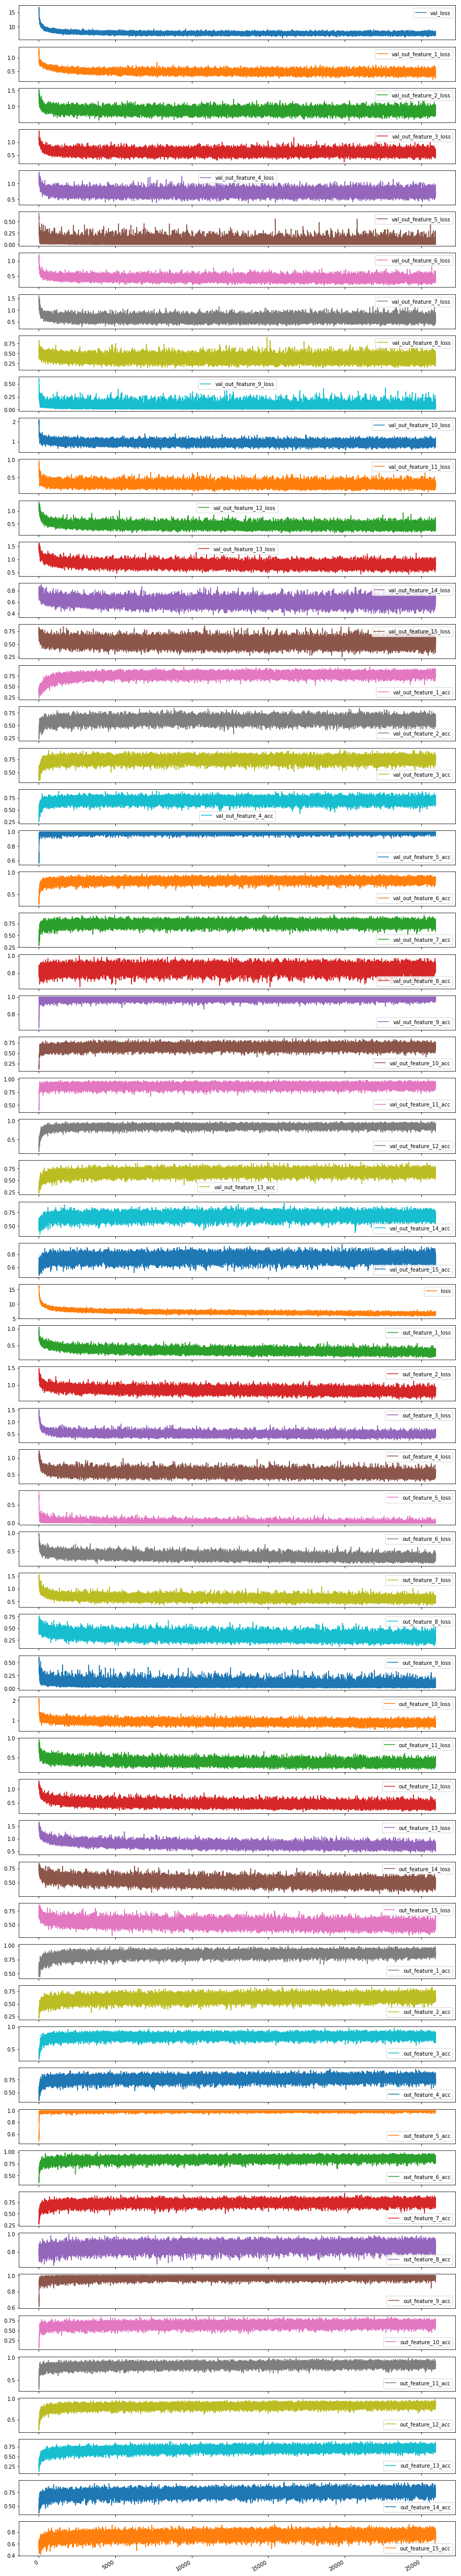

In [28]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<6.31]

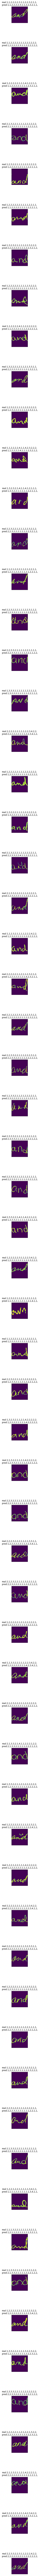

In [29]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('15-Multitask-FrozenEncoder-shuffled_v1.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [30]:
# print(df_hist.columns)
#total = 0
#for i in range(1,16):
#    print(df_hist.iloc[18351]['val_out_feature_{0}_acc'.format(i)].max())
#    total+=df_hist.iloc[18351]['val_out_feature_{0}_acc'.format(i)]
#print('total_acc:',total/15)
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

0.671875
0.578125
0.765625
0.640625
1.0
0.796875
0.71875
0.78125
0.953125
0.75
0.875
0.75
0.625
0.703125
0.734375
total_acc: 0.75625


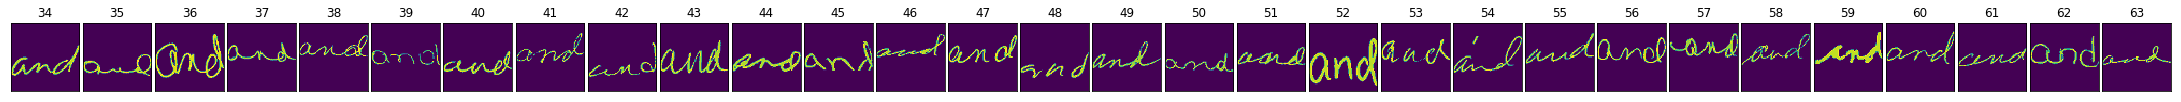

In [31]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [32]:
# plt.imshow(inputs[10].reshape((64,64)))
# plt.subplots_adjust(hspace = 0.1)
# for i in range(1,9):
#     visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
#     vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
#     vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
#     f,ax = plt.subplots(8,8)
#     f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
#     f.set_size_inches(15,15)
#     f.suptitle('dense_layer_'+str(i), fontsize=15)
# #     f.subplots_adjust(hspace = 0.1)
# #     plt.title('dense_layer_'+str(i))
#     print(vis_out.shape)
#     for r in range(8):
#         for c in range (8):
#             ax[r,c].imshow(vis_out[c+r*8])
#             ax[r,c].axis('off')
# #     break

In [33]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

# Evaluation

In [ ]:
#cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [ ]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('dense_layer_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('encoded').output)

In [ ]:
test_g = datagen(len(val_images)*5,val_path,val_images, vshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [ ]:
feature_wise_pred_y=human_features_eval.predict(testx)
latent_pred_y=human_features_encoder.predict(testx)

In [ ]:
feature_wise_pred_y=np.array(feature_wise_pred_y)
latent_pred_y=np.array(latent_pred_y).reshape((-1,512))

In [ ]:
latent_pred_y.shape,feature_wise_pred_y.shape

In [ ]:
ids = testy[0].reshape(-1,1)
imagenames = testy[1].reshape(-1,1)
data=[]
for i in range(len(testx)):
    data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(10)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [ ]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [ ]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.8
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 20
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [ ]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
df_cos_dist_out.head()

In [ ]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

In [ ]:
csv_data.var()